In [1]:
#IBL SWR detector
import os
import re
import subprocess 
import numpy as np
import pandas as pd
from scipy import io, signal, stats
from scipy.signal import lfilter
import scipy.ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
import matplotlib.pyplot as plt
import seaborn as sns
import ripple_detection
from ripple_detection import filter_ripple_band
import ripple_detection.simulate as ripsim # for making our time vectors
from tqdm import tqdm
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions
import spikeglx
from brainbox.io.one import load_channel_locations
from brainbox.io.spikeglx import Streamer
from brainbox.io.one import SpikeSortingLoader
from neurodsp.voltage import destripe_lfp
from ibllib.plots import Density
import time 
import traceback
import logging
import logging.handlers
import sys
from fitter import Fitter, get_common_distributions, get_distributions
import pickle
from one.api import ONE


ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

/home/acampbell/miniconda3/envs/ONE_ibl_env/lib/python3.10/site-packages/neurodsp/__init__.py:5: FutureWarning: neurodsp has been renamed to ibldsp and the old name will be deprecated on 01-Sep-2024.
  warn(


## Mouse information

In [2]:
# https://pypi.org/project/ndx-ibl-metadata/
from ndx_ibl_metadata import IblSessionData, IblSubject, IblProbes

In [3]:
ibl_ripples_path =  '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024'
ibl_lfp_path = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024_lfp_data'

In [4]:
infodict  = {'session':[], 'number_of_probes':[], }
session_failed = []
for sessionfolder in os.listdir(ibl_ripples_path)[0:2]:
    try:
        if '.csv' in sessionfolder:
            continue 
        session_id = sessionfolder.split('_')[-1]
        infodict['session'].append(session_id)
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        infodict['number_of_probes'].append(sum('karlsson' in filename for filename in folderfiles))
    except:
        session_failed.append(session_id)

In [5]:
session_info = one.alyx.rest(f'sessions/{session_id}','list')
subject_table = one.alyx.rest('subjects/' + session_info['subject'],'list')

In [6]:
from collections import Counter

subject_data = {
    'age': str(subject_table.get('age_weeks')),
    'sex': subject_table.get('sex'),
    "strain": subject_table.get('strain')
}

infodict  = {**{key: [] for key in subject_data.keys()}, 'session':[], 'number_of_probes':[]}
session_failed = []

for sessionfolder in os.listdir(ibl_ripples_path):
    try:
        if '.csv' in sessionfolder:
            continue 
        session_id = sessionfolder.split('_')[-1]
        infodict['session'].append(session_id)
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        infodict['number_of_probes'].append(sum('karlsson' in filename for filename in folderfiles))
        
        # Append subject data to infodict
        for key in subject_data.keys():
            infodict[key].append(subject_data[key])
    except:
        session_failed.append(session_id)

# Print the unique values and their counts for each field except 'session' and 'subject_id'
for key in set(infodict.keys()) - {'session', 'subject_id'}:
    print(f"{key}:")
    for value, count in Counter(infodict[key]).items():
        print(f"  {value}: {count}")

number_of_probes:
  1: 136
  2: 25
age:
  207: 161
sex:
  M: 161
strain:
  None: 161


In [7]:
subject_data = {'age': str(subject_table.get('age_weeks')),
                'subject_id' : subject_table.get('id'),
                'description': subject_table.get('description'),
                'sex': subject_table.get('sex'),
                "strain": subject_table.get('strain')}

In [8]:
infodict

{'age': ['207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '207',
  '

## Ripples by theta and Wheel Speed

In [9]:
from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:

theta_filter_path = '/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz'
theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter['arr_0']

In [12]:
#
speeds = []
theta_powers = {'peakwindow_med':[],'peakwindow_mean':[],
                'eventwindow_med':[],'eventwindow_mean':[]}
theta_compute_halfwindow = 0.125
failed_sesh = []




In [13]:
"""
for sessionfolder in os.listdir(ibl_ripples_path)[0:1]:
    try:
        if '.csv' in sessionfolder:
            continue 
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        try:
            global_ripples_filename = [file for file in folderfiles if 'global_swrs' in file][0]
        except:
            continue
        global_ripples_df = pd.read_csv(os.path.join(folder_path, global_ripples_filename), compression='gzip')
        session_id = sessionfolder.split('_')[-1]
        
        # getting speeds
        wheel = one.load_object(session_id, 'wheel', collection='alf')
        pos, t = wh.interpolate_position(wheel.timestamps, wheel.position)
        delta_t = 1/np.array([t[i]-t[i-1] for i in range(1,t.shape[0]) ]).mean()
        wh_vel, wh_accel = wh.velocity_filtered(pos, delta_t)
        
        average_speeds = []
        for _, row in global_ripples_df.iterrows():
            start_time = row['start_time']
            end_time = row['end_time']
            mask = (t >= start_time) & (t <= end_time)
            average_speed = np.abs(wh_vel[mask]).mean()
            average_speeds.append(average_speed)
        
        global_ripples_df['average_speed'] = average_speeds
        speeds.extend(average_speeds)
        
        lfp_session_path = f"{ibl_lfp_path}/lfp_session_{session_id}"
        lfp_files = os.listdir(lfp_session_path)
        for file in folderfiles:
            # we load lfp data for the karlsson files, then we compute theta power (zscored) and take that values
            # in a window around the peak of the swr
            if not 'karlsson' in file:
                continue
            
            # load the data
            events_df = pd.read_csv(os.path.join(folder_path,file), compression ='gzip')
            events_df = events_df[(events_df.Overlaps_with_gamma==True) & (events_df.Overlaps_with_movement==True)]
            probe_id = re.search(r'probe_(.*?)_', file).group(1)
            channel_indx = re.search(r'channelsrawInd_(.*?)_', file).group(1)
            lfp_data = [file for file in lfp_files if f"channelsrawInd_{channel_indx}" in file and probe_id in file and "ca1_peakripplepower.npz" in file]
            lfp_data = np.load(os.path.join(lfp_session_path,lfp_data[0]))
            lfp_data = lfp_data['lfp_ca1']
            lfp_times = [file for file in lfp_files if f"channelsrawInd_{channel_indx}" in file and probe_id in file and "time_index_1500hz.npz" in file]
            lfp_times = np.load(os.path.join(lfp_session_path,lfp_times[0]))
            lfp_times = lfp_times['lfp_time_index']
            
            # compute theta power
            theta_pow_zscore = np.convolve(lfp_data, theta_filter, mode='same')
            theta_pow_zscore = scipy.stats.zscore(np.abs(signal.hilbert(theta_pow_zscore))**2)
            
            for _, event in events_df.iterrows():
                # Compute median and mean for peak window
                peak_start = event['Peak_time'] - theta_compute_halfwindow
                peak_end = event['Peak_time'] + theta_compute_halfwindow
                peak_window_data = theta_pow_zscore[(lfp_times >= peak_start) & (lfp_times <= peak_end)]
                theta_powers['peakwindow_med'].append(np.median(peak_window_data))
                theta_powers['peakwindow_mean'].append(np.mean(peak_window_data))

                # Compute median and mean for event window
                event_window_data = theta_pow_zscore[(lfp_times >= event['start_time']) & (lfp_times <= event['end_time'])]
                theta_powers['eventwindow_med'].append(np.median(event_window_data))
                theta_powers['eventwindow_mean'].append(np.mean(event_window_data))
    except:
        failed_sesh.append(sessionfolder)
        continue
"""




'\nfor sessionfolder in os.listdir(ibl_ripples_path)[0:1]:\n    try:\n        if \'.csv\' in sessionfolder:\n            continue \n        folder_path = os.path.join(ibl_ripples_path, sessionfolder)\n        folderfiles = os.listdir(folder_path)\n        try:\n            global_ripples_filename = [file for file in folderfiles if \'global_swrs\' in file][0]\n        except:\n            continue\n        global_ripples_df = pd.read_csv(os.path.join(folder_path, global_ripples_filename), compression=\'gzip\')\n        session_id = sessionfolder.split(\'_\')[-1]\n        \n        # getting speeds\n        wheel = one.load_object(session_id, \'wheel\', collection=\'alf\')\n        pos, t = wh.interpolate_position(wheel.timestamps, wheel.position)\n        delta_t = 1/np.array([t[i]-t[i-1] for i in range(1,t.shape[0]) ]).mean()\n        wh_vel, wh_accel = wh.velocity_filtered(pos, delta_t)\n        \n        average_speeds = []\n        for _, row in global_ripples_df.iterrows():\n      

In [14]:
# saved to avoid having to regenerate it, only used in debugging, will delete in and this seciton later

# Save the dictionary
#with open('theta_powers_ibl.pkl', 'wb') as f:
#    pickle.dump(theta_powers, f)

# Save the numpy array
#np.save('speeds_ibl.npy', speeds)

In [15]:
with open('/home/acampbell/theta_powers_ibl.pkl', 'rb') as f:
    theta_powers = pickle.load(f)

# Load the numpy array
speeds = np.load('/home/acampbell/speeds_ibl.npy')


In [16]:
len(speeds)

217202

In [17]:
print(theta_powers['peakwindow_med'][0:5])
print(theta_powers['peakwindow_mean'][0:5])
print(theta_powers['eventwindow_med'][0:5])
print(theta_powers['eventwindow_mean'][0:5])

[0.23518028384686465, 0.5732154331651866, 1.5985260122850942, -0.16323959665790522, 4.617420330287844]
[0.15589910970860368, 0.5155955743665097, 1.5417713828960693, -0.0970403154623254, 3.7960752236111097]
[0.478323196291428, 0.9563774688016099, 2.15248655129329, -0.1321801128277746, 5.537797158281668]
[0.4205544305048518, 0.8571026575356367, 2.025033684338973, -0.13094182867530463, 5.250610796971575]


In [18]:
import pandas as pd

columns = ['peakwindow_med', 'peakwindow_mean', 'eventwindow_med', 'eventwindow_mean']
nan_indices = []
cleaned_theta_data = {}

for col in columns:
    data = pd.Series(theta_powers[col])
    nan_index = data.index[data.isna()].tolist()
    nan_indices.append(set(nan_index))
    cleaned_theta_data[col] = data.dropna()

# Check if all NaN indices are the same
if len(set.intersection(*nan_indices)) == len(nan_indices[0]):
    print("All NaN indices are the same.")
else:
    print("NaN indices are not the same.")

# Print min and max values of cleaned data
for col, data in cleaned_theta_data.items():
    print(f"For {col}, Min: {data.min()}, Max: {data.max()}")

All NaN indices are the same.
For peakwindow_med, Min: -1.1418453235290944, Max: 89.99995746102553
For peakwindow_mean, Min: -1.1112523147827573, Max: 85.86173226022319
For eventwindow_med, Min: -1.1907076698537382, Max: 128.42608768556204
For eventwindow_mean, Min: -1.1894699340446324, Max: 126.86507692637028


In [19]:
cleaned_theta_data.keys()

dict_keys(['peakwindow_med', 'peakwindow_mean', 'eventwindow_med', 'eventwindow_mean'])

In [20]:
figure_six_path = "/home/acampbell/NeuropixelsLFPOnRamp/TechnicalValidation/figures/figure6/"

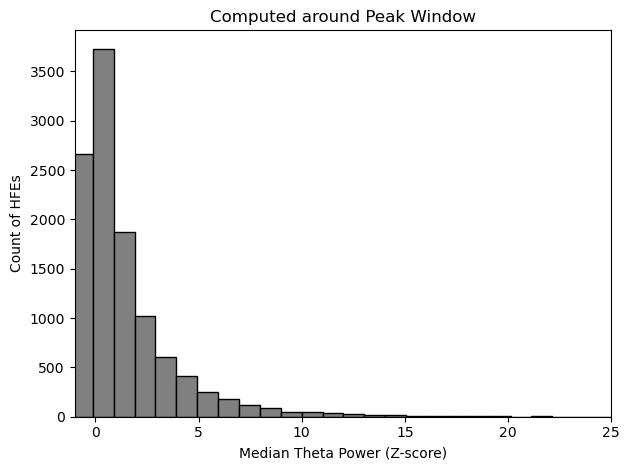

In [21]:
plt.hist(cleaned_theta_data['peakwindow_med'], bins=90, edgecolor='black', facecolor='grey')
plt.xlim(-1, 25)
plt.xlabel('Median Theta Power (Z-score)')
plt.ylabel('Count of HFEs')
plt.title('Computed around Peak Window')
plt.tight_layout()
plt.show()

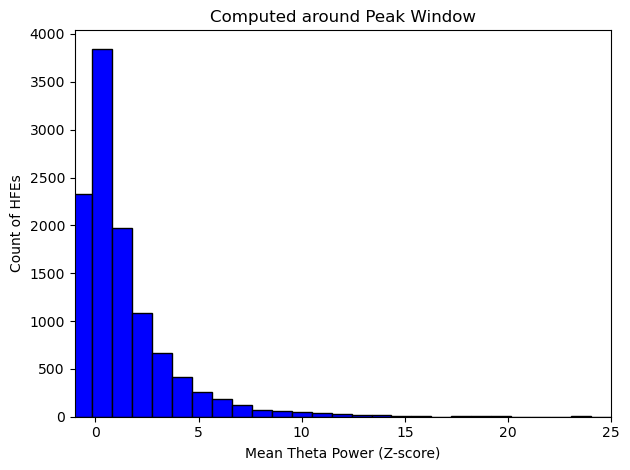

In [22]:
# Ensure text is exported as text objects
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text


plt.hist(cleaned_theta_data['peakwindow_mean'], bins=90, edgecolor='black', facecolor='blue')
plt.xlim(-1, 25)
plt.xlabel('Mean Theta Power (Z-score)')
plt.ylabel('Count of HFEs')
plt.title('Computed around Peak Window')
plt.tight_layout()
plt.savefig(f"{figure_six_path}six_b.svg", format='svg')
plt.show()

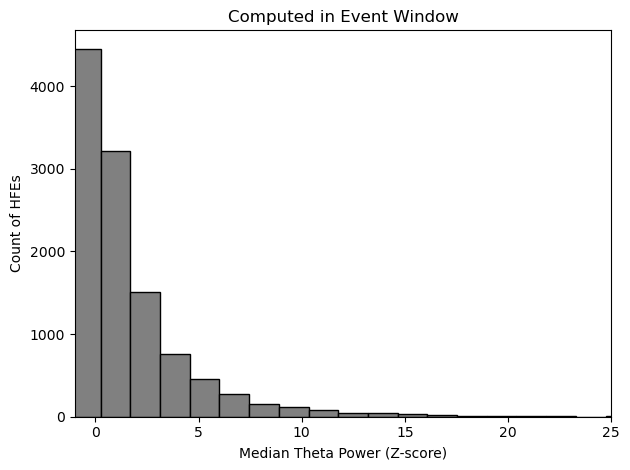

In [23]:
plt.hist(cleaned_theta_data['eventwindow_med'], bins=90, edgecolor='black', facecolor='grey')
plt.xlim(-1, 25)
plt.xlabel('Median Theta Power (Z-score)')
plt.ylabel('Count of HFEs')
plt.title('Computed in Event Window')
plt.tight_layout()
plt.show()

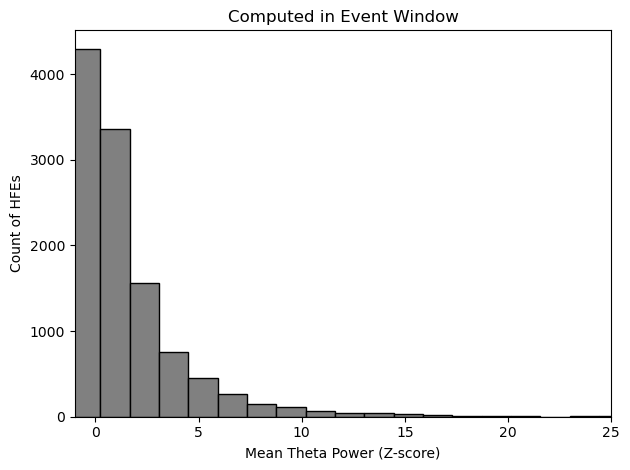

In [24]:
plt.hist(cleaned_theta_data['eventwindow_mean'], bins=90, edgecolor='black', facecolor='grey')
plt.xlim(-1, 25)
plt.xlabel('Mean Theta Power (Z-score)')
plt.ylabel('Count of HFEs')
plt.title('Computed in Event Window')
plt.tight_layout()
plt.show()

In [25]:
speed_cleaned = speeds[~np.isnan(speeds)]

In [26]:
speed_cleaned.max()

17.057541264876384

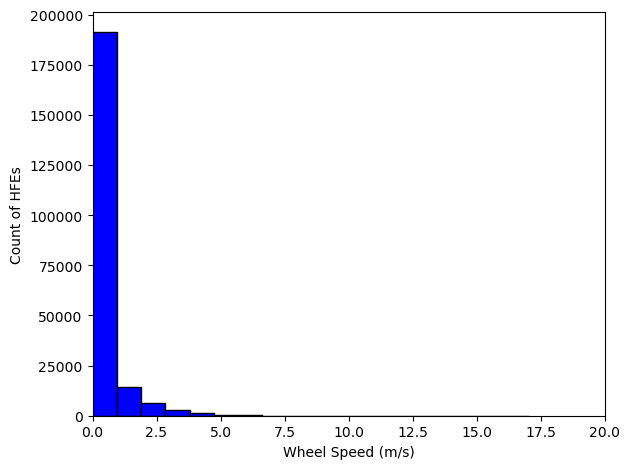

In [27]:
# Ensure text is exported as text objects
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text


plt.hist(speeds, bins=18, edgecolor='black', facecolor='blue')
plt.xlim(0, 20)
plt.xlabel('Wheel Speed (m/s)')
plt.ylabel('Count of HFEs')
plt.tight_layout()
plt.savefig(f"{figure_six_path}six_d.svg", format='svg')
plt.show()

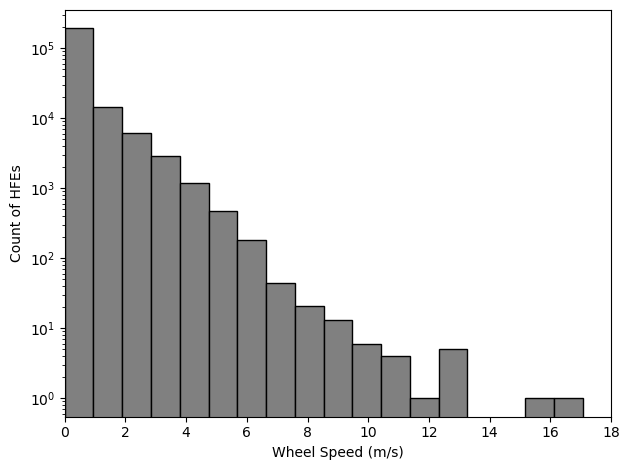

In [28]:
plt.hist(speeds, bins=18, edgecolor='black', facecolor='grey', log=True)
plt.xlim(0, 18)
plt.xlabel('Wheel Speed (m/s)')
plt.ylabel('Count of HFEs')
plt.yscale('log', base=10)
plt.tight_layout()
plt.show()

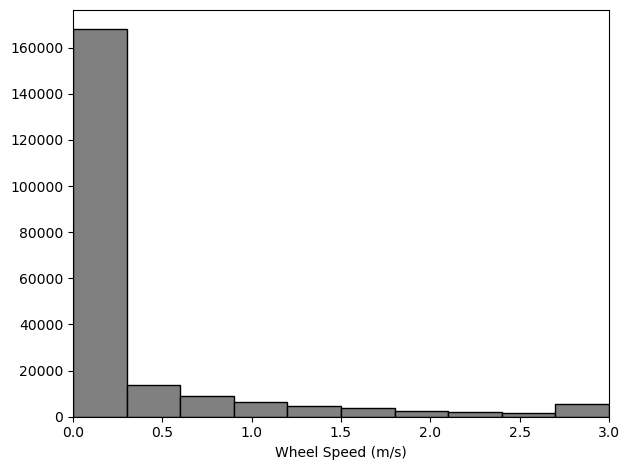

In [29]:
# Matplotlib
plt.hist(np.minimum(speeds, 3), bins=10, edgecolor='black', facecolor='grey')
plt.xlim(0, 3)
plt.xlabel('Wheel Speed (m/s)')
plt.tight_layout()
plt.show()

## Ripple Distributions

In [30]:
path = '/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024/eventspersession_df.csv'
df = pd.read_csv(path)
df.columns

Index(['Unnamed: 0', 'session_id', 'probe_id', 'ripple_number'], dtype='object')

In [31]:
# getting 
directories = os.listdir(ibl_ripples_path)

processed_sesh_ids = [dir.replace('swrs_session_', '') for dir in directories if 'swrs_session_' in dir]

print(processed_sesh_ids)

['0cc486c3-8c7b-494d-aa04-b70e2690bcba', '746d1902-fa59-4cab-b0aa-013be36060d5', '6a601cc5-7b79-4c75-b0e8-552246532f82', 'edd22318-216c-44ff-bc24-49ce8be78374', '6c6983ef-7383-4989-9183-32b1a300d17a', 'd23a44ef-1402-4ed7-97f5-47e9a7a504d9', '5386aba9-9b97-4557-abcd-abc2da66b863', 'c6db3304-c906-400c-aa0f-45dd3945b2ea', 'a2701b93-d8e1-47e9-a819-f1063046f3e7', '3e6a97d3-3991-49e2-b346-6948cb4580fb', '8928f98a-b411-497e-aa4b-aa752434686d', '3638d102-e8b6-4230-8742-e548cd87a949', 'fcd49e34-f07b-441c-b2ac-cb8c462ec5ac', '0c828385-6dd6-4842-a702-c5075f5f5e81', 'b39752db-abdb-47ab-ae78-e8608bbf50ed', '1a507308-c63a-4e02-8f32-3239a07dc578', '572a95d1-39ca-42e1-8424-5c9ffcb2df87', '15b69921-d471-4ded-8814-2adad954bcd8', '02fbb6da-3034-47d6-a61b-7d06c796a830', '4b00df29-3769-43be-bb40-128b1cba6d35', 'd9f0c293-df4c-410a-846d-842e47c6b502', '9b528ad0-4599-4a55-9148-96cc1d93fb24', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '7691eeb3-715b-4571-8fda-6bb57aab8253', 'ebe090af-5922-4fcd-8fc6-17b8ba7bad6d',

In [32]:
all_swrs_df = pd.DataFrame()
global_swr_failed_session = []
for sessionfolder in os.listdir(ibl_ripples_path):
    try:
        if 'global_swrs_no_movement_no_gamma.csv' in sessionfolder:
            continue 
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        try:
            global_ripples_filename = [file for file in folderfiles if 'global_swrs' in file][0]
            
        except:
            continue
        global_ripples_df = pd.read_csv(os.path.join(folder_path, global_ripples_filename), compression='gzip')
        global_ripples_df['duration'] = global_ripples_df['end_time'] - global_ripples_df['start_time']
        global_ripples_df['session_id'] = sessionfolder.replace('swrs_session_', '')
        all_swrs_df = pd.concat([all_swrs_df, global_ripples_df])
    except:
        global_swr_failed_session.append(sessionfolder)

In [33]:
all_swrs_df.columns

Index(['start_time', 'end_time', 'probes_event_is_on', 'events_row_index',
       'global_peak_time', 'global_max_zscore', 'peak_probe', 'duration',
       'session_id'],
      dtype='object')

sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm          0.000009  1983.455982 -5.187983e+06     inf      0.020017   
halfnorm         0.000129  3449.860952 -4.614923e+06     inf      0.071626   
norm             0.000203  6001.876523 -4.515857e+06     inf      0.128276   

             ks_pvalue  
lognorm   4.994002e-76  
halfnorm  0.000000e+00  
norm      0.000000e+00

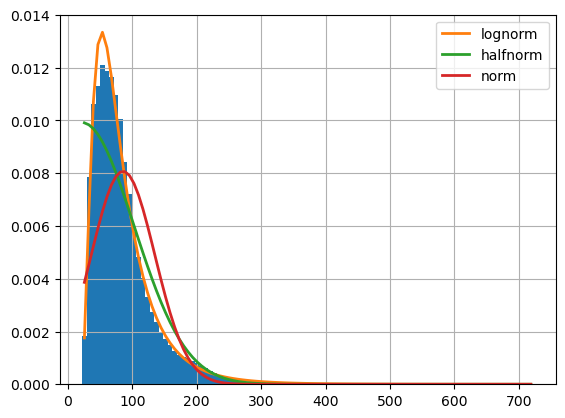

In [34]:
f_distributions_dur = Fitter(all_swrs_df['duration']*1000,
           distributions=['norm',
                          'lognorm',
                         'halfnorm'])
f_distributions_dur.fit()
f_distributions_dur.summary()

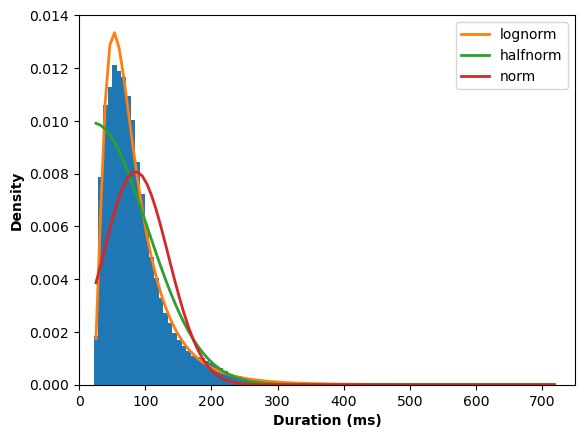

In [35]:
# Ensure text is exported as text objects
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text

# Plot the histogram
f_distributions_dur.hist()

# Plot the PDF
f_distributions_dur.plot_pdf()

# Get the current axes and turn off the grid
ax = plt.gca()
ax.grid(False)
ax.set_xlim(0, 750)

# Set the title and axis labels
ax.set_xlabel('Duration (ms)', fontweight='bold')
ax.set_ylabel('Density',  fontweight='bold')
plt.savefig(f"{figure_six_path}six_f.svg", format='svg')
# Display the plot
plt.show()

sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm          0.006026  1697.826218 -3.779317e+06     inf      0.045788   
halfnorm         0.080755  5431.719238 -3.215634e+06     inf      0.224892   
norm             0.133957  8147.213547 -3.105708e+06     inf      0.222171   

          ks_pvalue  
lognorm         0.0  
halfnorm        0.0  
norm            0.0

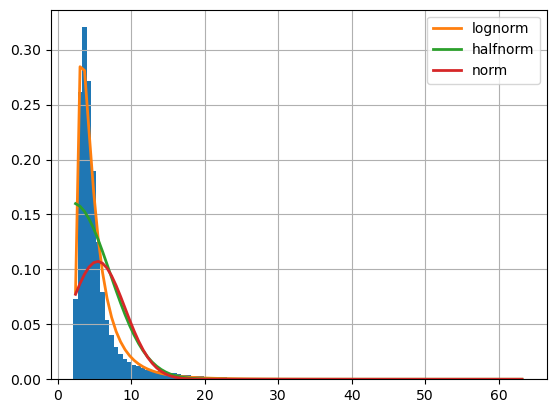

In [36]:
f_distributions_pow = Fitter(all_swrs_df['global_max_zscore'],
           distributions=['norm',
                          'lognorm',
                         'halfnorm'])
f_distributions_pow.fit()
f_distributions_pow.summary()

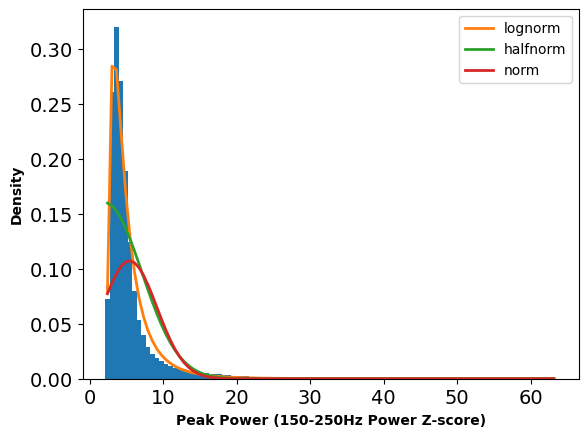

In [37]:
# Ensure text is exported as text objects
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text

# Plot the histogram
f_distributions_pow.hist()

# Plot the PDF
f_distributions_pow.plot_pdf()

# Get the current axes and turn off the grid
ax = plt.gca()
ax.grid(False)

# Set x-axis limits
#ax.set_xlim([0, 70])  # replace with your desired limits

# Set label size
ax.tick_params(axis='both', which='major', labelsize=14)  # replace with your desired label size
# Set the title and axis labels
ax.set_xlabel('Peak Power (150-250Hz Power Z-score)', fontweight='bold')
ax.set_ylabel('Density',  fontweight='bold')
plt.savefig(f"{figure_six_path}six_h.svg", format='svg')
# Display the plot
plt.show()

## Artifact Plots

import os
import glob
import pandas as pd
import numpy as np
import re

ibl_lfps = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024_lfp_data'
ibl_swrs = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024'

# Define the session ID and the key substrings
session_id = 'dd4da095-4a99-4bf3-9727-f735077dba66'
session_id = '61e11a11-ab65-48fb-ae08-3cb80662e5d6'
csv_keys = ['karlsson_detector_events', 'gamma_band_events', 'movement_artifacts']
npz_keys = ['lfp_ca1_peakripplepower', 'lfp_control_channel', 'lfp_time_index_1500hz']

# Initialize dictionaries to store file paths and data
csv_file_paths = {}
npz_file_paths = {}
data = {}

# Scan the directories for files that contain the key substrings
for key in csv_keys:
    # Get the list of files that contain the key substring
    files = sorted(glob.glob(f'{ibl_swrs}/swrs_session_{session_id}/probe_*_{key}.*'))
    
    # Extract the probe_ids from the file names
    probe_ids = [re.search('probe_(.*)', file).group(1) for file in files]

    # Reduce to a unique list
    unique_probe_ids = list(set(probe_ids))

    # Take the first one
    first_probe_id = unique_probe_ids[0] if unique_probe_ids else None

    print(f'First unique probe_id for {key}: {first_probe_id}')

    # If there are multiple files, take the first one with the first unique probe_id
    if files:
        for file in files:
            if first_probe_id in file:
                csv_file_paths[key] = file
                break

# Scan the directories for files that contain the key substrings
for key in npz_keys:
    # Get the list of files that contain the key substring
    files = sorted(glob.glob(f'{ibl_lfps}/lfp_session_{session_id}/probe_*_{key}.*'))
    
    # Extract the probe_ids from the file names
    probe_ids = [re.search('probe_(.*)', file).group(1) for file in files]

    # Reduce to a unique list
    unique_probe_ids = list(set(probe_ids))

    # Take the first one
    first_probe_id = unique_probe_ids[0] if unique_probe_ids else None

    print(f'First unique probe_id for {key}: {first_probe_id}')

    # If there are multiple files, take the first one with the first unique probe_id
    if files:
        for file in files:
            if first_probe_id in file:
                npz_file_paths[key] = file
                break

# Load the data from the files
for key, file_path in csv_file_paths.items():
    df = pd.read_csv(file_path, compression='gzip')
    if 'max_zscore' in df.columns:
        df = df[df.max_zscore >= 3]
    data[key] = df
   
for key, file_path in npz_file_paths.items():
    npz_data = np.load(file_path)
    for npz_key in npz_data.files:
        data[f'{key}_{npz_key}'] = npz_data[npz_key]

# Assign the data to the respective variables
swr_df = data.get('karlsson_detector_events')
gamma_events_df = data.get('gamma_band_events')
first_moveartifacts_df = data.get('movement_artifacts')
second_moveartifacts_df = data.get('movement_artifacts')
ca1_lfp_data = data.get('lfp_ca1_peakripplepower_lfp_ca1')
first_control_lfp_data = data.get('lfp_control_channel_lfp_control_channel')
second_control_lfp_data = data.get('lfp_control_channel_lfp_control_channel')
time_arr = data.get('lfp_time_index_1500hz_lfp_time_index')

# Compute gamma and ripple powers
ripple_band_ca1  = filter_ripple_band(ca1_lfp_data[:, None])
gamma_band_ca1 = np.convolve(ca1_lfp_data, gamma_filter, mode='same')
ripple_band_first_control = filter_ripple_band(first_control_lfp_data[:, None])
ripple_band_second_control = filter_ripple_band(second_control_lfp_data[:, None])

In [38]:
# lfp and filter filepath

# Pick a session at random...
#ibl_lfp_path = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024_lfp_data/lfp_session_61e11a11-ab65-48fb-ae08-3cb80662e5d6'
#ibl_swr_path = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024/swrs_session_61e11a11-ab65-48fb-ae08-3cb80662e5d6'
ibl_lfp_path = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024_lfp_data/lfp_session_dd4da095-4a99-4bf3-9727-f735077dba66'
ibl_swr_path = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024/swrs_session_dd4da095-4a99-4bf3-9727-f735077dba66'



gamma_filter_path = '/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/frank2008_gamma_1500hz_bandpass_filter.npz'
# The path to the theta filter
theta_filter_path = '/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz'
# The ripple band threshold

# loading filters (craetes artifacts in first and last ~ 3.5 seconds of recordings, remember to clip these off)
gamma_filter = np.load(gamma_filter_path)
gamma_filter = gamma_filter['arr_0']

theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter['arr_0']

In [39]:
os.listdir(ibl_lfp_path)

['probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_lfp_ca1_peakripplepower.npz',
 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_168_lfp_control_channel.npz',
 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_375_lfp_control_channel.npz',
 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_lfp_time_index_1500hz.npz']

In [40]:
os.listdir(ibl_swr_path)

['probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_gamma_band_events.csv',
 'session_dd4da095-4a99-4bf3-9727-f735077dba66_putative_global_swrs_no_movement_no_gamma.csv',
 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_168_movement_artifacts.csv',
 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_375_movement_artifacts.csv',
 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_karlsson_detector_events.csv']

In [56]:
# load the swrs data and the artifacts
figure_four_path = '/home/acampbell/NeuropixelsLFPOnRamp/TechnicalValidation/figures/figure4'

"""
probelevelswrs_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_259_karlsson_detector_events.csv'
gamma_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_259_gamma_band_events.csv'
first_movement_artifact_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_180_movement_artifacts.csv'
second_movement_artifact_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_336_movement_artifacts.csv'
"""

gamma_file =  'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_gamma_band_events.csv'
first_movement_artifact_file =  'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_168_movement_artifacts.csv'
second_movement_artifact_file = 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_375_movement_artifacts.csv'
probelevelswrs_file =   'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_karlsson_detector_events.csv'

# load the lfp events dfs
swr_df = pd.read_csv(os.path.join(ibl_swr_path,probelevelswrs_file),compression='gzip')
swr_df = swr_df[swr_df.max_zscore>=3]
gamma_events_df = pd.read_csv(os.path.join(ibl_swr_path,gamma_file),compression='gzip')
first_moveartifacts_df = pd.read_csv(os.path.join(ibl_swr_path,first_movement_artifact_file),compression='gzip')
second_moveartifacts_df = pd.read_csv(os.path.join(ibl_swr_path,second_movement_artifact_file),compression='gzip')

# load the lfp data
"""
ca1_chan_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_259_lfp_ca1_peakripplepower.npz'
first_control_chan_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_180_lfp_control_channel.npz'
second_control_chan_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_336_lfp_control_channel.npz'
time_index_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_259_lfp_time_index_1500hz.npz'
"""
ca1_chan_file = 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_lfp_ca1_peakripplepower.npz'
first_control_chan_file =  'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_168_lfp_control_channel.npz'
second_control_chan_file = 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_375_lfp_control_channel.npz'
time_index_file = 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_lfp_time_index_1500hz.npz'

ca1_lfp_data = np.load(os.path.join(ibl_lfp_path,ca1_chan_file))
ca1_lfp_data = ca1_lfp_data['lfp_ca1']
first_control_lfp_data = np.load(os.path.join(ibl_lfp_path,first_control_chan_file))
first_control_lfp_data = first_control_lfp_data['lfp_control_channel']
second_control_lfp_data = np.load(os.path.join(ibl_lfp_path,second_control_chan_file))
second_control_lfp_data = second_control_lfp_data['lfp_control_channel']
time_arr = np.load(os.path.join(ibl_lfp_path,time_index_file))
time_arr = time_arr['lfp_time_index']

# Compute gamma and ripple powers
ripple_band_ca1  = np.squeeze(filter_ripple_band(ca1_lfp_data[:,None]))
gamma_band_ca1 = np.convolve(ca1_lfp_data, gamma_filter, mode='same')
ripple_band_first_control = np.squeeze(filter_ripple_band(first_control_lfp_data[:,None]))
ripple_band_second_control = np.squeeze(filter_ripple_band(second_control_lfp_data[:,None]))


In [43]:
swr_df[(swr_df['Overlaps_with_movement']==False) & (swr_df['Overlaps_with_gamma']==False)].sort_values('max_zscore', ascending=False).head(10)

event_number   start_time     end_time  duration  mean_zscore  \
93             96   710.893555   711.028222  0.134667     5.772133   
311           323  1728.815207  1728.936540  0.121333     8.118224   
69             72   536.015501   536.072167  0.056667     9.419180   
317           330  1773.157221  1773.286554  0.129333     3.767396   
319           332  1776.327222  1776.417222  0.090000     7.249672   
354           369  1849.233244  1849.320578  0.087333     7.178831   
190           199  1267.951729  1268.079729  0.128000     4.421469   
170           178  1132.081687  1132.216354  0.134667     7.303685   
340           353  1814.561234  1814.653900  0.092667     6.617774   
298           309  1671.085189  1671.241855  0.156667     3.961716   

     median_zscore  max_zscore  min_zscore    Peak_time  Overlaps_with_gamma  \
93        1.360401   30.025266    0.030431   710.967555                False   
311       4.492035   25.731307    0.012713  1728.857873                False   
69        6.621874   24.554449    0.028908   536.042167                False   
317       0.560085   23.355002    0.011441  1773.237887                False   
319       4.125804   22.396385    0.021242  1776.355888                False   
354       3.008206   22.039039    0.008441  1849.266578                False   
190       1.320305   21.355201    0.017884  1268.045063                False   
170       6.235302   21.275243    0.009555  1132.141687                False   
340       1.754542   21.069848    0.013826  1814.603900                False   
298       1.322567   20.672179    0.001173  1671.171855                False   

     Overlaps_with_movement  
93                    False  
311                   False  
69                    False  
317                   False  
319                   False  
354                   False  
190                   False  
170                   False  
340                   False  
298                   False

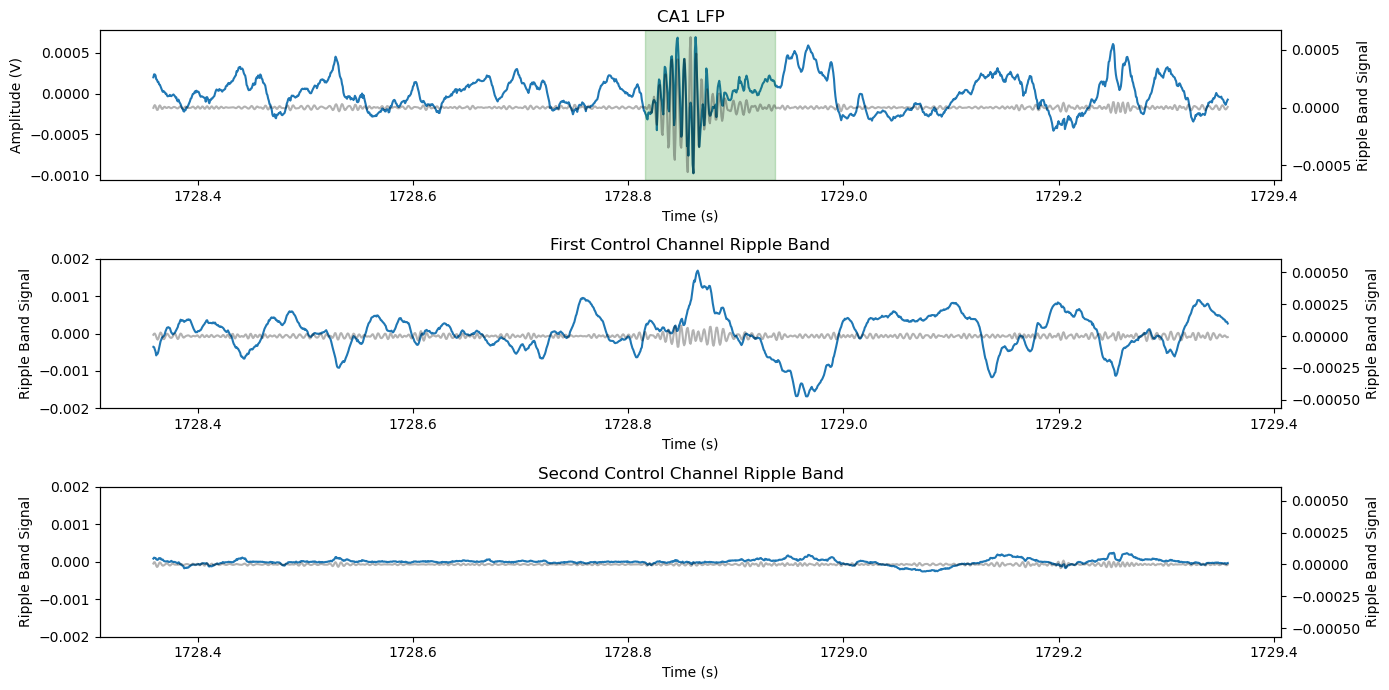

In [59]:
# Change the event number to pick a different ripple
rip_id = 323
peaktime = swr_df.Peak_time[swr_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_lfp_data_slice = ca1_lfp_data[mask]
ripple_band_ca1_slice = ripple_band_ca1[mask]

# Calculate global min and max for LFP data
lfp_min = min(np.min(ca1_lfp_data_slice), np.min(first_control_lfp_data[mask]), np.min(second_control_lfp_data[mask]))
lfp_max = max(np.max(ca1_lfp_data_slice), np.max(first_control_lfp_data[mask]), np.max(second_control_lfp_data[mask]))

# Calculate global min and max for ripple band data
ripple_min = min(np.min(ripple_band_ca1_slice), np.min(ripple_band_first_control[mask]), np.min(ripple_band_second_control[mask]))
ripple_max = max(np.max(ripple_band_ca1_slice), np.max(ripple_band_first_control[mask]), np.max(ripple_band_second_control[mask]))

plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_lfp_data_slice)
plt.title('CA1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ripple_band_ca1_slice, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

"""
# Add red dotted lines
rip_start_time = swr_df.start_time[swr_df.event_number == rip_id].values[0]
plt.axvline(x=rip_start_time, color='r', linestyle=':', linewidth=4)
rip_end_time = swr_df.end_time[swr_df.event_number == rip_id].values[0]
plt.axvline(x=rip_end_time, color='r', linestyle=':', linewidth=4)
"""

# Get start and end times
rip_start_time = swr_df.start_time[swr_df.event_number == rip_id].values[0]
rip_end_time = swr_df.end_time[swr_df.event_number == rip_id].values[0]

# Add green shaded block
plt.axvspan(rip_start_time, rip_end_time, color='green', alpha=0.2)

plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, first_control_lfp_data[mask])
plt.ylim(-0.002, 0.002)
plt.title('First Control Channel Ripple Band')
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')

# Add the ripple band for the first control channel
ax4 = plt.twinx()  # Create a second y-axis
ax4.plot(time_arr_slice, ripple_band_first_control[mask], color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax4.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax4.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

plt.subplot(3, 1, 3)
plt.plot(time_arr_slice, second_control_lfp_data[mask])
plt.ylim(-0.002, 0.002)
plt.title('Second Control Channel Ripple Band') 
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')

# Add the ripple band for the second control channel
ax6 = plt.twinx()  # Create a second y-axis
ax6.plot(time_arr_slice, ripple_band_second_control[mask], color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax6.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax6.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

plt.tight_layout()
plt.savefig(f"{figure_four_path}four_a.svg", format='svg')
plt.show()

In [ ]:
first_artifact_df = pd.read_csv(os.path.join(ibl_swr_path, first_movement_artifact_file), compression = 'gzip') 
second_artifact_df = pd.read_csv(os.path.join(ibl_swr_path, second_movement_artifact_file), compression = 'gzip') 

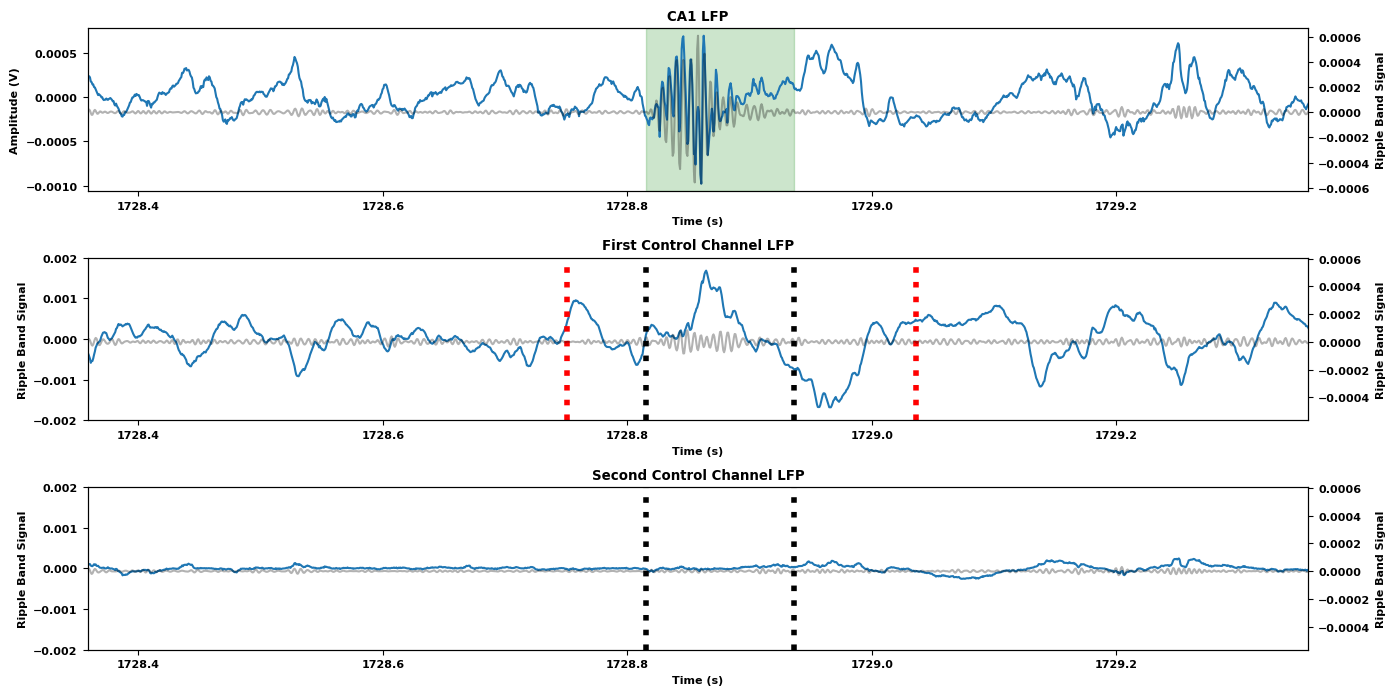

In [129]:
# Change the event number to pick a different ripple
rip_id = 323
peaktime = swr_df.Peak_time[swr_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_lfp_data_slice = ca1_lfp_data[mask]
ripple_band_ca1_slice = ripple_band_ca1[mask]
linethickness = 4

# Calculate global min and max for LFP data
lfp_min = min(np.min(ca1_lfp_data_slice), np.min(first_control_lfp_data[mask]), np.min(second_control_lfp_data[mask]))
lfp_max = max(np.max(ca1_lfp_data_slice), np.max(first_control_lfp_data[mask]), np.max(second_control_lfp_data[mask]))

# Calculate global min and max for ripple band data
ripple_min = min(np.min(ripple_band_ca1_slice), np.min(ripple_band_first_control[mask]), np.min(ripple_band_second_control[mask]))
ripple_max = max(np.max(ripple_band_ca1_slice), np.max(ripple_band_first_control[mask]), np.max(ripple_band_second_control[mask]))

plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_lfp_data_slice)
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.title('CA1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        # Check if the event overlaps with gamma or movement
        if event.Overlaps_with_gamma or event.Overlaps_with_movement:
            plt.axvspan(event.start_time, event.end_time, color='red', alpha=0.2)
        else:
            plt.axvspan(event.start_time, event.end_time, color='green', alpha=0.2)

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ripple_band_ca1_slice, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, first_control_lfp_data[mask])
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-0.002, 0.002)
plt.title('First Control Channel LFP')
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')


# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted',linewidth=linethickness)
        plt.axvline(x=event.end_time, color='black', linestyle='dotted',linewidth=linethickness)
        
        
# Iterate over all events in first_artifact_df
for idx, row in first_artifact_df.iterrows():
    # Check if the event overlaps with the time slice
    if row['start_time'] < time_arr_slice[-1] and row['end_time'] > time_arr_slice[0]:
        plt.axvline(x=row['start_time'], color='red', linestyle='dotted', linewidth=linethickness)
        plt.axvline(x=row['end_time'], color='red', linestyle='dotted', linewidth=linethickness)

# Add the ripple band for the first control channel
ax4 = plt.twinx()  # Create a second y-axis
ax4.plot(time_arr_slice, ripple_band_first_control[mask], color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax4.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax4.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

plt.subplot(3, 1, 3)
plt.plot(time_arr_slice, second_control_lfp_data[mask])
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-0.002, 0.002)
plt.title('Second Control Channel LFP') 
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted',linewidth=linethickness)
        plt.axvline(x=event.end_time, color='black', linestyle='dotted',linewidth=linethickness)

# Iterate over all events in second_artifact_df
for idx, row in second_artifact_df.iterrows():
    # Check if the event overlaps with the time slice
    if row['start_time'] < time_arr_slice[-1] and row['end_time'] > time_arr_slice[0]:
        plt.axvline(x=row['start_time'], color='red', linestyle='dotted', linewidth=linethickness)
        plt.axvline(x=row['end_time'], color='red', linestyle='dotted', linewidth=linethickness)
        
# Add the ripple band for the second control channel
ax6 = plt.twinx()  # Create a second y-axis
ax6.plot(time_arr_slice, ripple_band_second_control[mask], color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax6.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax6.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

plt.tight_layout()
plt.show()

In [130]:
swr_df[swr_df['Overlaps_with_movement']==True].sort_values('duration').head(10)

event_number   start_time     end_time  duration  mean_zscore  \
36             39   303.300095   303.352761  0.052667     1.955009   
497           523  2202.272021  2202.325355  0.053333     2.197448   
587           621  2379.062743  2379.119410  0.056667     2.961864   
460           484  2158.866008  2158.924008  0.058000     1.417612   
337           350  1807.564565  1807.623231  0.058667     6.295863   
351           366  1844.401909  1844.465910  0.064000     3.292973   
197           206  1322.359080  1322.426413  0.067333     2.000231   
265           275  1510.573139  1510.641139  0.068000    10.081460   
14             16    98.258031    98.326697  0.068667     3.574068   
335           348  1805.188564  1805.259897  0.071333     6.368234   

     median_zscore  max_zscore  min_zscore    Peak_time  Overlaps_with_gamma  \
36        1.127038    4.670553    0.029090   303.333428                False   
497       2.251855    4.561808    0.032595  2202.304688                False   
587       2.579648    6.465327    0.000270  2379.097410                False   
460       1.459360    3.074877    0.005421  2158.907341                False   
337       2.630870   19.384033    0.023330  1807.595231                 True   
351       1.587644   10.220644    0.010976  1844.433910                False   
197       1.192067    4.897774    0.012515  1322.375746                 True   
265       8.156676   25.303723    0.000517  1510.609139                False   
14        3.311438    8.297568    0.024516    98.287364                False   
335       3.611110   18.219762    0.002017  1805.219231                False   

     Overlaps_with_movement  
36                     True  
497                    True  
587                    True  
460                    True  
337                    True  
351                    True  
197                    True  
265                    True  
14                     True  
335                    True

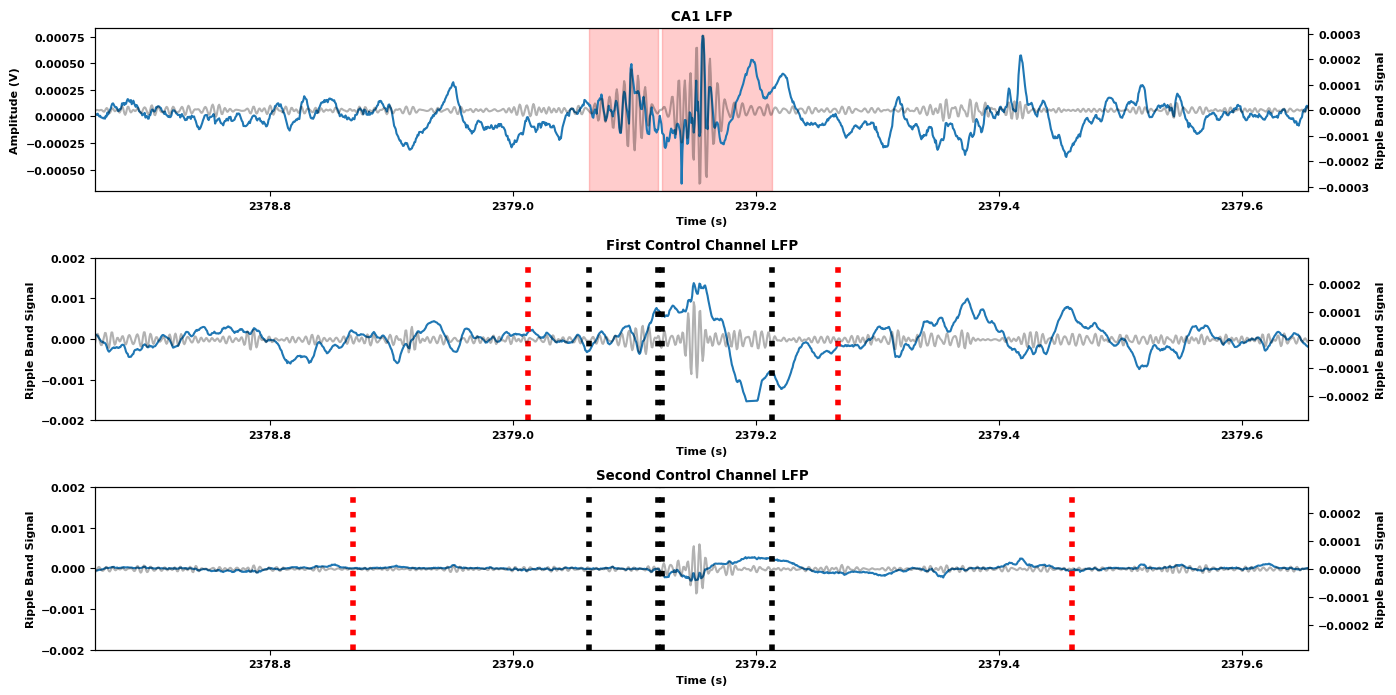

In [127]:
# Change the event number to pick a different ripple
rip_id = 622
peaktime = swr_df.Peak_time[swr_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_lfp_data_slice = ca1_lfp_data[mask]
ripple_band_ca1_slice = ripple_band_ca1[mask]
linethickness = 4

# Calculate global min and max for LFP data
lfp_min = min(np.min(ca1_lfp_data_slice), np.min(first_control_lfp_data[mask]), np.min(second_control_lfp_data[mask]))
lfp_max = max(np.max(ca1_lfp_data_slice), np.max(first_control_lfp_data[mask]), np.max(second_control_lfp_data[mask]))

# Calculate global min and max for ripple band data
ripple_min = min(np.min(ripple_band_ca1_slice), np.min(ripple_band_first_control[mask]), np.min(ripple_band_second_control[mask]))
ripple_max = max(np.max(ripple_band_ca1_slice), np.max(ripple_band_first_control[mask]), np.max(ripple_band_second_control[mask]))

plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_lfp_data_slice)
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.title('CA1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        # Check if the event overlaps with gamma or movement
        if event.Overlaps_with_gamma or event.Overlaps_with_movement:
            plt.axvspan(event.start_time, event.end_time, color='red', alpha=0.2)
        else:
            plt.axvspan(event.start_time, event.end_time, color='green', alpha=0.2)

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ripple_band_ca1_slice, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, first_control_lfp_data[mask])
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-0.002, 0.002)
plt.title('First Control Channel LFP')
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')


# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted',linewidth=linethickness)
        plt.axvline(x=event.end_time, color='black', linestyle='dotted',linewidth=linethickness)
        
        
# Iterate over all events in first_artifact_df
for idx, row in first_artifact_df.iterrows():
    # Check if the event overlaps with the time slice
    if row['start_time'] < time_arr_slice[-1] and row['end_time'] > time_arr_slice[0]:
        plt.axvline(x=row['start_time'], color='red', linestyle='dotted', linewidth=linethickness)
        plt.axvline(x=row['end_time'], color='red', linestyle='dotted', linewidth=linethickness)

# Add the ripple band for the first control channel
ax4 = plt.twinx()  # Create a second y-axis
ax4.plot(time_arr_slice, ripple_band_first_control[mask], color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax4.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax4.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

plt.subplot(3, 1, 3)
plt.plot(time_arr_slice, second_control_lfp_data[mask])
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-0.002, 0.002)
plt.title('Second Control Channel LFP') 
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted',linewidth=linethickness)
        plt.axvline(x=event.end_time, color='black', linestyle='dotted',linewidth=linethickness)

# Iterate over all events in second_artifact_df
for idx, row in second_artifact_df.iterrows():
    # Check if the event overlaps with the time slice
    if row['start_time'] < time_arr_slice[-1] and row['end_time'] > time_arr_slice[0]:
        plt.axvline(x=row['start_time'], color='red', linestyle='dotted', linewidth=linethickness)
        plt.axvline(x=row['end_time'], color='red', linestyle='dotted', linewidth=linethickness)
        
# Add the ripple band for the second control channel
ax6 = plt.twinx()  # Create a second y-axis
ax6.plot(time_arr_slice, ripple_band_second_control[mask], color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax6.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax6.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

plt.tight_layout()
plt.show()

In [125]:
second_artifact_events

Empty DataFrame
Columns: [event_number, start_time, end_time, duration, mean_zscore, median_zscore, max_zscore, min_zscore]
Index: []

In [76]:
swr_df[(swr_df['Overlaps_with_movement']==False) & (swr_df['Overlaps_with_gamma']==False)].sort_values('max_zscore', ascending=False).head(10)

event_number   start_time     end_time  duration  mean_zscore  \
93             96   710.893555   711.028222  0.134667     5.772133   
311           323  1728.815207  1728.936540  0.121333     8.118224   
69             72   536.015501   536.072167  0.056667     9.419180   
317           330  1773.157221  1773.286554  0.129333     3.767396   
319           332  1776.327222  1776.417222  0.090000     7.249672   
354           369  1849.233244  1849.320578  0.087333     7.178831   
190           199  1267.951729  1268.079729  0.128000     4.421469   
170           178  1132.081687  1132.216354  0.134667     7.303685   
340           353  1814.561234  1814.653900  0.092667     6.617774   
298           309  1671.085189  1671.241855  0.156667     3.961716   

     median_zscore  max_zscore  min_zscore    Peak_time  Overlaps_with_gamma  \
93        1.360401   30.025266    0.030431   710.967555                False   
311       4.492035   25.731307    0.012713  1728.857873                False   
69        6.621874   24.554449    0.028908   536.042167                False   
317       0.560085   23.355002    0.011441  1773.237887                False   
319       4.125804   22.396385    0.021242  1776.355888                False   
354       3.008206   22.039039    0.008441  1849.266578                False   
190       1.320305   21.355201    0.017884  1268.045063                False   
170       6.235302   21.275243    0.009555  1132.141687                False   
340       1.754542   21.069848    0.013826  1814.603900                False   
298       1.322567   20.672179    0.001173  1671.171855                False   

     Overlaps_with_movement  
93                    False  
311                   False  
69                    False  
317                   False  
319                   False  
354                   False  
190                   False  
170                   False  
340                   False  
298                   False

In [82]:
zscored_gamma_band_ca1 = stats.zscore(abs(scipy.signal.hilbert(gamma_band_ca1))**2)

In [86]:
gamma_events_df

Unnamed: 0   start_time     end_time  duration
0              4     2.802001     2.819334  0.017333
1              7     3.440001     3.459334  0.019333
2              9     3.509334     3.563334  0.054000
3             18     9.179336     9.196670  0.017333
4             23    12.474004    12.491337  0.017333
...          ...          ...          ...       ...
997         4312  2532.070791  2532.099458  0.028667
998         4314  2532.152791  2532.170791  0.018000
999         4315  2532.181458  2532.204791  0.023333
1000        4318  2536.112126  2536.130792  0.018667
1001        4324  2558.318799  2558.343466  0.024667

[1002 rows x 4 columns]

In [91]:
swr_df[(swr_df['Overlaps_with_movement']==False) & (swr_df['Overlaps_with_gamma']==True)].sort_values('max_zscore').head(10)

event_number   start_time     end_time  duration  mean_zscore  \
138           145   962.271634   962.318967  0.047333     1.670357   
537           568  2261.808040  2261.897373  0.089333     1.461272   
40             43   346.360108   346.414775  0.054667     1.269781   
174           182  1156.395695  1156.485695  0.090000     1.022008   
364           379  1859.643248  1859.709914  0.066667     1.249006   
540           571  2262.634040  2262.714040  0.080000     1.049866   
363           378  1859.564581  1859.635248  0.070667     1.581221   
172           180  1147.615692  1147.673025  0.057333     1.523052   
286           297  1599.927833  1599.967833  0.040000     1.715926   
226           235  1405.757106  1405.857106  0.100000     0.966009   

     median_zscore  max_zscore  min_zscore    Peak_time  Overlaps_with_gamma  \
138       1.688909    3.149171    0.008370   962.289634                 True   
537       1.310887    3.153515    0.001968  2261.856040                 True   
40        0.784883    3.276520    0.007247   346.387442                 True   
174       0.405270    3.314326    0.006785  1156.435028                 True   
364       0.703479    3.356464    0.001035  1859.681248                 True   
540       0.613910    3.470644    0.002238  2262.680707                 True   
363       1.482690    3.489172    0.040068  1859.613914                 True   
172       1.160176    3.548304    0.003409  1147.649025                 True   
286       1.452577    3.576614    0.030860  1599.945166                 True   
226       0.672221    3.597642    0.009358  1405.803772                 True   

     Overlaps_with_movement  
138                   False  
537                   False  
40                    False  
174                   False  
364                   False  
540                   False  
363                   False  
172                   False  
286                   False  
226                   False

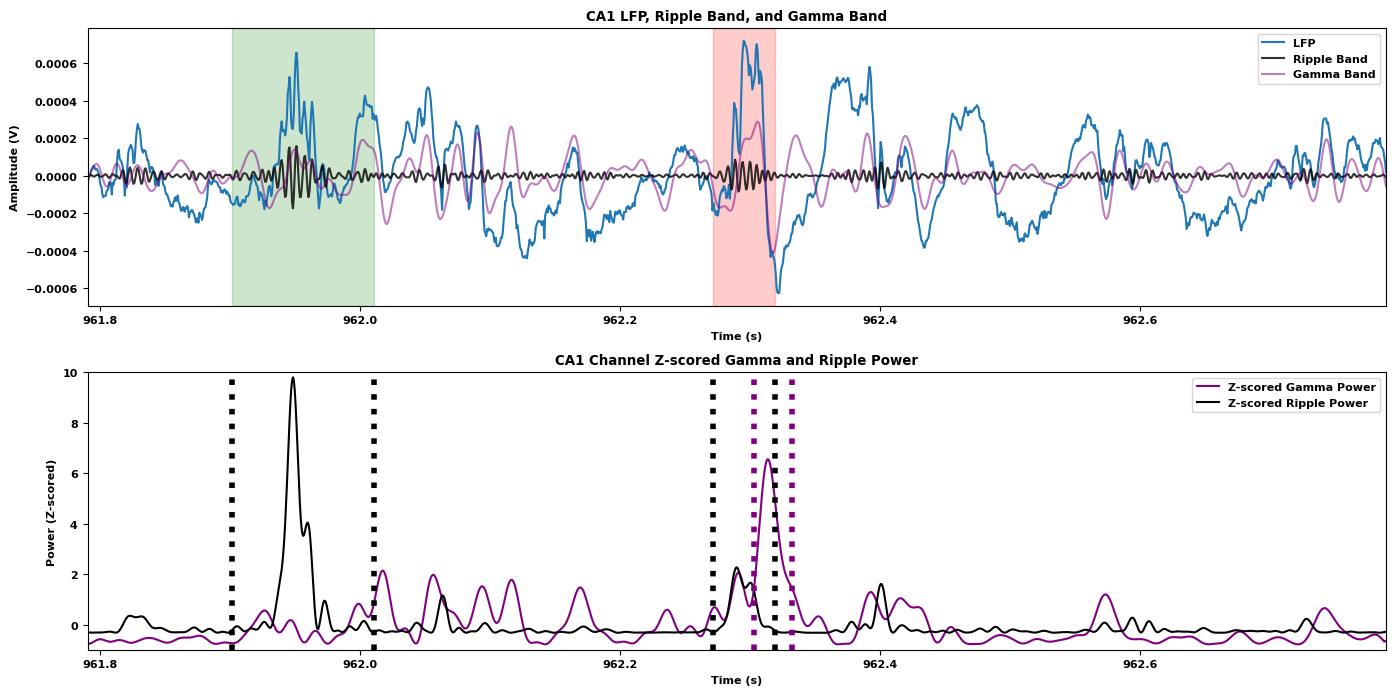

In [131]:
from scipy.stats import zscore

# Change the event number to pick a different ripple
rip_id = 145 
peaktime = swr_df.Peak_time[swr_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_lfp_data_slice = ca1_lfp_data[mask]
ca1_ripple_power_slice = ripple_band_ca1[mask]
zscored_ripple_power_ca1_slice = zscore(abs(signal.hilbert(ripple_band_ca1[mask])**2))  # Compute z-scored ripple band power
gamma_band_ca1_slice = gamma_band_ca1[mask]
zscored_gamma_power_ca1_slice = zscore(abs(signal.hilbert(gamma_band_ca1[mask])**2))  # Compute z-scored gamma band power
linethickness = 4

plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(time_arr_slice, ca1_lfp_data_slice, label='LFP')
plt.plot(time_arr_slice, ca1_ripple_power_slice, color='black', alpha=0.8, label='Ripple Band')  # Plot ripple band
plt.plot(time_arr_slice, gamma_band_ca1_slice, color='purple', alpha=0.5, label='Gamma Band')  # Plot gamma band

# Plot probe level events with shaded areas
for _, event in swr_df.iterrows():
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        if event.Overlaps_with_gamma:
            plt.axvspan(xmin=event.start_time, xmax=event.end_time, color='red', alpha=0.2)
        else:
            plt.axvspan(xmin=event.start_time, xmax=event.end_time, color='green', alpha=0.2)

plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.title('CA1 LFP, Ripple Band, and Gamma Band')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_arr_slice, zscored_gamma_power_ca1_slice, color='purple', alpha=1, label='Z-scored Gamma Power') 
plt.plot(time_arr_slice, zscored_ripple_power_ca1_slice, color='black', alpha=1, label='Z-scored Ripple Power')  # Plot z-scored ripple band power

for _, event in gamma_events_df.iterrows():
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='purple', linestyle='dotted', linewidth=linethickness)
    if event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.end_time, color='purple', linestyle='dotted', linewidth=linethickness)

# Plot probe level events with dotted black lines
for _, event in swr_df.iterrows():
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted', linewidth=linethickness)
    if event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.end_time, color='black', linestyle='dotted', linewidth=linethickness)

plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-1, 10)
plt.title('CA1 Channel Z-scored Gamma and Ripple Power') 
plt.xlabel('Time (s)')
plt.ylabel('Power (Z-scored)')
plt.legend()

plt.tight_layout()
plt.show()

In [163]:
# Compute gamma and ripple powers
ripple_band_ca1  = filter_ripple_band(ca1_lfp_data[:,None])
gamma_band_ca1 = np.convolve(ca1_lfp_data, gamma_filter, mode='same')
ripple_band_first_control = filter_ripple_band(first_control_lfp_data[:,None])
ripple_band_second_control = filter_ripple_band(second_control_lfp_data[:,None])

# Compute the y-limits
all_data = np.concatenate([ca1_lfp_data, ripple_band_ca1, ripple_band_first_control, ripple_band_second_control])
ylim = (np.min(all_data), np.max(all_data))

# Change the event number to pick a different ripple
rip_id = 4
peaktime = swr_df.Peak_time[swr_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_lfp_data_slice = ca1_lfp_data[mask]
ripple_band_ca1_slice = ripple_band_ca1[mask]
ripple_band_first_control_slice = ripple_band_first_control[mask]
ripple_band_second_control_slice = ripple_band_second_control[mask]

plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(time_arr_slice, ca1_lfp_data_slice)
plt.plot(time_arr_slice, ripple_band_ca1_slice, color='black', alpha=0.3)
plt.ylim(ylim)
plt.title('CA1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, ripple_band_first_control_slice)
plt.ylim(ylim)
plt.title('First Control Channel Ripple Band')
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')

plt.subplot(3, 1, 3)
plt.plot(time_arr_slice, ripple_band_second_control_slice)
plt.ylim(ylim)
plt.title('Second Control Channel Ripple Band') 
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')

plt.tight_layout()
plt.show()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [165]:
ripple_band_second_control.shape

(3841402, 1, 1)

In [119]:
movement_artifacts_df = swr_df[swr_df['Overlaps_with_movement']==True]
movement_artifacts_df

event_number   start_time     end_time  duration  mean_zscore  \
5                6    24.891259    25.043926  0.152667     3.417570   
6                7    27.915260    28.001927  0.086667     5.112275   
8                9    29.531260    29.614594  0.083333     4.780949   
10              11    33.489928    33.671261  0.181333     4.435122   
12              13    42.287929    42.374596  0.086667     4.616282   
...            ...          ...          ...       ...          ...   
1238          1262  5719.495046  5719.579046  0.084000     5.728331   
1243          1267  5741.560384  5741.685050  0.124667     3.105037   
1244          1268  5743.454384  5743.619717  0.165333     3.302031   
1252          1276  5793.797727  5793.943727  0.146000     5.049317   
1263          1287  5828.945734  5829.118401  0.172667     1.402432   

      median_zscore  max_zscore  min_zscore    Peak_time  Overlaps_with_gamma  \
5          3.417546    9.498352    0.020702    24.927926                False   
6          4.812867   11.436808    0.010822    27.940593                False   
8          3.193393   10.993112    0.029796    29.588594                 True   
10         1.270243   20.125757    0.021133    33.637928                False   
12         2.155750   16.034911    0.007459    42.325929                False   
...             ...         ...         ...          ...                  ...   
1238       5.443446   14.255823    0.013621  5719.526379                False   
1243       2.130232    7.878267    0.047218  5741.633050                False   
1244       2.622879    9.213437    0.001530  5743.530384                 True   
1252       1.915468   17.451548    0.022076  5793.895727                False   
1263       1.268951    3.229465    0.017117  5829.049734                False   

      Overlaps_with_movement  
5                       True  
6                       True  
8                       True  
10                      True  
12                      True  
...                      ...  
1238                    True  
1243                    True  
1244                    True  
1252                    True  
1263                    True  

[250 rows x 11 columns]

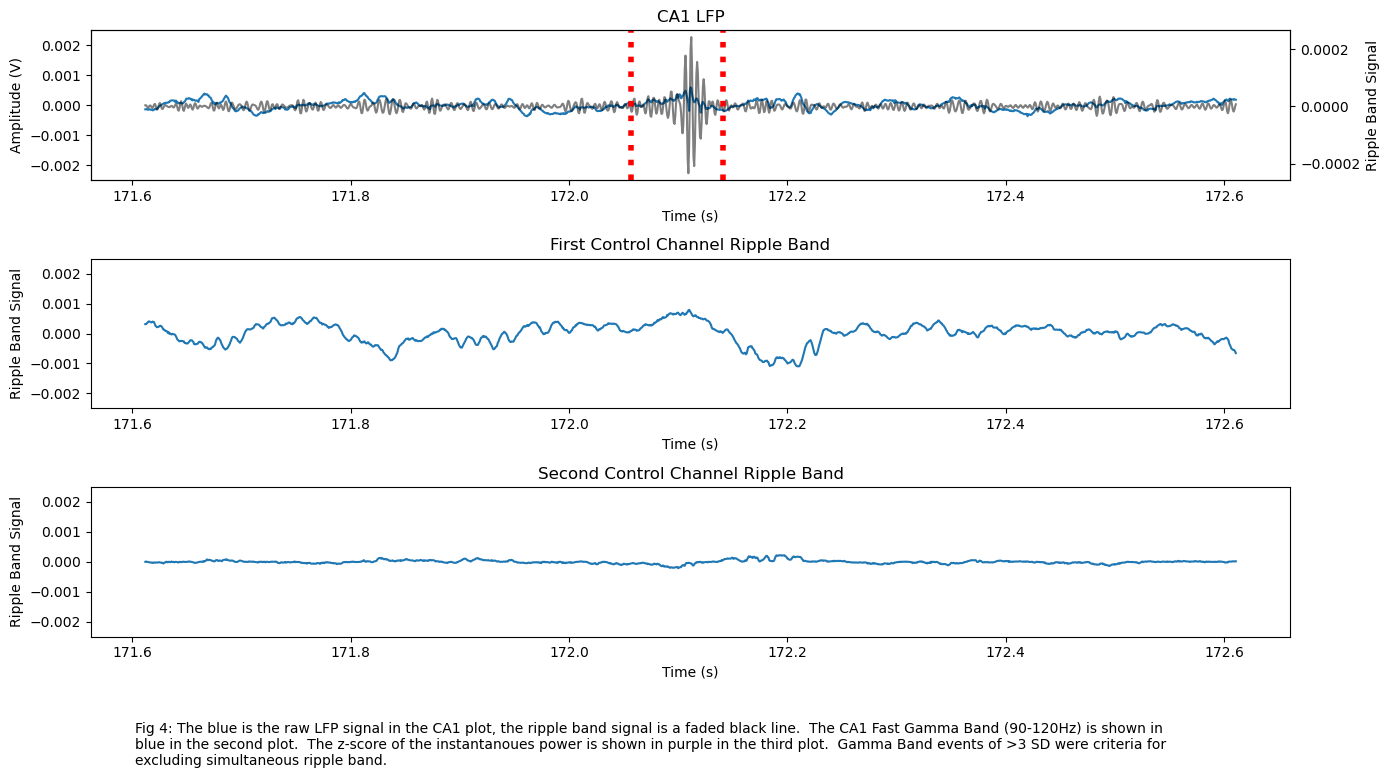

In [162]:
# Change the event number to pick a different ripple
rip_id = 29
peaktime = swr_df.Peak_time[swr_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_lfp_data_slice = ca1_lfp_data[mask]
ripple_band_ca1_slice = ripple_band_ca1[mask]
lfp_plot_lim = 0.0025
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_lfp_data_slice)
plt.ylim(-lfp_plot_lim, lfp_plot_lim)
plt.title('CA1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ripple_band_ca1_slice, color='black', alpha=0.5)  # Plot on the second y-axis with black color
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

# Add red dotted lines
rip_start_time = swr_df.start_time[swr_df.event_number == rip_id].values[0]
plt.axvline(x=rip_start_time, color='r', linestyle=':', linewidth=4)
rip_end_time = swr_df.end_time[swr_df.event_number == rip_id].values[0]
plt.axvline(x=rip_end_time, color='r', linestyle=':', linewidth=4)

plt.subplot(3, 1, 2)
#plt.plot(time_arr_slice, ripple_band_first_control[mask])
#plt.plot(time_arr_slice, np.squeeze(ripple_band_first_control[mask]))
plt.plot(time_arr_slice, first_control_lfp_data[mask])
plt.ylim(-lfp_plot_lim, lfp_plot_lim)
plt.title('First Control Channel Ripple Band')
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')

plt.subplot(3, 1, 3)

#plt.plot(time_arr_slice, ripple_band_second_control[mask], color='purple', alpha=0.5) 
#plt.plot(time_arr_slice, np.squeeze(ripple_band_second_control[mask]))
plt.plot(time_arr_slice, np.squeeze(second_control_lfp_data[mask]))
plt.ylim(-lfp_plot_lim, lfp_plot_lim)
plt.title('Second Control Channel Ripple Band') 
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')

# Add a figure legend (block of text) beneath the figure
plt.figtext(0.1, -0.1, "Fig 4: The blue is the raw LFP signal in the CA1 plot, the ripple band signal is a faded black line.  The CA1 Fast Gamma Band (90-120Hz) is shown in \nblue in the second plot.  The z-score of the instantanoues power is shown in purple in the third plot.  Gamma Band events of >3 SD were criteria for \nexcluding simultaneous ripple band.", ha="left")

plt.tight_layout()
plt.show()

In [ ]:
# Change the event number to pick a different ripple
rip_id = 10 
peaktime = probe0_filtered_events_df.Peak_time[probe0_filtered_events_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_channel_lfp_slice = ca1_channel_lfp[mask]
#ca1_ripple_power_slice = zscored_ripple_power_ca1[mask]
ca1_ripple_power_slice = ripple_band_ca1[mask]
fast_gamma_band_ca1_slice = fast_gamma_band_ca1[mask]
theta_band_ca1_slice = theta_band_ca1[mask]

# Assuming movementevents_1_lfp, movementevents_2_lfp, movementevents_3_lfp are your LFP data
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_channel_lfp_slice)
#plt.plot(time_arr_slice, ca1_ripple_power_slice)  # Add this line
plt.title('CA1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ca1_ripple_power_slice, color='black', alpha=0.5)  # Plot on the second y-axis with black color
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

# Add red dotted lines
rip_start_time = probe0_filtered_events_df.start_time[probe0_filtered_events_df.event_number == rip_id].values[0]
plt.axvline(x=rip_start_time, color='r', linestyle=':', linewidth=4)
rip_end_time = probe0_filtered_events_df.end_time[probe0_filtered_events_df.event_number == rip_id].values[0]
plt.axvline(x=rip_end_time, color='r', linestyle=':', linewidth=4)

plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, fast_gamma_band_ca1_slice)
plt.ylim(-0.001, 0.001)
plt.title('CA1 Channel Gamma Band')
plt.xlabel('Time (s)')
plt.ylabel('Fast Gamma Signal')

plt.subplot(3, 1, 3)

plt.plot(time_arr_slice, zscored_gamma_power_ca1[mask], color='purple', alpha=0.5) 
#plt.plot(time_arr_slice, ca1_ripple_power_slice)  # Add this line
plt.ylim(-1, 10)
plt.title('CA1 Channel Z-scored Gamma Power') 
plt.xlabel('Time (s)')
plt.ylabel('Ripple Power (Z-scored)')

# Add a figure legend (block of text) beneath the figure
plt.figtext(0.1, -0.1, "Fig 4: The blue is the raw LFP signal in the CA1 plot, the ripple band signal is a faded black line.  The CA1 Fast Gamma Band (90-120Hz) is shown in \nblue in the second plot.  The z-score of the instantanoues power is shown in purple in the third plot.  Gamma Band events of >3 SD were criteria for \nexcluding simultaneous ripple band.", ha="left")


plt.tight_layout()
plt.show()

In [56]:
# Change the event number to pick a different ripple
rip_id = 7
peaktime = probe0_filtered_events_df.Peak_time[probe0_filtered_events_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_channel_lfp_slice = ca1_channel_lfp[mask]
#ca1_ripple_power_slice = zscored_ripple_power_ca1[mask]
ca1_ripple_power_slice = ripple_band_ca1[mask]
fast_gamma_band_ca1_slice = fast_gamma_band_ca1[mask]
theta_band_ca1_slice = theta_band_ca1[mask]

# Assuming movementevents_1_lfp, movementevents_2_lfp, movementevents_3_lfp are your LFP data
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_channel_lfp_slice)
#plt.plot(time_arr_slice, ca1_ripple_power_slice)  # Add this line
plt.title('CA1 LFP (blue) and Ripple Band (black, 150-250 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ca1_ripple_power_slice, color='black', alpha=0.5)  # Plot on the second y-axis with black color
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

# Add red dotted lines
rip_start_time = probe0_filtered_events_df.start_time[probe0_filtered_events_df.event_number == rip_id].values[0]
plt.axvline(x=rip_start_time, color='r', linestyle=':', linewidth=4)
rip_end_time = probe0_filtered_events_df.end_time[probe0_filtered_events_df.event_number == rip_id].values[0]
plt.axvline(x=rip_end_time, color='r', linestyle=':', linewidth=4)

plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, fast_gamma_band_ca1_slice)
plt.ylim(-0.001, 0.001) 
plt.title('CA1 Channel Gamma Band (90-120 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Fast Gamma Signal')

plt.subplot(3, 1, 3)

plt.plot(time_arr_slice, zscored_gamma_power_ca1[mask], color='purple', alpha=0.5) 
#plt.plot(time_arr_slice, ca1_ripple_power_slice)  # Add this line
plt.title('CA1 Channel Z-scored Gamma Power')
plt.ylim(-1, 10) 
plt.xlabel('Time (s)')
plt.ylabel('Ripple Power (Z-scored)')

# Add a figure legend (block of text) beneath the figure
plt.figtext(0.1, -0.1, "Fig 5: The blue is the raw LFP signal in the CA1 plot, the ripple band signal is a faded black line.  The CA1 Fast Gamma Band (90-120Hz) is shown in \nblue in the second plot.  The z-score of the instantanoues power is shown in purple in the third plot.  Gamma Band events of >3 SD were criteria for \nexcluding simultaneous ripple band.", ha="left")


plt.tight_layout()
plt.show()

(8783708, 1)

In [ ]:
path_to_ripples = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024'
session_id = 'dd4da095-4a99-4bf3-9727-f735077dba66'
swr_folderpath = os.path.join(path_to_ripples, f'swrs_session_{session_id}')
lfp_folderpath = os.path.join(f"{path_to_ripples}_lfp_data", f'lfp_session_{session_id}')

filename = 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_karlsson_detector_events.csv'
probe0events_df = pd.read_csv(os.path.join(swr_folderpath, filename), compression='gzip')
probe0events_df.head(10)

controlchannel_1_filename = 'probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_254_movement_artifacts.csv'
movementevents_1_df = pd.read_csv(os.path.join(swr_folderpath, controlchannel_1_filename))
controlchannel_2_filename = 'probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_42_movement_artifacts.csv'
movementevents_2_df = pd.read_csv(os.path.join(swr_folderpath, controlchannel_2_filename))
# all these have been save at the 1500 hz sampling rate
ca1_channel_lfp = np.load(os.path.join(swr_folderpath,'probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_383_lfp_ca1_peakripplepower.npz'))
ca1_channel_lfp = ca1_channel_lfp['lfp_ca1']
movementevents_1_lfp = np.load(os.path.join(swr_folderpath,'probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_254_lfp_control_channel.npz'))
movementevents_1_lfp = movementevents_1_lfp['lfp_control_channel']
movementevents_2_lfp = np.load(os.path.join(swr_folderpath,'probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_42_lfp_control_channel.npz'))
movementevents_2_lfp = movementevents_2_lfp['lfp_control_channel']

# reshape them because numpy doesn't like 1d numpy arrays with shape (n,1) it wants (n,) trust me this step will save you pain later
ca1_channel_lfp = ca1_channel_lfp.reshape(-1)
print(ca1_channel_lfp.shape)
movementevents_1_lfp = movementevents_1_lfp.reshape(-1)
print(movementevents_1_lfp.shape)
movementevents_2_lfp = movementevents_2_lfp.reshape(-1)
print(movementevents_2_lfp.shape)

## Csd and Multitrace plot

In [38]:
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions

ba = AllenAtlas()
br = BrainRegions() # br is also an attribute of ba so could to br = ba.regions


In [39]:
# compute csd code
# try averaging between channels at the same depth, then providing that
# microns to microvolts means that microns can be in the same scale
def average_channels(electrode_data):
    """Calculate the average of every pair of even and odd channels"""
    nchan = electrode_data.shape[1]
    mask = np.full(nchan, False, dtype=bool)
    #print("mask length " + str(len(mask)))
    # Set True at even indices
    mask[::2] = True
    even_channels = electrode_data[:,mask]
    #print("even_channels shape" + str(even_channels.shape))
    odd_channels = electrode_data[:,~mask]  
    #print("odd_channels" + str(odd_channels.shape))
    # Calculate the average
    #averaged_data = np.average([even_channels, odd_channels_without_last], axis=0)

    averaged_data = (even_channels+odd_channels)/2

    return averaged_data
    
def butterworth_filter_for_csd(LFP_array, lowcut = 1.0, highcut = 250.0,
                    samplingfreq = 2500.0, order = 6):

    nyquist = 0.5 * samplingfreq
    # Design the Butterworth bandpass filter
    # Design the Butterworth bandpass filter
    b, a = signal.butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')

    # Apply the filter to all channels simultaneously using vectorized operations
    filtered_signal = signal.lfilter(b, a, LFP_array, axis=0)
    return(filtered_signal)

# Assuming you have your signal_array, b, and a defined as before
def finitimpresp_filter_for_csd(LFP_array, lowcut = 1, highcut = 250,
                    samplingfreq = 2500, filter_order =101):

    nyquist = 0.5 * samplingfreq

    # Design the FIR bandpass filter using scipy.signal.firwin
    fir_coeff = signal.firwin(filter_order, [lowcut / nyquist, highcut / nyquist],
                                pass_zero=False, fs=samplingfreq)

    # Apply the FIR filter to your signal_array
    #filtered_signal = signal.convolve(LFP_array, fir_coeff, mode='same', method='auto')
    filtered_signal = signal.lfilter(fir_coeff, 1.0, LFP_array, axis=0)
    
    return(filtered_signal)

def compute_csd(lfp_data, spacing_between_channels, chan_rows):
    """
    Compute Current Source Density (CSD) from Local Field Potential (LFP) data.

    Parameters:
        lfp_data (numpy.ndarray): 2D array of LFP data, shape (n_channels, n_samples).
        spacing_between_channels (float): Distance (in micrometers) between adjacent channels.
        chan_rows list of int :  the index on the 2d dimension of lfp data for which channels are to be included

    Returns:
        csd_data (numpy.ndarray): 2D array of CSD data, shape (n_channels, n_samples).
    """
    # Ensure the input LFP data is a NumPy array
    lfp_data = np.array(lfp_data)
    lfp_data = lfp_data[:,chan_rows]

    lfp_data = finitimpresp_filter_for_csd(lfp_data)
    lfp_data = average_channels(lfp_data)

    # Get the number of channels and samples
    n_channels, n_samples = lfp_data.shape

    # Define the finite difference coefficients for second spatial derivative
    fd_coefficients = np.array([1, -2, 1]) / spacing_between_channels**2

    # Function to compute CSD for a single channel
    def compute_csd_single_channel(channel_data):
        return np.convolve(channel_data, fd_coefficients, mode='same')

    # Apply the second spatial derivative to each channel using apply_along_axis
    csd_data = np.apply_along_axis(compute_csd_single_channel, axis=0, arr=lfp_data)

    return csd_data


def exponential_smoothing_2d(data, alpha, axis):
    """
    Apply exponential smoothing to a 2D NumPy array along the specified axis.

    Parameters:
    - data: Input 2D NumPy array
    - alpha: Smoothing parameter (0 < alpha < 1)
    - axis: Axis along which to apply exponential smoothing (0 for rows, 1 for columns)

    Returns:
    - smoothed_data: Exponentially smoothed array
    """

    if axis not in (0, 1):
        raise ValueError("Axis must be 0 (rows) or 1 (columns).")

    smoothed_data = np.copy(data)

    if axis == 0:
        for i in range(data.shape[1]):
            smoothed_data[:, i] = exponential_smoothing(data[:, i], alpha)
    elif axis == 1:
        for i in range(data.shape[0]):
            smoothed_data[i, :] = exponential_smoothing(data[i, :], alpha)

    return smoothed_data

def exponential_smoothing(series, alpha):
    """
    Apply exponential smoothing to a 1D NumPy array.

    Parameters:
    - series: Input 1D NumPy array
    - alpha: Smoothing parameter (0 < alpha < 1)

    Returns:
    - smoothed_series: Exponentially smoothed array
    """

    smoothed_series = np.zeros_like(series)
    smoothed_series[0] = series[0]

    for t in range(1, len(series)):
        smoothed_series[t] = alpha * series[t] + (1 - alpha) * smoothed_series[t - 1]

    return smoothed_series

In [40]:
# pick a session based on largest ripple at lowest running speed
# and the peak probe it's on
# Convert speeds list to a pandas Series

speeds_series = pd.Series(speeds, name='speeds')

# Convert theta_data dict to a DataFrame
theta_df = pd.DataFrame(theta_powers)

# Reset the index of theta_df and test
theta_df = theta_df.reset_index(drop=True)

# Add speeds_series to all_swrs_df and reset index
all_swrs_df = all_swrs_df.assign(speeds=speeds_series)
all_swrs_df = all_swrs_df.reset_index(drop=True)

# Concatenate test and theta_df
all_swrs_df = pd.concat([all_swrs_df, theta_df], axis=1)


In [41]:
all_swrs_df.columns

Index(['start_time', 'end_time', 'probes_event_is_on', 'events_row_index',
       'global_peak_time', 'global_max_zscore', 'peak_probe', 'duration',
       'session_id', 'speeds', 'peakwindow_med', 'peakwindow_mean',
       'eventwindow_med', 'eventwindow_mean'],
      dtype='object')

In [42]:
# Sort by global_max_zscore in descending order
sorted_df = all_swrs_df

# Add quantile columns to sorted_df
sorted_df['speeds_quantile'] = pd.qcut(sorted_df['speeds'], q=4, labels=False)
sorted_df['peakwindow_mean_quantile'] = pd.qcut(sorted_df['peakwindow_mean'], q=4, labels=False)

# Filter sorted_df to only include rows in the lowest quantiles of speeds and peakwindow_mean
lowest_quantiles_df = sorted_df[(sorted_df['speeds_quantile'] == 0) & (sorted_df['peakwindow_mean_quantile'] == 0)]
lowest_quantiles_df = lowest_quantiles_df.sort_values(by='global_max_zscore', ascending=False)



In [43]:
# Initialize a dictionary to store the counts
probe_counts = {}

# Iterate over the first 100 rows of the DataFrame
for _, row in lowest_quantiles_df.head(100).iterrows():
    probe_id = row['peak_probe']
    session_id = row['session_id']
    
    probes_list, probenames = one.eid2pid(session_id)
    probes_list = np.array(probes_list)
    probenames = np.array(probenames)
    
    probe_name = probenames[probes_list == probe_id]
    if probe_name.size > 0:
        probe_name = probe_name[0]
        collectionname = f'alf/{probe_name}/pykilosort'
        
        # Load the channels
        channels = one.load_object(session_id, 'channels', collection=collectionname)
        channels.allen2017_25um_acronym = br.id2acronym(channels['brainLocationIds_ccf_2017'])
        
        # Count the number of ca1 channels
        ca1_count = np.sum(channels['allen2017_25um_acronym'] == 'CA1')
        
        # Update the count for this probe
        if probe_id in probe_counts:
            probe_counts[probe_id] = (probe_counts[probe_id][0] + ca1_count, session_id)
        else:
            probe_counts[probe_id] = (ca1_count, session_id)

# Find the probe with the most number of ca1 channels
max_probe = max(probe_counts, key=lambda x: probe_counts[x][0])

print(f'The probe with the most number of CA1 channels is: {max_probe} from session: {probe_counts[max_probe][1]}')

The probe with the most number of CA1 channels is: 30ac1320-d671-46fc-87ef-875cdfc6b4eb from session: edd22318-216c-44ff-bc24-49ce8be78374


In [44]:
# Initialize a dictionary to store the counts and scores
probe_counts_scores = {}

# Iterate over the first 100 rows of the DataFrame
for _, row in lowest_quantiles_df.head(100).iterrows():
    probe_id = row['peak_probe']
    session_id = row['session_id']
    global_max_zscore = row['global_max_zscore']
    
    probes_list, probenames = one.eid2pid(session_id)
    probes_list = np.array(probes_list)
    probenames = np.array(probenames)
    
    probe_name = probenames[probes_list == probe_id]
    if probe_name.size > 0:
        probe_name = probe_name[0]
        collectionname = f'alf/{probe_name}/pykilosort'
        
        # Load the channels
        channels = one.load_object(session_id, 'channels', collection=collectionname)
        channels.allen2017_25um_acronym = br.id2acronym(channels['brainLocationIds_ccf_2017'])
        
        # Count the number of ca1 channels
        ca1_count = np.sum(channels['allen2017_25um_acronym'] == 'CA1')
        
        # Update the count and score for this probe
        if probe_id in probe_counts_scores:
            probe_counts_scores[probe_id].append((ca1_count, global_max_zscore, row))
        else:
            probe_counts_scores[probe_id] = [(ca1_count, global_max_zscore, row)]

# Find the probe with the most number of ca1 channels and highest global_max_zscore
max_probe = max(probe_counts_scores, key=lambda x: max(probe_counts_scores[x], key=lambda y: (y[0], y[1])))

# Get the row with the most number of CA1 channels and highest global_max_zscore
desired_event = max(probe_counts_scores[max_probe], key=lambda x: (x[0], x[1]))[2]

print(f'The desired event is from probe: {desired_event.peak_probe} and session: {desired_event.session_id}')

The desired event is from probe: c0c3c95d-43c3-4e30-9ce7-0519d0473911 and session: 6c6983ef-7383-4989-9183-32b1a300d17a


In [45]:
desired_event

start_time                                               2365.970383
end_time                                                  2366.02705
probes_event_is_on          ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']
events_row_index                                               [698]
global_peak_time                                          2366.00305
global_max_zscore                                          10.500141
peak_probe                      c0c3c95d-43c3-4e30-9ce7-0519d0473911
duration                                                    0.056667
session_id                      6c6983ef-7383-4989-9183-32b1a300d17a
speeds                                                      0.000089
peakwindow_med                                             -0.283098
peakwindow_mean                                            -0.265395
eventwindow_med                                            -0.312397
eventwindow_mean                                           -0.310109
speeds_quantile                   

In [46]:
from pathlib import Path
import ibllib
print(ibllib.__version__)
print(ibllib.__file__)

import brainbox
print(brainbox.__file__)


assert Path(*Path(brainbox.__file__).parts[:-2]) == Path(*Path(ibllib.__file__).parts[:-2]),\
    'oops it seems brainbox and ibllib are not in the same package'

2.35.2
/home/acampbell/miniconda3/envs/ONE_ibl_env/lib/python3.10/site-packages/ibllib/__init__.py
/home/acampbell/miniconda3/envs/ONE_ibl_env/lib/python3.10/site-packages/brainbox/__init__.py


In [47]:
lowest_quantiles_df.head()

start_time     end_time                        probes_event_is_on  \
2718  4377.797483  4377.919483  ['30ac1320-d671-46fc-87ef-875cdfc6b4eb']   
759   4126.981436  4127.209437  ['e31b4e39-e350-47a9-aca4-72496d99ff2a']   
2481  3459.123970  3459.215970  ['30ac1320-d671-46fc-87ef-875cdfc6b4eb']   
635   3421.639965  3421.839965  ['e31b4e39-e350-47a9-aca4-72496d99ff2a']   
2926  5198.431644  5198.562977  ['30ac1320-d671-46fc-87ef-875cdfc6b4eb']   

     events_row_index  global_peak_time  global_max_zscore  \
2718            [734]       4377.878817          35.475916   
759             [536]       4127.143437          26.754735   
2481            [487]       3459.175304          26.124183   
635             [408]       3421.731965          25.033728   
2926            [945]       5198.465644          24.769245   

                                peak_probe  duration  \
2718  30ac1320-d671-46fc-87ef-875cdfc6b4eb  0.122000   
759   e31b4e39-e350-47a9-aca4-72496d99ff2a  0.228000   
2481  30ac1320-d671-46fc-87ef-875cdfc6b4eb  0.092000   
635   e31b4e39-e350-47a9-aca4-72496d99ff2a  0.200000   
2926  30ac1320-d671-46fc-87ef-875cdfc6b4eb  0.131333   

                                session_id    speeds  peakwindow_med  \
2718  edd22318-216c-44ff-bc24-49ce8be78374  0.000100       -0.129969   
759   746d1902-fa59-4cab-b0aa-013be36060d5  0.000061       -0.493216   
2481  edd22318-216c-44ff-bc24-49ce8be78374  0.000064       -0.640589   
635   746d1902-fa59-4cab-b0aa-013be36060d5  0.000127       -0.668576   
2926  edd22318-216c-44ff-bc24-49ce8be78374  0.000105       -0.382231   

      peakwindow_mean  eventwindow_med  eventwindow_mean  speeds_quantile  \
2718        -0.092238         0.093098          0.055351              0.0   
759         -0.329967        -0.670814         -0.662977              0.0   
2481        -0.638754        -0.622595         -0.626612              0.0   
635         -0.572232        -0.260023         -0.339748              0.0   
2926        -0.410565        -0.536941         -0.534441              0.0   

      peakwindow_mean_quantile  
2718                       0.0  
759                        0.0  
2481                       0.0  
635                        0.0  
2926                       0.0

In [48]:
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions

ba = AllenAtlas()
br = BrainRegions() # br is also an attribute of ba so could to br = ba.regions

# loading the lfp
probe_id = desired_event.peak_probe
session_id = desired_event.session_id

probe_id = desired_event.peak_probe
session_id = desired_event.session_id

probes_list, probenames = one.eid2pid(session_id) # probe_id is pid in the IBL tutorials
probes_list = np.array(probes_list)
probenames = np.array(probenames)
probe_name = probenames[probes_list == probe_id]
probe_name = probe_name[0]


del probes_list
del probenames
collectionname = f'alf/{probe_name}/pykilosort' # ensures channels are all from this probe
channels = one.load_object(session_id, 'channels', collection=collectionname)
channels.allen2017_25um_acronym = br.id2acronym( channels['brainLocationIds_ccf_2017'] )

regions_on_probe = np.unique(channels.allen2017_25um_acronym)

# Find the relevant datasets and download them
dsets = one.list_datasets(session_id, collection=f'raw_ephys_data/{probe_name}', filename='*.lf.*')
data_files, _ = one.load_datasets(session_id, dsets, download_only=False)
bin_file = next(df for df in data_files if df.suffix == '.cbin')

# Use spikeglx reader to read in the whole raw data
sr = spikeglx.Reader(bin_file)
ssl = SpikeSortingLoader(pid=probe_id, one=one)
t0 = ssl.samples2times(0, direction='forward') # get the time of the first sample
dt = (ssl.samples2times(1, direction='forward') - t0)*12 # get the time difference between samples at 2500Hz
lfp_time_index_og = np.arange(0, sr.shape[0])*dt + t0
# make time index
ssl = SpikeSortingLoader(pid=probe_id, one=one)
del ssl 
raw = sr[:, :-sr.nsync].T
fs_from_sr = sr.fs
del sr

destriped = destripe_lfp(raw, fs=fs_from_sr)
del raw

100%|██████████| 10/10.0 [00:03<00:00,  2.80it/s]


In [49]:
desired_events_from_this_probe = lowest_quantiles_df[lowest_quantiles_df['probes_event_is_on']== desired_event.probes_event_is_on]
desired_events_from_this_probe.head(20)

start_time     end_time                        probes_event_is_on  \
3627  2365.970383  2366.027050  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3419  1219.074198  1219.126198  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3808  3038.089158  3038.135825  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3834  3177.580514  3177.746514  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3450  1419.832230  1419.883564  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3853  3208.905186  3208.954519  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3321   864.683474   864.760141  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3931  3447.591891  3447.629225  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3654  2503.411072  2503.465739  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3376  1022.153500  1022.232833  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3724  2778.624450  2778.668450  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3707  2722.680441  2722.710441  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3098    99.962017   100.028684  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3363   984.182827   984.212160  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3234   304.500050   304.580717  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3660  2521.974408  2522.154408  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3076    79.312014    79.358681  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3796  2993.720485  2993.794485  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3391  1074.187508  1074.225508  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3859  3226.762522  3226.893189  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   

     events_row_index  global_peak_time  global_max_zscore  \
3627            [698]       2366.003050          10.500141   
3419            [487]       1219.094865           7.905847   
3808            [883]       3038.113158           7.566051   
3834            [909]       3177.652514           7.537147   
3450            [518]       1419.844230           7.159651   
3853            [928]       3208.925853           6.482301   
3321            [387]        864.747474           6.024601   
3931           [1007]       3447.610558           5.934960   
3654            [726]       2503.446405           5.930762   
3376            [443]       1022.198833           5.850363   
3724            [797]       2778.655117           5.733440   
3707            [780]       2722.699774           5.548155   
3098            [155]        100.013351           5.406207   
3363            [430]        984.194160           5.157613   
3234            [299]        304.527384           5.075495   
3660            [732]       2522.107742           4.932736   
3076            [130]         79.340681           4.925971   
3796            [871]       2993.765818           4.918047   
3391            [458]       1074.204841           4.907997   
3859            [934]       3226.852522           4.891588   

                                peak_probe  duration  \
3627  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.056667   
3419  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.052000   
3808  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.046667   
3834  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.166000   
3450  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.051333   
3853  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.049333   
3321  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.076667   
3931  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.037333   
3654  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.054667   
3376  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.079333   
3724  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.044000   
3707  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.030000   
3098  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.066667   
3363  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.029333   
3234  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.080667   
3660  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.180000   
3076  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.046667   
3796  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.074000   
3391  c0c3c95d-43c3-4e30-9ce7-0519d0473911 

In [50]:
desired_event = desired_events_from_this_probe.iloc[4]

In [51]:
desired_event['start_time'], desired_event['end_time']

(1419.8322304061708, 1419.8835637477946)

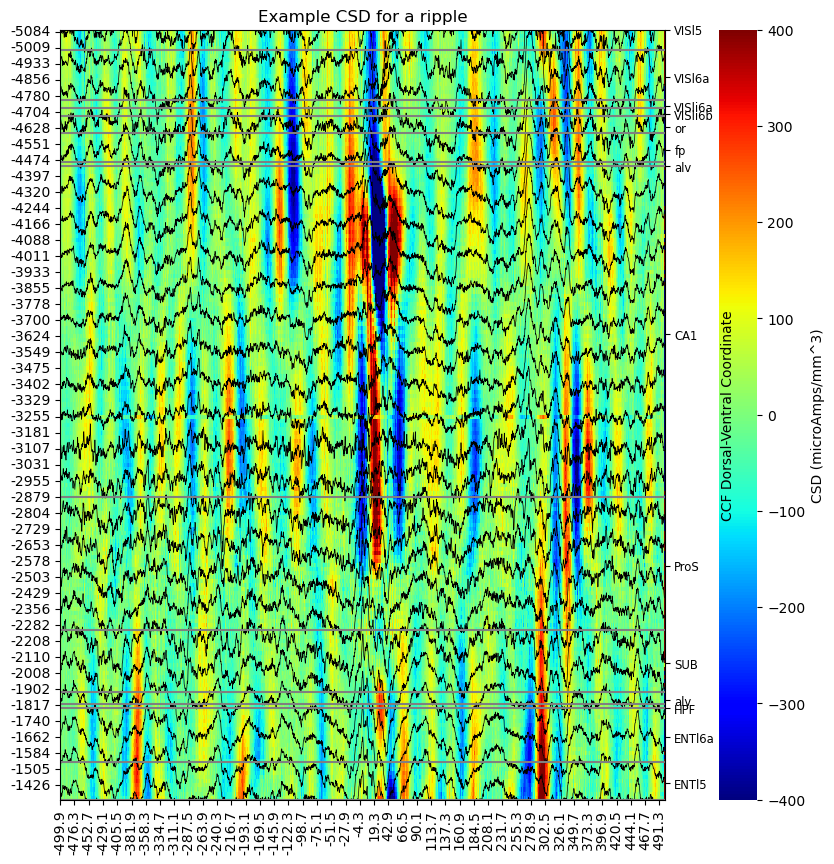

In [171]:
offset = 0.5
event_mask = (lfp_time_index_og >= (desired_event.global_peak_time-offset)) & (lfp_time_index_og <= (desired_event.global_peak_time+offset))

lfp_slice = destriped[:,event_mask]
time_slice = lfp_time_index_og[event_mask]

lfp_slice = lfp_slice * 1000000
current_sink_this_rip = compute_csd(lfp_slice.T, spacing_between_channels=20, chan_rows =channels['rawInd'])
#time (x) in miliseconds from middle of ripple envelope, should move to using ripple peak time
rippeaktime = desired_event.global_peak_time
time_ripple_centered_ms = time_slice - desired_event.global_peak_time
time_ripple_centered_ms = time_ripple_centered_ms*1000
time_ripple_centered_ms = [round(x, 1) for x in time_ripple_centered_ms]

# plotting
scaled_filtered_smoothed_csd = np.transpose(current_sink_this_rip)
# so it's orientated from cortical surface
scaled_filtered_smoothed_csd = np.flip(scaled_filtered_smoothed_csd, axis=0) 
sig = scaled_filtered_smoothed_csd.shape[1] / 10.0  # Proportional to the size of the array
# Apply Gaussian smoothing
#scaled_filtered_smoothed_csd = gaussian_filter(scaled_filtered_smoothed_csd, sigma=1)
#scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1) # smoothed only along time
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>0.03] = 0.03
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-0.03] = -0.03

scaled_filtered_smoothed_csd *= 1000000
#scaled_filtered_smoothed_csd = exponential_smoothing_2d(scaled_filtered_smoothed_csd, alpha=0.5, axis=1)
scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1)
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>400] = 400
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-400] = -400

#depth (y)
ccf_dorsal_ventral = channels['mlapdv'][:,2]
allen_ontology_annot_og = channels['allen2017_25um_acronym']
mask = np.full(current_sink_this_rip.shape[1]*2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
#ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot_og[mask] 
#allen_ontology_annot = np.flip(allen_ontology_annot)
#allen_ontology_annot = allen_ontology_annot.to_numpy()

# y axis subsampling for plotting purposes
ylen = scaled_filtered_smoothed_csd.shape[0]
y_tick_positions = np.linspace(0, ylen - 1, int(ylen/10), dtype=int)
xlen = scaled_filtered_smoothed_csd.shape[1]
x_tick_positions = np.linspace(0, xlen - 1, int(xlen/10), dtype=int)


plt.figure(figsize=(10*offset*2, 10))
scaled_filtered_smoothed_csd = pd.DataFrame(scaled_filtered_smoothed_csd)
scaled_filtered_smoothed_csd.index = ccf_dorsal_ventral
scaled_filtered_smoothed_csd.columns = time_ripple_centered_ms

# Add your heatmap code here
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f", cmap="jet") #"Spectral_r" or "vlag" # RdYlBu_r


# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Downsample the traces further by taking one in every nth probe
nth_probe = 8
trace_arr = lfp_slice[1::nth_probe]  

# Calculate the standard deviation of the whole lfp_slice array
std_dev = np.std(lfp_slice)

# Compute the median for each row in the DataFrame
trace_medians = np.median(trace_arr, axis=1)

for i, trace in enumerate(trace_arr):
    
    # Subtract the median from the trace
    trace = trace - trace_medians[i]
    
    # Normalize the trace so that a value of the standard deviation of the whole lfp_slice array occupies half of the total space allotted to the trace
    trace = trace / (2 * std_dev)

    # Rescale the trace to fit within its allotted space on the y-axis
    trace = trace * nth_probe

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = trace + i * nth_probe  # multiply by nth_probe to match the original channel position

    plt.plot(range(len(trace)), trace, color='black', linewidth=0.5)

# Calculate the midpoints of each stretch of the same label and the labels for these midpoints
midpoints = []
labels = []
start = 0
for i in range(1, len(allen_ontology_annot)):
    if allen_ontology_annot[i] != allen_ontology_annot[i - 1]:
        midpoints.append((start + i - 1) / 2)
        labels.append(allen_ontology_annot[start])
        start = i
midpoints.append((start + len(allen_ontology_annot) - 1) / 2)
labels.append(allen_ontology_annot[start])

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(midpoints)
ax2.set_yticklabels(labels, fontsize='small')

# Find the indices where the label changes
change_indices = np.where(np.roll(allen_ontology_annot, 1) != allen_ontology_annot)[0]

# Draw horizontal lines at these indices
for idx in change_indices:
    plt.axhline(y=idx, color='grey')

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

/tmp/ipykernel_46392/1626122828.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  heatmap.set_xticklabels(x_labels, fontsize=10)


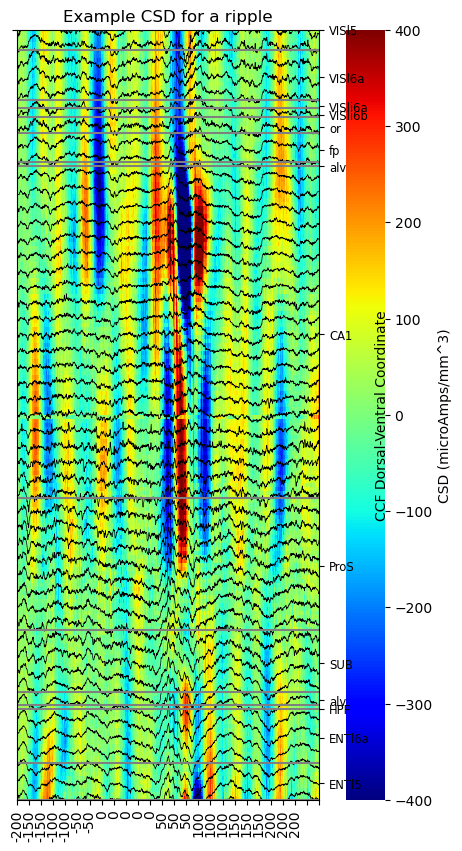

In [172]:
from matplotlib.ticker import MultipleLocator

offset = 0.25
event_mask = (lfp_time_index_og >= (desired_event.global_peak_time-offset)) & (lfp_time_index_og <= (desired_event.global_peak_time+offset))

lfp_slice = destriped[:,event_mask]
time_slice = lfp_time_index_og[event_mask]

lfp_slice = lfp_slice * 1000000
current_sink_this_rip = compute_csd(lfp_slice.T, spacing_between_channels=20, chan_rows =channels['rawInd'])
#time (x) in miliseconds from middle of ripple envelope, should move to using ripple peak time
rippeaktime = desired_event.global_peak_time
time_ripple_centered_ms = time_slice - desired_event.global_peak_time
time_ripple_centered_ms = time_ripple_centered_ms*1000
time_ripple_centered_ms = [round(x, 1) for x in time_ripple_centered_ms]

# plotting
scaled_filtered_smoothed_csd = np.transpose(current_sink_this_rip)
# so it's orientated from cortical surface
scaled_filtered_smoothed_csd = np.flip(scaled_filtered_smoothed_csd, axis=0) 
sig = scaled_filtered_smoothed_csd.shape[1] / 10.0  # Proportional to the size of the array
# Apply Gaussian smoothing
#scaled_filtered_smoothed_csd = gaussian_filter(scaled_filtered_smoothed_csd, sigma=1)
#scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1) # smoothed only along time
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>0.03] = 0.03
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-0.03] = -0.03

scaled_filtered_smoothed_csd *= 1000000
#scaled_filtered_smoothed_csd = exponential_smoothing_2d(scaled_filtered_smoothed_csd, alpha=0.5, axis=1)
scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1)
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>400] = 400
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-400] = -400

#depth (y)
ccf_dorsal_ventral = channels['mlapdv'][:,2]
allen_ontology_annot_og = channels['allen2017_25um_acronym']
mask = np.full(current_sink_this_rip.shape[1]*2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
#ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot_og[mask] 
#allen_ontology_annot = np.flip(allen_ontology_annot)
#allen_ontology_annot = allen_ontology_annot.to_numpy()

# y axis subsampling for plotting purposes
ylen = scaled_filtered_smoothed_csd.shape[0]
y_tick_positions = np.linspace(0, ylen - 1, int(ylen/10), dtype=int)
xlen = scaled_filtered_smoothed_csd.shape[1]
x_tick_positions = np.linspace(0, xlen - 1, int(xlen/10), dtype=int)


plt.figure(figsize=(10*offset*2, 10))
scaled_filtered_smoothed_csd = pd.DataFrame(scaled_filtered_smoothed_csd)
scaled_filtered_smoothed_csd.index = ccf_dorsal_ventral
scaled_filtered_smoothed_csd.columns = time_ripple_centered_ms

# Add your heatmap code here
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f", cmap="jet") #"Spectral_r" or "vlag" # RdYlBu_r


# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Downsample the traces further by taking one in every nth probe
nth_probe = 4
trace_arr = lfp_slice[1::nth_probe]  

# Calculate the standard deviation of the whole lfp_slice array
std_dev = np.std(lfp_slice)

# Compute the median for each row in the DataFrame
trace_medians = np.median(trace_arr, axis=1)

for i, trace in enumerate(trace_arr):
    
    # Subtract the median from the trace
    trace = trace - trace_medians[i]
    
    # Normalize the trace so that a value of the standard deviation of the whole lfp_slice array occupies half of the total space allotted to the trace
    trace = trace / (2 * std_dev)

    # Rescale the trace to fit within its allotted space on the y-axis
    trace = trace * nth_probe

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = trace + i * nth_probe  # multiply by nth_probe to match the original channel position

    plt.plot(range(len(trace)), trace, color='black', linewidth=0.5)

# Calculate the midpoints of each stretch of the same label and the labels for these midpoints
midpoints = []
labels = []
start = 0
for i in range(1, len(allen_ontology_annot)):
    if allen_ontology_annot[i] != allen_ontology_annot[i - 1]:
        midpoints.append((start + i - 1) / 2)
        labels.append(allen_ontology_annot[start])
        start = i
midpoints.append((start + len(allen_ontology_annot) - 1) / 2)
labels.append(allen_ontology_annot[start])

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(midpoints)
ax2.set_yticklabels(labels, fontsize='small')

# Set x and y axis to display only multiples of 50 and 500 respectively
heatmap.xaxis.set_major_locator(MultipleLocator(50))
heatmap.yaxis.set_major_locator(MultipleLocator(500))

# Format the tick labels to display as integers
heatmap.xaxis.set_major_formatter('{x:.0f}')
heatmap.yaxis.set_major_formatter('{x:.0f}')

# Create separate lists of integer values for the index and columns
ccf_dorsal_ventral_int = [int(x) for x in ccf_dorsal_ventral]
time_ripple_centered_ms_int = [int(x) for x in time_ripple_centered_ms]

# Convert DataFrame's index and columns to multiples of 500 and 50 respectively
y_labels = [y_label for y_label in ccf_dorsal_ventral_int if y_label % 500 == 0]
x_labels = [x_label for x_label in time_ripple_centered_ms_int if x_label % 50 == 0]

# Convert y_labels and x_labels to strings for setting tick labels
y_labels = [str(y) for y in y_labels]
x_labels = [str(x) for x in x_labels]

# Set labels for the ticks on the x and y axes
heatmap.set_xticklabels(x_labels, fontsize=10)
heatmap.set_yticklabels(y_labels, fontsize=10)

# Find the indices where the label changes
change_indices = np.where(np.roll(allen_ontology_annot, 1) != allen_ontology_annot)[0]

# Draw horizontal lines at these indices
for idx in change_indices:
    plt.axhline(y=idx, color='grey')

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

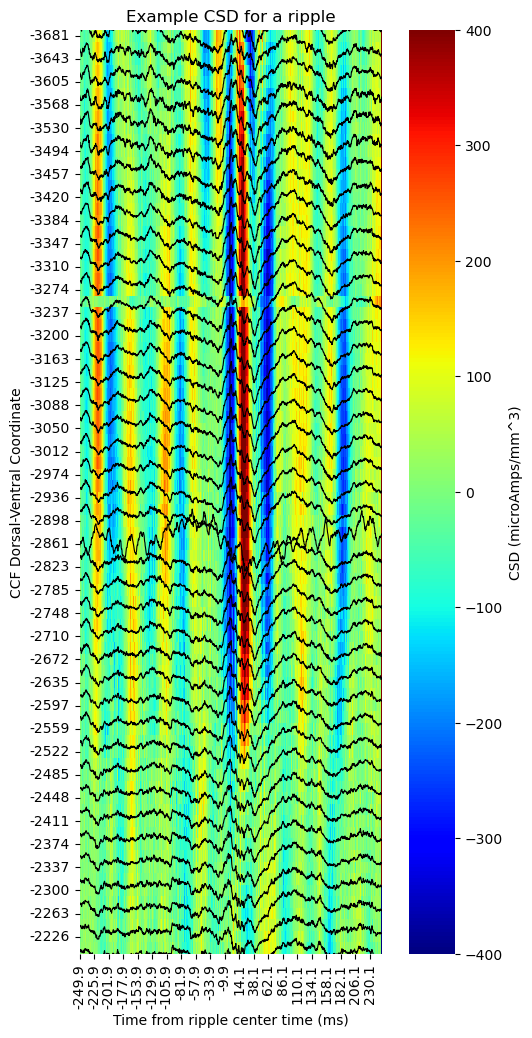

In [176]:
# JUST WITH CA1 PROBES
offset = 0.25
event_mask = (lfp_time_index_og >= (desired_event.global_peak_time-offset)) & (lfp_time_index_og <= (desired_event.global_peak_time+offset))

lfp_slice = destriped[:,event_mask]
time_slice = lfp_time_index_og[event_mask]

lfp_slice = lfp_slice * 1000000
current_sink_this_rip = compute_csd(lfp_slice.T, spacing_between_channels=20, chan_rows =channels['rawInd'])
#time (x) in miliseconds from middle of ripple envelope, should move to using ripple peak time
rippeaktime = desired_event.global_peak_time
time_ripple_centered_ms = time_slice - desired_event.global_peak_time
time_ripple_centered_ms = time_ripple_centered_ms*1000
time_ripple_centered_ms = [round(x, 1) for x in time_ripple_centered_ms]

# plotting
scaled_filtered_smoothed_csd = np.transpose(current_sink_this_rip)
# so it's orientated from cortical surface
scaled_filtered_smoothed_csd = np.flip(scaled_filtered_smoothed_csd, axis=0) 
sig = scaled_filtered_smoothed_csd.shape[1] / 10.0  # Proportional to the size of the array
# Apply Gaussian smoothing
#scaled_filtered_smoothed_csd = gaussian_filter(scaled_filtered_smoothed_csd, sigma=1)
#scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1) # smoothed only along time
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>0.03] = 0.03
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-0.03] = -0.03

scaled_filtered_smoothed_csd *= 1000000
#scaled_filtered_smoothed_csd = exponential_smoothing_2d(scaled_filtered_smoothed_csd, alpha=0.5, axis=1)
scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1)
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>400] = 400
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-400] = -400

#depth (y)
ccf_dorsal_ventral = channels['mlapdv'][:,2]
allen_ontology_annot_og = channels['allen2017_25um_acronym']
mask = np.full(current_sink_this_rip.shape[1]*2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
#ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot_og[mask] 
#allen_ontology_annot = np.flip(allen_ontology_annot)
#allen_ontology_annot = allen_ontology_annot.to_numpy()

# y axis subsampling for plotting purposes
ylen = scaled_filtered_smoothed_csd.shape[0]
y_tick_positions = np.linspace(0, ylen - 1, int(ylen/10), dtype=int)
xlen = scaled_filtered_smoothed_csd.shape[1]
x_tick_positions = np.linspace(0, xlen - 1, int(xlen/10), dtype=int)



plt.figure(figsize=(10*offset*2, 12))
scaled_filtered_smoothed_csd = pd.DataFrame(scaled_filtered_smoothed_csd)
scaled_filtered_smoothed_csd.index = ccf_dorsal_ventral
scaled_filtered_smoothed_csd.columns = time_ripple_centered_ms


# Filter rows where 'CA1' is present in allen_ontology_annot
ca1_indices = allen_ontology_annot == 'CA1'
#ca1_indices = ca1_indices[::2]  # start from index 0 to get odd indices

ca1_csd = scaled_filtered_smoothed_csd[ca1_indices]
ca1_lfp = lfp_slice[allen_ontology_annot_og=='CA1']

# Add your heatmap code here
heatmap = sns.heatmap(ca1_csd, cbar_kws={'pad': 0.07}, fmt=".2f",
                      cmap="jet") 

# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Downsample the traces further by taking one in every nth probe
nth_probe = 2
trace_arr = ca1_lfp[1::nth_probe]  

# Calculate the standard deviation of the whole ca1_lfp array
std_dev = np.std(ca1_lfp)

# Compute the median for each row in the DataFrame
trace_medians = np.median(trace_arr, axis=1)

for i, trace in enumerate(trace_arr):
    
    # Subtract the median from the trace
    trace = trace - trace_medians[i]
    
    # Normalize the trace so that a value of the standard deviation of the whole lfp_slice array occupies half of the total space allotted to the trace
    trace = trace / (2 * std_dev)

    # Rescale the trace to fit within its allotted space on the y-axis
    trace = trace * nth_probe

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = trace + i * nth_probe  # multiply by nth_probe to match the original channel position

    plt.plot(range(len(trace)), trace, color='black', linewidth=0.8)

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

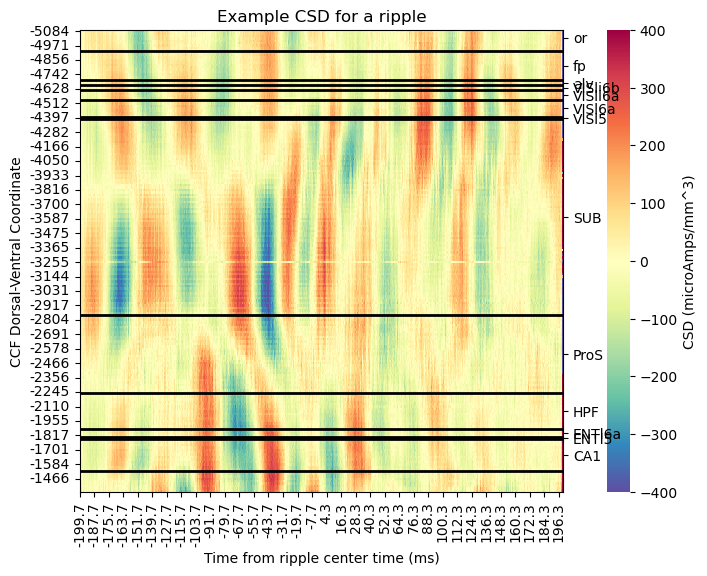

In [83]:

# Plotting
# colors...
#colors = [(0, 0, 1), (1, 0, 0)]  # Blue (low) to Red (high)
#custom_cmap = mcolors.LinearSegmentedColormap.from_list("Custom Colormap", colors, N=256)
offset = 0.2
event_mask = (lfp_time_index_og >= (desired_event.global_peak_time-offset)) & (lfp_time_index_og <= (desired_event.global_peak_time+offset))

lfp_slice = destriped[:,event_mask]
time_slice = lfp_time_index_og[event_mask]

lfp_slice = lfp_slice * 1000000
current_sink_this_rip = compute_csd(lfp_slice.T, spacing_between_channels=20, chan_rows =channels['rawInd'])
#time (x) in miliseconds from middle of ripple envelope, should move to using ripple peak time
rippeaktime = desired_event.global_peak_time
time_ripple_centered_ms = time_slice - desired_event.global_peak_time
time_ripple_centered_ms = time_ripple_centered_ms*1000
time_ripple_centered_ms = [round(x, 1) for x in time_ripple_centered_ms]

# plotting
scaled_filtered_smoothed_csd = np.transpose(current_sink_this_rip)
# so it's orientated from cortical surface
scaled_filtered_smoothed_csd = np.flip(scaled_filtered_smoothed_csd, axis=0) 
sig = scaled_filtered_smoothed_csd.shape[1] / 10.0  # Proportional to the size of the array
# Apply Gaussian smoothing
#scaled_filtered_smoothed_csd = gaussian_filter(scaled_filtered_smoothed_csd, sigma=1)
#scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1) # smoothed only along time
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>0.03] = 0.03
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-0.03] = -0.03

scaled_filtered_smoothed_csd *= 1000000
#scaled_filtered_smoothed_csd = exponential_smoothing_2d(scaled_filtered_smoothed_csd, alpha=0.5, axis=1)
scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1)
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>400] = 400
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-400] = -400

#depth (y)
ccf_dorsal_ventral = channels['mlapdv'][:,2]
allen_ontology_annot_og = channels['allen2017_25um_acronym']
mask = np.full(current_sink_this_rip.shape[1]*2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
#ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot_og[mask] 
#allen_ontology_annot = np.flip(allen_ontology_annot)
#allen_ontology_annot = allen_ontology_annot.to_numpy()

# y axis subsampling for plotting purposes
ylen = scaled_filtered_smoothed_csd.shape[0]
y_tick_positions = np.linspace(0, ylen - 1, int(ylen/10), dtype=int)
xlen = scaled_filtered_smoothed_csd.shape[1]
x_tick_positions = np.linspace(0, xlen - 1, int(xlen/10), dtype=int)

plt.figure(figsize=(8, 6))
scaled_filtered_smoothed_csd = pd.DataFrame(scaled_filtered_smoothed_csd)
scaled_filtered_smoothed_csd.index = ccf_dorsal_ventral
scaled_filtered_smoothed_csd.columns = time_ripple_centered_ms

heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f",
                      #xticklabels=np.array(time_ripple_centered_ms)[x_tick_positions],
                      #yticklabels=np.array(ccf_dorsal_ventral)[y_tick_positions],
                      cmap="Spectral_r") # 'icefire' # 'coolwarm' # 'spectral'

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

# plotting Allen Ontology Annotations
# Plot the secondary y-axis labels at the midpoint of each factor transition
factor_indices = [i for i in range(1, len(allen_ontology_annot)) if (i > 0) & (allen_ontology_annot[i] != allen_ontology_annot[i - 1])]
factor_positions = [(i + j) / 2 for i, j in zip(factor_indices, factor_indices[1:] + [len(allen_ontology_annot)])]
# Create a list of labels
labels = np.unique(allen_ontology_annot)

# If there are more tick positions than labels, pad the labels list with empty strings
if len(factor_positions) > len(labels):
    labels = np.append(labels, [''] * (len(factor_positions) - len(labels)))


# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(factor_positions)
#ax2.set_yticklabels(np.unique(allen_ontology_annot))
ax2.set_yticklabels(labels)
plt.hlines(factor_indices, *plt.xlim(), colors='black', linewidth=2)
# Turns off grid on the left Axis.
ax2.grid(False)


heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
#plt.savefig("Muller_2017-01-09_mhse_csd/Draft_ripple_CSD_plot_4.png")
plt.show()

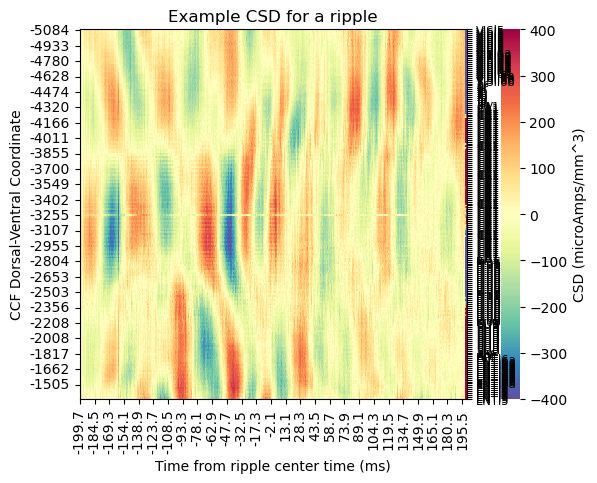

In [84]:
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f",
                      cmap="Spectral_r") 

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(range(len(allen_ontology_annot)))
ax2.set_yticklabels(allen_ontology_annot, fontsize='small')
#plt.hlines(range(len(allen_ontology_annot)), *plt.xlim(), colors='black', linewidth=2)
# Turns off grid on the left Axis.
ax2.grid(False)

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

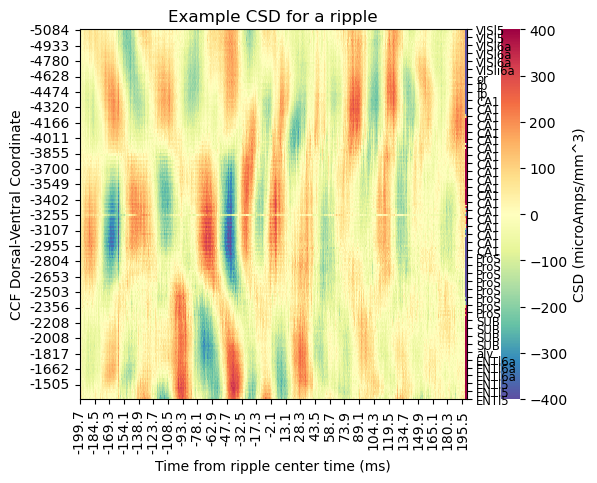

In [85]:
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f",
                      cmap="Spectral_r") 

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(range(0, len(allen_ontology_annot), 4))
ax2.set_yticklabels(allen_ontology_annot[::4], fontsize='small')

# Turns off grid on the left Axis.
ax2.grid(False)

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

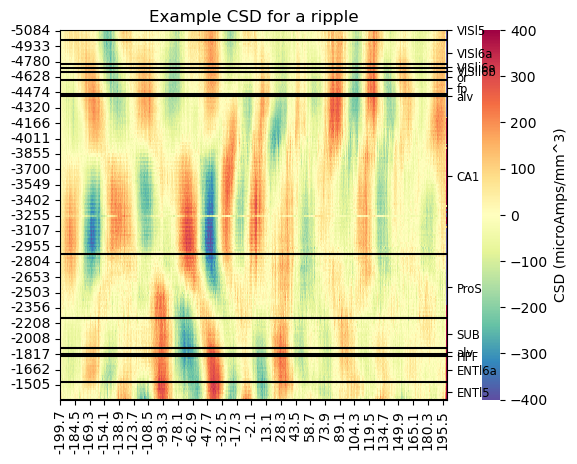

In [86]:
plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

# Calculate the midpoints of each stretch of the same label and the labels for these midpoints
midpoints = []
labels = []
start = 0
for i in range(1, len(allen_ontology_annot)):
    if allen_ontology_annot[i] != allen_ontology_annot[i - 1]:
        midpoints.append((start + i - 1) / 2)
        labels.append(allen_ontology_annot[start])
        start = i
midpoints.append((start + len(allen_ontology_annot) - 1) / 2)
labels.append(allen_ontology_annot[start])

heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f",
                      cmap="Spectral_r") 

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(midpoints)
ax2.set_yticklabels(labels, fontsize='small')

# Find the indices where the label changes
change_indices = np.where(np.roll(allen_ontology_annot, 1) != allen_ontology_annot)[0]

# Draw horizontal lines at these indices
for idx in change_indices:
    plt.axhline(y=idx, color='black')

# Turns off grid on the left Axis.
ax2.grid(False)

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

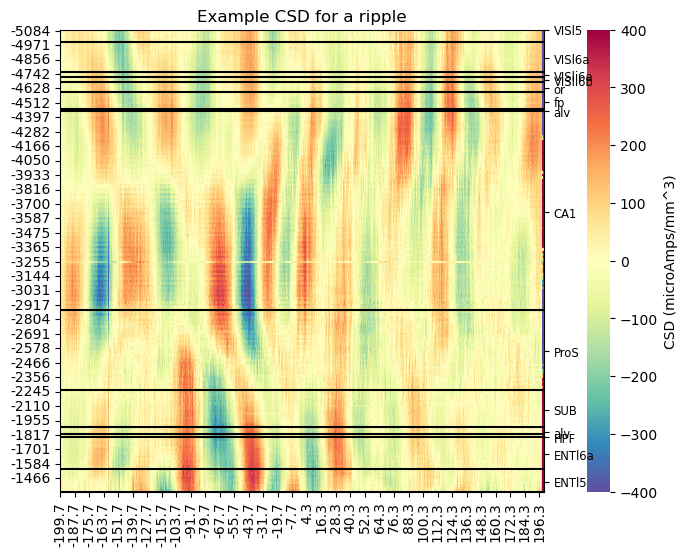

In [87]:
plt.figure(figsize=(8, 6))
lfp_slice

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

# Calculate the midpoints of each stretch of the same label and the labels for these midpoints
midpoints = []
labels = []
start = 0
for i in range(1, len(allen_ontology_annot)):
    if allen_ontology_annot[i] != allen_ontology_annot[i - 1]:
        midpoints.append((start + i - 1) / 2)
        labels.append(allen_ontology_annot[start])
        start = i
midpoints.append((start + len(allen_ontology_annot) - 1) / 2)
labels.append(allen_ontology_annot[start])

heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f",
                      cmap="Spectral_r") 

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(midpoints)
ax2.set_yticklabels(labels, fontsize='small')

# Find the indices where the label changes
change_indices = np.where(np.roll(allen_ontology_annot, 1) != allen_ontology_annot)[0]

# Draw horizontal lines at these indices
for idx in change_indices:
    plt.axhline(y=idx, color='black')

# Turns off grid on the left Axis.
ax2.grid(False)

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))

# Add your heatmap code here
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f", cmap="Spectral_r") 

# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Downsample the traces further by taking one in every nth probe
nth_probe = 6
trace_arr = lfp_slice[1::nth_probe]  

# Calculate the standard deviation of the whole lfp_slice array
std_dev = np.std(lfp_slice)

for i, trace in enumerate(trace_arr):
    # Normalize the trace so that a value of the standard deviation of the whole lfp_slice array occupies half of the total space allotted to the trace
    trace = trace / (2 * std_dev)

    # Rescale the trace to fit within its allotted space on the y-axis
    trace = trace * nth_probe

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = trace + i * nth_probe  # multiply by nth_probe to match the original channel position

    plt.plot(range(len(trace)), trace, color='black', linewidth=0.5)

# Calculate the midpoints of each stretch of the same label and the labels for these midpoints
midpoints = []
labels = []
start = 0
for i in range(1, len(allen_ontology_annot)):
    if allen_ontology_annot[i] != allen_ontology_annot[i - 1]:
        midpoints.append((start + i - 1) / 2)
        labels.append(allen_ontology_annot[start])
        start = i
midpoints.append((start + len(allen_ontology_annot) - 1) / 2)
labels.append(allen_ontology_annot[start])

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(midpoints)
ax2.set_yticklabels(labels, fontsize='small')

# Find the indices where the label changes
change_indices = np.where(np.roll(allen_ontology_annot, 1) != allen_ontology_annot)[0]

# Draw horizontal lines at these indices
for idx in change_indices:
    plt.axhline(y=idx, color='grey')

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

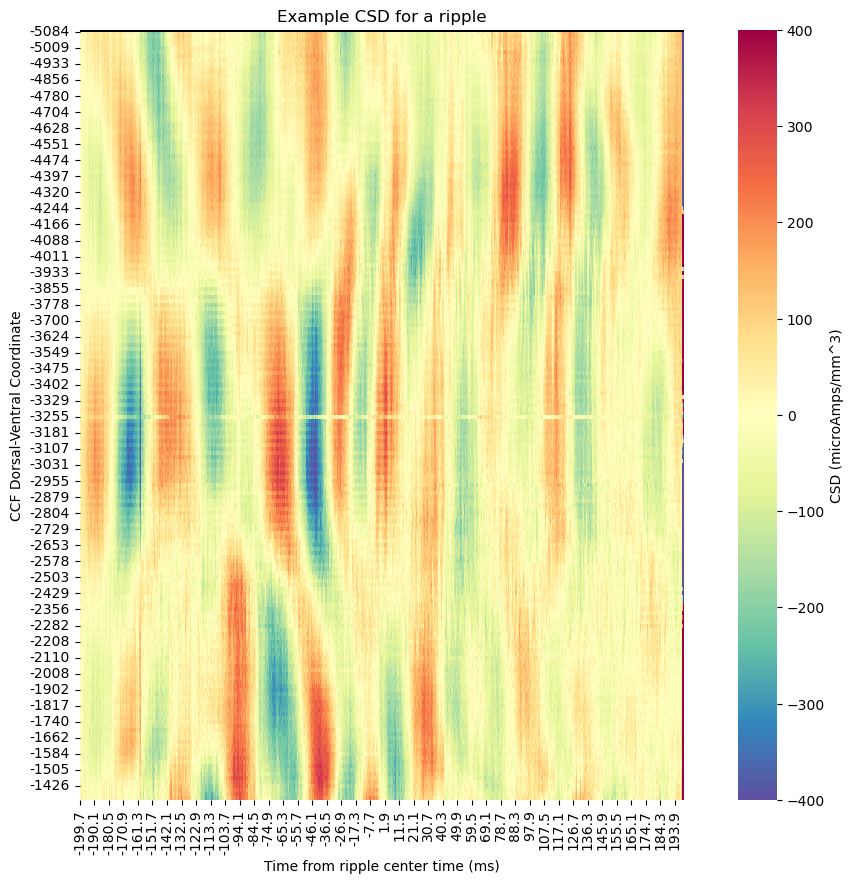

In [88]:
plt.figure(figsize=(10, 10))
# Add your heatmap code here
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f",
                      cmap="Spectral_r") 

# Assuming lfp_slice is a 2D array where each row is a separate LFP trace
for i, trace in enumerate(lfp_slice):
    # Rescale the trace
    trace = np.where(trace == 0, i + 0.5, trace)
    trace = trace / 1000
    plt.plot(range(len(trace)), trace, color='black')

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")



heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

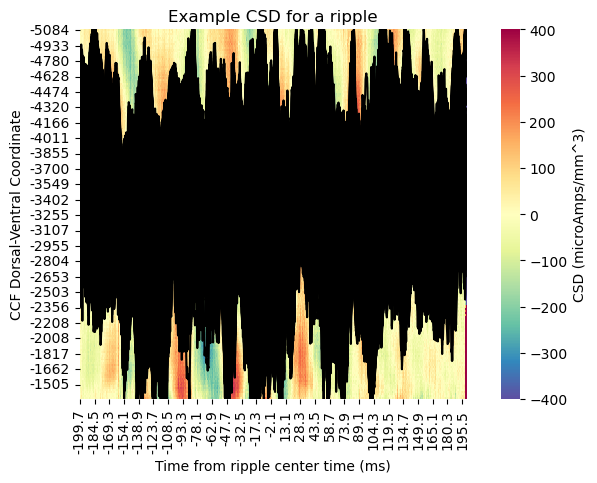

In [89]:
# Add your heatmap code here
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f",
                      cmap="Spectral_r") 

# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Assuming lfp_slice is a 2D array where each row is a separate LFP trace
for i, trace in enumerate(lfp_slice):
    # Rescale the trace
    trace = np.where(trace == 0, i + 0.5, trace)
    trace = trace / 1000

    # Normalize the trace to the range of the heatmap's y-axis
    trace = (trace - np.min(trace)) / (np.max(trace) - np.min(trace)) * (ymax - ymin) + ymin

    plt.plot(range(len(trace)), trace, color='black')

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

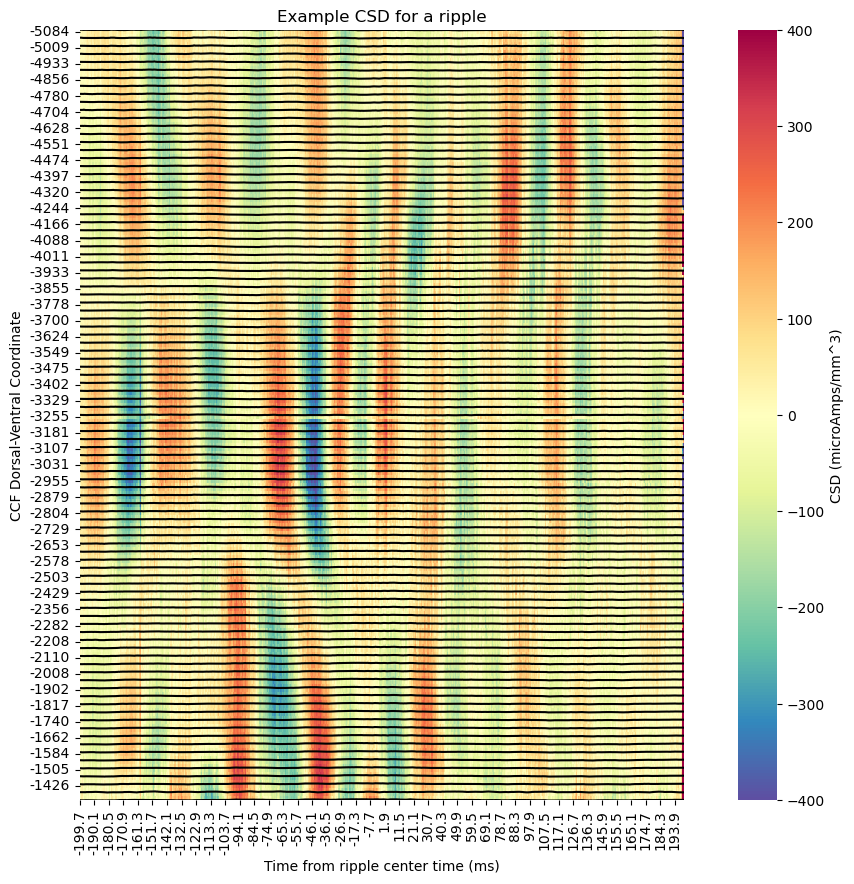

In [90]:
plt.figure(figsize=(10, 10))

# Add your heatmap code here
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f",
                      cmap="Spectral_r") 

# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Assuming lfp_slice is a 2D array where each row is a separate LFP trace
# Take one in every two of the channels
trace_arr = lfp_slice[1::2]  # start from index 1 to get odd traces

for i, trace in enumerate(trace_arr):
    # Rescale the trace
    trace = np.where(trace == 0, i + 0.5, trace)
    trace = trace / 1000

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = trace + i * 2  # multiply by 2 to match the original channel position

    plt.plot(range(len(trace)), trace, color='black')

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

In [91]:
scaled_filtered_smoothed_csd.shape

(192, 1000)

In [92]:
lfp_slice.shape

(384, 1000)

In [95]:
lfp_slice.max()

224.10636521031876

In [96]:
def summarize_array(arr):
    summary = {
        'mean': np.mean(arr),
        'std_dev': np.std(arr),
        'min': np.min(arr),
        '25%': np.percentile(arr, 25),
        '50%': np.median(arr),
        '75%': np.percentile(arr, 75),
        'max': np.max(arr)
    }
    return summary

print(summarize_array(lfp_slice))

{'mean': -3.1661605910805943, 'std_dev': 69.69276357207505, 'min': -291.8192844879854, '25%': -43.262939189324314, '50%': -3.3881317890172014e-15, '75%': 40.40026069989074, 'max': 224.10636521031876}


In [97]:
print(summarize_array(ca1_lfp))

{'mean': -1.8307072099535733, 'std_dev': 74.85084657220922, 'min': -291.8192844879854, '25%': -43.95294414726305, '50%': 1.121061503847254, '75%': 45.00188850472033, 'max': 224.10636521031876}


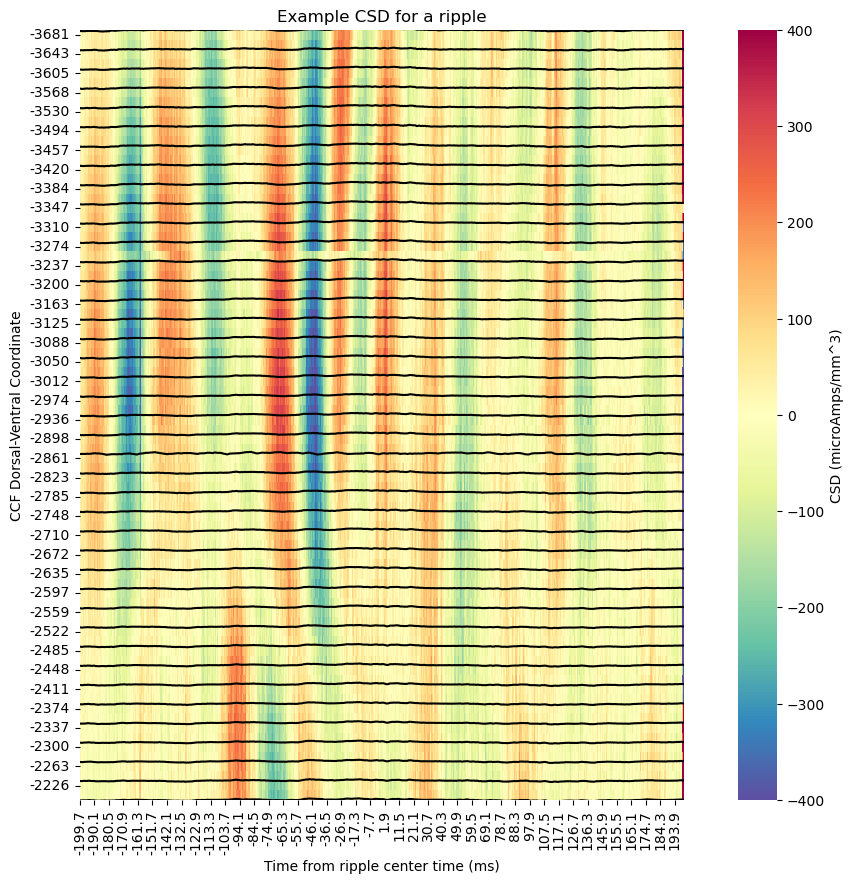

In [93]:
plt.figure(figsize=(10, 10))

# Filter rows where 'CA1' is present in allen_ontology_annot
ca1_indices = allen_ontology_annot == 'CA1'
#ca1_indices = ca1_indices[::2]  # start from index 0 to get odd indices

ca1_csd = scaled_filtered_smoothed_csd[ca1_indices]
ca1_lfp = lfp_slice[allen_ontology_annot_og=='CA1']

# Add your heatmap code here
heatmap = sns.heatmap(ca1_csd, cbar_kws={'pad': 0.07}, fmt=".2f",
                      cmap="Spectral_r") 

# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Take one in every two of the channels
trace_arr = ca1_lfp[1::2]  # start from index 1 to get odd traces

for i, trace in enumerate(trace_arr):
    # Rescale the trace
    trace = np.where(trace == 0, i + 0.5, trace)
    trace = trace / 1000

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = trace + i * 2  # multiply by 2 to match the original channel position

    plt.plot(range(len(trace)), trace, color='black')

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

In [63]:
# Filter rows where 'CA1' is present in allen_ontology_annot
ca1_indices = allen_ontology_annot == 'CA1'

ca1_csd = scaled_filtered_smoothed_csd[ca1_indices]
ca1_lfp = lfp_slice[ca1_indices]
ca1_lfp

IndexError: boolean index did not match indexed array along dimension 0; dimension is 384 but corresponding boolean dimension is 192

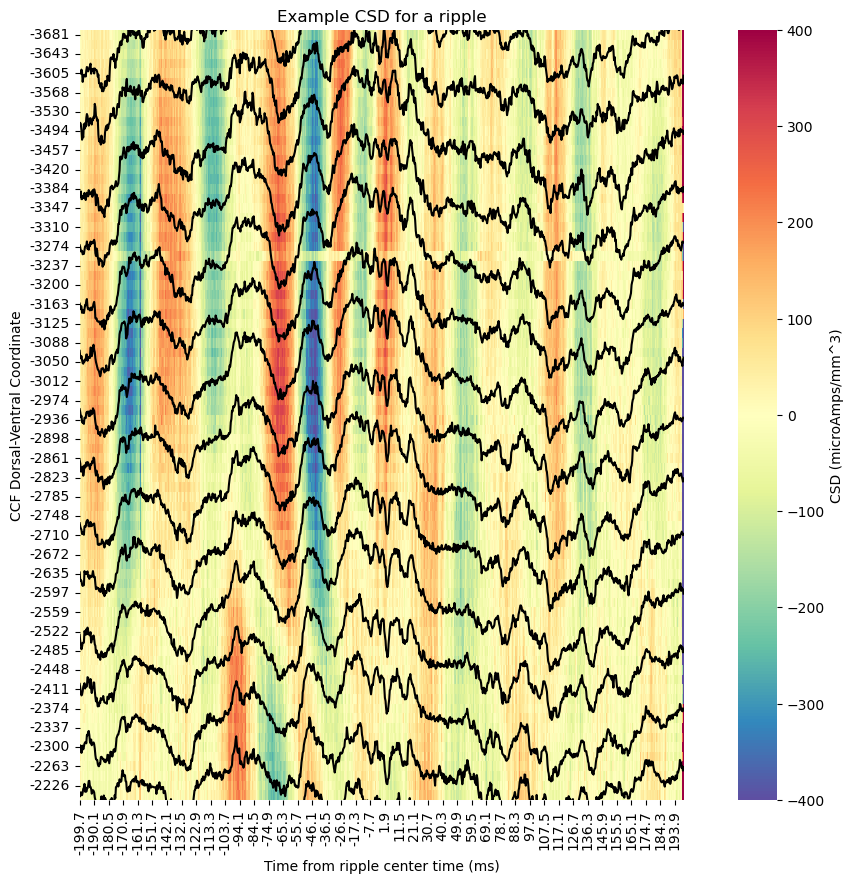

In [101]:
plt.figure(figsize=(10, 10))

# Filter rows where 'CA1' is present in allen_ontology_annot
ca1_indices = allen_ontology_annot == 'CA1'

ca1_csd = scaled_filtered_smoothed_csd[ca1_indices]
ca1_lfp = lfp_slice[allen_ontology_annot_og=='CA1']

# Add your heatmap code here
heatmap = sns.heatmap(ca1_csd, cbar_kws={'pad': 0.07}, fmt=".2f",
                      cmap="Spectral_r") 

# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Downsample the traces further by taking one in every nth probe
nth_probe = 6
trace_arr = ca1_lfp[1::nth_probe]  

# Calculate the standard deviation of the whole ca1_lfp array
std_dev = np.std(ca1_lfp)

for i, trace in enumerate(trace_arr):
    # Normalize the trace so that a value of the standard deviation of the whole ca1_lfp array occupies half of the total space allotted to the trace
    trace = trace / (2 * std_dev)

    # Rescale the trace to fit within its allotted space on the y-axis
    trace = trace * nth_probe

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = trace + i * nth_probe  # multiply by nth_probe to match the original channel position

    plt.plot(range(len(trace)), trace, color='black')

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

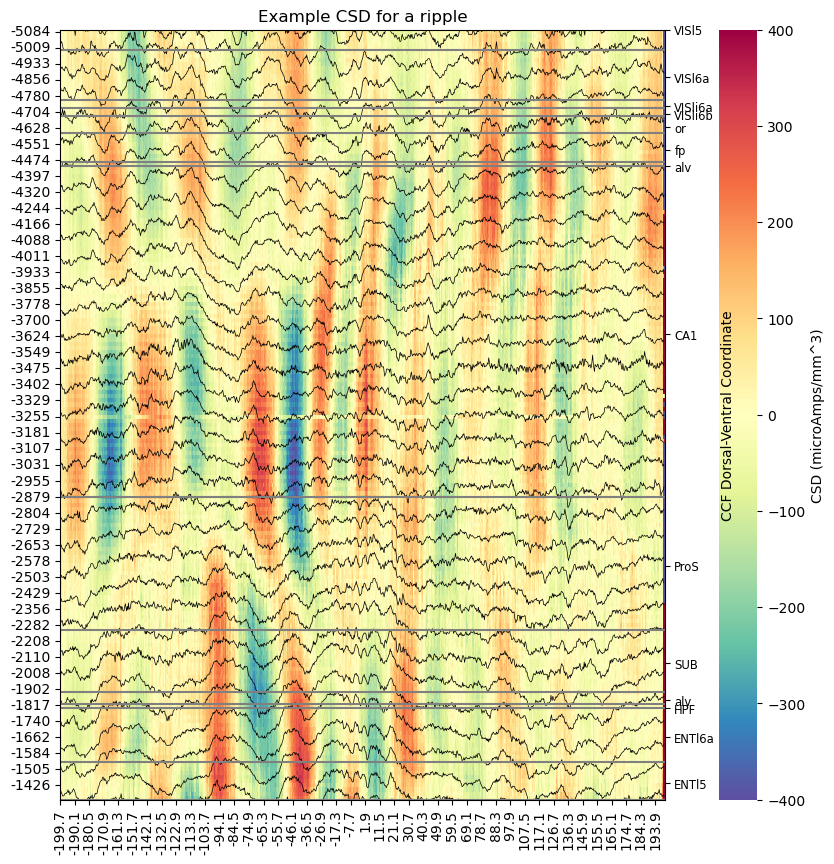

In [104]:
plt.figure(figsize=(10, 10))

# Add your heatmap code here
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f", cmap="Spectral_r") 

# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Downsample the traces further by taking one in every nth probe
nth_probe = 6
trace_arr = lfp_slice[1::nth_probe]  

# Calculate the standard deviation of the whole lfp_slice array
std_dev = np.std(lfp_slice)

for i, trace in enumerate(trace_arr):
    # Normalize the trace so that a value of the standard deviation of the whole lfp_slice array occupies half of the total space allotted to the trace
    trace = trace / (2 * std_dev)

    # Rescale the trace to fit within its allotted space on the y-axis
    trace = trace * nth_probe

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = trace + i * nth_probe  # multiply by nth_probe to match the original channel position

    plt.plot(range(len(trace)), trace, color='black', linewidth=0.5)

# Calculate the midpoints of each stretch of the same label and the labels for these midpoints
midpoints = []
labels = []
start = 0
for i in range(1, len(allen_ontology_annot)):
    if allen_ontology_annot[i] != allen_ontology_annot[i - 1]:
        midpoints.append((start + i - 1) / 2)
        labels.append(allen_ontology_annot[start])
        start = i
midpoints.append((start + len(allen_ontology_annot) - 1) / 2)
labels.append(allen_ontology_annot[start])

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(midpoints)
ax2.set_yticklabels(labels, fontsize='small')

# Find the indices where the label changes
change_indices = np.where(np.roll(allen_ontology_annot, 1) != allen_ontology_annot)[0]

# Draw horizontal lines at these indices
for idx in change_indices:
    plt.axhline(y=idx, color='grey')

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

In [53]:
allen_ontology_annot[::4]

array(['ENTl5', 'ENTl5', 'ENTl5', 'ENTl6a', 'ENTl6a', 'ENTl6a', 'alv',
       'SUB', 'SUB', 'SUB', 'SUB', 'ProS', 'ProS', 'ProS', 'ProS', 'ProS',
       'ProS', 'ProS', 'ProS', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'fp', 'fp', 'or', 'VISli6a',
       'VISl6a', 'VISl6a', 'VISl6a', 'VISl5', 'VISl5'], dtype=object)

In [57]:
lfp_slice.min()

-291.8192844879854

In [ ]:

# Plotting
# colors...
#colors = [(0, 0, 1), (1, 0, 0)]  # Blue (low) to Red (high)
#custom_cmap = mcolors.LinearSegmentedColormap.from_list("Custom Colormap", colors, N=256)
offset = 0.2
event_mask = (lfp_time_index_og >= (desired_event.global_peak_time-offset)) & (lfp_time_index_og <= (desired_event.global_peak_time+offset))

lfp_slice = destriped[:,event_mask]
time_slice = lfp_time_index_og[event_mask]

lfp_slice = lfp_slice * 1000000
current_sink_this_rip = compute_csd(lfp_slice.T, spacing_between_channels=20, chan_rows =channels['rawInd'])
#time (x) in miliseconds from middle of ripple envelope, should move to using ripple peak time
rippeaktime = desired_event.global_peak_time
time_ripple_centered_ms = time_slice - desired_event.global_peak_time
time_ripple_centered_ms = time_ripple_centered_ms*1000
time_ripple_centered_ms = [round(x, 1) for x in time_ripple_centered_ms]

# plotting
scaled_filtered_smoothed_csd = np.transpose(current_sink_this_rip)
# so it's orientated from cortical surface
scaled_filtered_smoothed_csd = np.flip(scaled_filtered_smoothed_csd, axis=0) 
sig = scaled_filtered_smoothed_csd.shape[1] / 10.0  # Proportional to the size of the array
# Apply Gaussian smoothing
#scaled_filtered_smoothed_csd = gaussian_filter(scaled_filtered_smoothed_csd, sigma=1)
#scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1) # smoothed only along time
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>0.03] = 0.03
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-0.03] = -0.03

scaled_filtered_smoothed_csd *= 1000000
#scaled_filtered_smoothed_csd = exponential_smoothing_2d(scaled_filtered_smoothed_csd, alpha=0.5, axis=1)
scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1)
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>400] = 400
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-400] = -400

#depth (y)
ccf_dorsal_ventral = channels['mlapdv'][:,2]
allen_ontology_annot = channels['allen2017_25um_acronym']
mask = np.full(current_sink_this_rip.shape[1]*2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
#ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot[mask] 
#allen_ontology_annot = np.flip(allen_ontology_annot)
#allen_ontology_annot = allen_ontology_annot.to_numpy()

# y axis subsampling for plotting purposes
ylen = scaled_filtered_smoothed_csd.shape[0]
y_tick_positions = np.linspace(0, ylen - 1, int(ylen/10), dtype=int)
xlen = scaled_filtered_smoothed_csd.shape[1]
x_tick_positions = np.linspace(0, xlen - 1, int(xlen/10), dtype=int)

plt.figure(figsize=(8, 6))
scaled_filtered_smoothed_csd = pd.DataFrame(scaled_filtered_smoothed_csd)
scaled_filtered_smoothed_csd.index = ccf_dorsal_ventral
scaled_filtered_smoothed_csd.columns = time_ripple_centered_ms

#heatmap
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f",
                      cmap="Spectral_r") 

plt.title("Example CSD for a ripple")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(range(0, len(allen_ontology_annot), 4))
ax2.set_yticklabels(allen_ontology_annot[::4], fontsize='small')

# Turns off grid on the left Axis.
ax2.grid(False)

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
plt.show()

In [45]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
import matplotlib.pyplot as plt
import scipy.signal
from brainbox.ephys_plots import plot_brain_regions
from ibllib.plots import Density



In [49]:
print(ibllib.__version__)
print(brainbox.__version__)

NameError: name 'ibllib' is not defined

In [48]:
ssl = SpikeSortingLoader(pid=probe_id, one=one)
# The channels information is contained in a dict table / dataframe
channels = ssl.load_channels()

# Get AP and LFP spikeglx.Reader objects
sr_lf = ssl.raw_electrophysiology(band="lf", stream=True)

AttributeError: 'SpikeSortingLoader' object has no attribute 'raw_electrophysiology'

In [61]:
import matplotlib.pyplot as plt
import scipy.signal
from brainbox.ephys_plots import plot_brain_regions
from ibllib.plots import Density

sos_lf = scipy.signal.butter(3,   2 / sr_lf.fs /2, btype='highpass', output='sos')  #   2 Hz high pass LF band
filtered_lf = scipy.signal.sosfiltfilt(sos_lf, raw_lf)

# displays the AP band and LFP band around this stim_on event
fig, ax = plt.subplots(figsize=(9, 6))
Density(- filtered_lf, fs=sr_lf.fs, taxis=1, ax=ax)
plot_brain_regions(channels["atlas_id"], channel_depths=channels["axial_um"], ax=ax, display=True)

NameError: name 'sr_ap' is not defined

In [60]:
stimOn_times = one.load_object(ssl.eid, 'trials', collection='alf')['stimOn_times']
event_no = 100
# timepoint in recording to stream, as per the experiment main clock
t_event = stimOn_times[event_no]

# corresponding sample in the AP data
s_event = int(ssl.samples2times(stimOn_times[event_no], direction='reverse'))
print(f'raw AP band sample for event at time {t_event}: {s_event}')

# get the AP data surrounding samples
window_secs_ap = [-0.05, 0.05]  # we'll look at 50ms before and after the event for AP
first, last = (int(window_secs_ap[0] * sr_ap.fs) + s_event, int(window_secs_ap[1] * sr_ap.fs + s_event))
raw_ap = sr_ap[first:last, :-sr_ap.nsync].T

# get the LF data surrounding samples
window_secs_ap = [-0.750, 0.750]  # we'll look at 750ms before and after the event because LF varies more slowly in time
sample_lf = s_event // 12  # NB: for neuropixel probes this is always 12 because AP is sampled at 12x the frequency of LF
first, last = (int(window_secs_ap[0] * sr_lf.fs) + sample_lf, int(window_secs_ap[1] * sr_lf.fs + sample_lf))
raw_lf = sr_lf[first:last, :-sr_lf.nsync].T

/home/acampbell/Downloads/ONE/openalyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_019/2020-08-19/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 7.26k/7.26k [00:00<00:00, 31.9kB/s]
/home/acampbell/Downloads/ONE/openalyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_019/2020-08-19/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 7.26k/7.26k [00:00<00:00, 34.7kB/s]
/home/acampbell/Downloads/ONE/openalyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_019/2020-08-19/001/alf/_ibl_trials.table.pqt: 100%|██████████| 69.2k/69.2k [00:00<00:00, 262kB/s]
/home/acampbell/Downloads/ONE/openalyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_019/2020-08-19/001/raw_ephys_data/probe01/_spikeglx_ephysData_g0_t0.imec1.timestamps.npy: 100%|██████████| 4.40k/4.40k [00:00<00:00, 19.9kB/s]
/home/acampbell/Downloads/ONE/openalyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_019/2020-08-19/001/raw_ephys_data/probe01/_spikeglx_ephysData_g0_t0.imec1.ap.meta: 10

raw AP band sample for event at time 422.52650979042255: 12675929


NameError: name 'sr_ap' is not defined

## Spectrograms of events

In [137]:
lowest_quantiles_df.head()

start_time     end_time                        probes_event_is_on  \
2718  4377.797483  4377.919483  ['30ac1320-d671-46fc-87ef-875cdfc6b4eb']   
759   4126.981436  4127.209437  ['e31b4e39-e350-47a9-aca4-72496d99ff2a']   
2481  3459.123970  3459.215970  ['30ac1320-d671-46fc-87ef-875cdfc6b4eb']   
635   3421.639965  3421.839965  ['e31b4e39-e350-47a9-aca4-72496d99ff2a']   
2926  5198.431644  5198.562977  ['30ac1320-d671-46fc-87ef-875cdfc6b4eb']   

     events_row_index  global_peak_time  global_max_zscore  \
2718            [734]       4377.878817          35.475916   
759             [536]       4127.143437          26.754735   
2481            [487]       3459.175304          26.124183   
635             [408]       3421.731965          25.033728   
2926            [945]       5198.465644          24.769245   

                                peak_probe  duration  \
2718  30ac1320-d671-46fc-87ef-875cdfc6b4eb  0.122000   
759   e31b4e39-e350-47a9-aca4-72496d99ff2a  0.228000   
2481  30ac1320-d671-46fc-87ef-875cdfc6b4eb  0.092000   
635   e31b4e39-e350-47a9-aca4-72496d99ff2a  0.200000   
2926  30ac1320-d671-46fc-87ef-875cdfc6b4eb  0.131333   

                                session_id    speeds  peakwindow_med  \
2718  edd22318-216c-44ff-bc24-49ce8be78374  0.000100       -0.129969   
759   746d1902-fa59-4cab-b0aa-013be36060d5  0.000061       -0.493216   
2481  edd22318-216c-44ff-bc24-49ce8be78374  0.000064       -0.640589   
635   746d1902-fa59-4cab-b0aa-013be36060d5  0.000127       -0.668576   
2926  edd22318-216c-44ff-bc24-49ce8be78374  0.000105       -0.382231   

      peakwindow_mean  eventwindow_med  eventwindow_mean  speeds_quantile  \
2718        -0.092238         0.093098          0.055351              0.0   
759         -0.329967        -0.670814         -0.662977              0.0   
2481        -0.638754        -0.622595         -0.626612              0.0   
635         -0.572232        -0.260023         -0.339748              0.0   
2926        -0.410565        -0.536941         -0.534441              0.0   

      peakwindow_mean_quantile  
2718                       0.0  
759                        0.0  
2481                       0.0  
635                        0.0  
2926                       0.0

## Making Brain Images of Probes

Using this code you can take snapshots of the probe locations in 

https://community.brain-map.org/t/how-to-switch-between-the-3-coordinate-systems-of-mouse-connectivity/952 <br>
https://community.brain-map.org/t/how-to-transform-ccf-x-y-z-coordinates-into-stereotactic-coordinates/1858

In [27]:
seshes = os.listdir('/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024')
seshes = [s.replace('swrs_session_', '') for s in seshes if 'swrs_session_' in s]
seshes = [int(s) for s in seshes]



In [28]:

import random
import os
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import vedo
from brainrender import Scene
from brainrender.actors import Points
from vedo import Plotter  # <- this will be used to render an embedded scene 
#from vedo import embedWindow    
vedo.settings.default_backend= 'k3d'

from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions

ba = AllenAtlas()
br = BrainRegions() # br is also an attribute of ba so could to br = ba.regions


In [30]:

def invert_transform(ap, dv, ml, resolution=25):
    # Step 4: transform back from micrometers to the coordinate system
    ap = ap * resolution
    dv = dv * resolution
    ml = ml * resolution

    # Step 3: undo the squeeze of the DV axis
    dv = dv / 0.9434

    # Step 2: undo the rotation
    theta = -0.0873  # -5 degrees in radians
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    x = ap * cos_theta - dv * sin_theta
    y = ap * sin_theta + dv * cos_theta

    # Step 1: re-center on Bregma
    # For a 10 μm resolution Bregma is estimated at (x,y,z) (540, 44, 570) rather than (216, 18, 228)
    x = x + 216
    y = y + 18
    z = ml + 228

    return x, y, z

In [31]:
def invert_transform2(ap, dv, ml, resolution=25):
    # Step 4: transform back from micrometers to the coordinate system
    ap = ap * resolution
    dv = dv * resolution
    ml = ml * resolution

    # Step 3: undo the squeeze of the DV axis
    dv = dv / 0.9434

    # Step 2: undo the rotation
    theta = -0.0873  # -5 degrees in radians
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    x = ap * cos_theta - dv * sin_theta
    y = ap * sin_theta + dv * cos_theta

    # Step 1: re-center on Bregma
    x = x + 216
    y = y + 18
    z = ml + 228

    return x, y, z

In [32]:
def original_transform(ap, dv, ml, resolution=25):
    # Step 1: center the CCF on Bregma
    ap = ap - 216
    dv = dv - 18
    ml = ml - 228

    # Step 2: Rotate the CCF
    theta = 0.0873  # 5 degrees in radians
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    X = ap * cos_theta - dv * sin_theta
    Y = ap * sin_theta + dv * cos_theta

    # Step 3: squeeze the DV axis
    Y = Y * 0.9434

    # Step 4: transform into micrometers
    X = X / resolution
    Y = Y / resolution
    Z = ml / resolution

    return X, Y, Z

# Example usage:
ap = 540
dv = 44
ml = 570

In [34]:
def original_transform2(ml, dv, ap, resolution=25):
    # Step 1: center the CCF on Bregma
    ml = ml - 216
    dv = dv - 18
    ap = ap - 228

    # Step 2: Rotate the CCF
    theta = 0.0873  # 5 degrees in radians
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    X = ml * cos_theta - dv * sin_theta
    Y = ml * sin_theta + dv * cos_theta

    # Step 3: squeeze the DV axis
    Y = Y * 0.9434

    # Step 4: transform into micrometers
    X = X / resolution
    Y = Y / resolution
    Z = ap / resolution

    return X, Y, Z

In [55]:
def edwards_transform(ml, ap,  dv,  resolution=25):
    
    ml_ccf = (ml+5700)
    #ap_ccf = ((-1)*ap + 5400)/resolution
    ap_ccf = -ap+4700
    dv_ccf = -dv
    
    
    return ml_ccf, ap_ccf, dv_ccf

In [57]:
# Display the Allen Brain mouse atlas.
scene = Scene(atlas_name="allen_mouse_25um", title="Cells in primary visual cortex")
# Make sure it gets embedded in the window
scene.jupyter = True

def get_n_random_points_in_region(region, N):
    """
    Gets N random points inside (or on the surface) of a mes
    """

    region_bounds = region.mesh.bounds()
    X = np.random.randint(region_bounds[0], region_bounds[1], size=10000)
    Y = np.random.randint(region_bounds[2], region_bounds[3], size=10000)
    Z = np.random.randint(region_bounds[4], region_bounds[5], size=10000)
    pts = [[x, y, z] for x, y, z in zip(X, Y, Z)]

    ipts = region.mesh.inside_points(pts).coordinates
    return np.vstack(random.choices(ipts, k=N))


scene = Scene(title="Labelled cells")

# Display a brain region
cornu_Ammonis_1 = scene.add_brain_region("CA1", alpha=0.2)

ca1_coordinates = []

# Iterate over all subdirectories in the base directory
for dir_name in os.listdir(ibl_ripples_path):
    if 'swrs_session_' in dir_name:
        # Extract the session ID from the directory name and get the session data
        session_id = dir_name.split('swrs_session_')[1]
        print(session_id)
        probelist, probenames = one.eid2pid(session_id) # probe_id is pid in the IBL tutorials
        
        # Iterate over all files in the directory
        for file_name in os.listdir(os.path.join(ibl_ripples_path, dir_name)):
            print(file_name)
            ca1_coordinates = []
            if 'karlsson' in file_name:
                # Extract probe_id from the filename
                probe_id = re.search('probe_(.*?)_', file_name).group(1)
                print(probe_id)
                p_idx = np.array([p==probe_id for p in probelist])
                probe_name = np.array(probenames)[p_idx]
                probe_name = probe_name[0]
                collectionname = f'alf/{probe_name}/pykilosort' # ensures channels are all from this probe
                channels = one.load_object(session_id, 'channels', collection=collectionname)
                channels.allen2017_25um_acronym = br.id2acronym( channels['brainLocationIds_ccf_2017'] )
                ca1index = channels['allen2017_25um_acronym'] == 'CA1'
                # Get the coordinates for all CA1 channels specific to the probe_id
                ca1_coordinates = channels['mlapdv'][ca1index]
                transformed_coordinates = np.array([edwards_transform(ml, ap, dv, resolution=25) for ml, ap, dv in ca1_coordinates])
                
                # rearanging it so that it can be plotted 
                transformed_coordinates = np.take(transformed_coordinates, [1, 2, 0], axis=1)
                
                # Extract the dorsal_ventral_ccf_coordinate values
                dorsal_ventral_values = transformed_coordinates[:,1]
                
                # Sort the values
                sorted_values = np.sort(dorsal_ventral_values)

                # Calculate the mid-point
                mid_point_value = sorted_values[len(sorted_values) // 2]

                # Find the row with the mid-point value
                mid_point_row = transformed_coordinates[np.where(transformed_coordinates[:, 1] == mid_point_value)]

                scene.add(
                    Points(
                        mid_point_row,
                        name="probe_1",
                        colors="black",
                        radius=100,
                    )
                )
            
# Add label to the brain region
scene.add_label(cornu_Ammonis_1, "CA1")

# render
scene.content
scene.render()

plt = Plotter()
plt.show(*scene.renderables)

0cc486c3-8c7b-494d-aa04-b70e2690bcba
probe_db2100c3-64ac-463e-97a1-20ce8266cd5f_channel_channelsrawInd_366_karlsson_detector_events.csv
db2100c3-64ac-463e-97a1-20ce8266cd5f
probe_db2100c3-64ac-463e-97a1-20ce8266cd5f_channel_channelsrawInd_138_movement_artifacts.csv
probe_db2100c3-64ac-463e-97a1-20ce8266cd5f_channel_channelsrawInd_319_movement_artifacts.csv
session_0cc486c3-8c7b-494d-aa04-b70e2690bcba_putative_global_swrs_no_movement_no_gamma.csv
probe_db2100c3-64ac-463e-97a1-20ce8266cd5f_channel_channelsrawInd_366_gamma_band_events.csv
746d1902-fa59-4cab-b0aa-013be36060d5
probe_e31b4e39-e350-47a9-aca4-72496d99ff2a_channel_channelsrawInd_351_movement_artifacts.csv
session_746d1902-fa59-4cab-b0aa-013be36060d5_putative_global_swrs_no_movement_no_gamma.csv
probe_e31b4e39-e350-47a9-aca4-72496d99ff2a_channel_channelsrawInd_383_gamma_band_events.csv
probe_e31b4e39-e350-47a9-aca4-72496d99ff2a_channel_channelsrawInd_83_movement_artifacts.csv
probe_e31b4e39-e350-47a9-aca4-72496d99ff2a_channel_ch

/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_029/2020-09-14/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 27.7kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_029/2020-09-14/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 7.12kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_029/2020-09-14/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 13.8kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_029/2020-09-14/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.9kB/s]


0c828385-6dd6-4842-a702-c5075f5f5e81
probe_3d3d5a5e-df26-43ee-80b6-2d72d85668a5_channel_channelsrawInd_213_movement_artifacts.csv
probe_3d3d5a5e-df26-43ee-80b6-2d72d85668a5_channel_channelsrawInd_290_karlsson_detector_events.csv
3d3d5a5e-df26-43ee-80b6-2d72d85668a5
session_0c828385-6dd6-4842-a702-c5075f5f5e81_putative_global_swrs_no_movement_no_gamma.csv
probe_3d3d5a5e-df26-43ee-80b6-2d72d85668a5_channel_channelsrawInd_0_movement_artifacts.csv
probe_3d3d5a5e-df26-43ee-80b6-2d72d85668a5_channel_channelsrawInd_290_gamma_band_events.csv
b39752db-abdb-47ab-ae78-e8608bbf50ed
probe_954b1983-e603-4611-ba15-dc2db6f988ab_channel_channelsrawInd_94_movement_artifacts.csv
probe_954b1983-e603-4611-ba15-dc2db6f988ab_channel_channelsrawInd_192_karlsson_detector_events.csv
954b1983-e603-4611-ba15-dc2db6f988ab
probe_954b1983-e603-4611-ba15-dc2db6f988ab_channel_channelsrawInd_97_movement_artifacts.csv
session_b39752db-abdb-47ab-ae78-e8608bbf50ed_putative_global_swrs_no_movement_no_gamma.csv
probe_954b19

/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-01935/2021-02-03/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.9kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-01935/2021-02-03/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.6kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-01935/2021-02-03/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.7kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-01935/2021-02-03/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.8kB/s]


probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_383_gamma_band_events.csv
probe_7be00744-2e27-4062-8f56-3969e24e9990_channel_channelsrawInd_237_gamma_band_events.csv
probe_7be00744-2e27-4062-8f56-3969e24e9990_channel_channelsrawInd_303_movement_artifacts.csv
probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_199_movement_artifacts.csv
probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_185_movement_artifacts.csv
probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_383_karlsson_detector_events.csv
834fca72-0b69-44e4-b77e-95a61290b50d
572a95d1-39ca-42e1-8424-5c9ffcb2df87
probe_ae252f7b-0224-4925-8174-7b25c2385bb7_channel_channelsrawInd_267_gamma_band_events.csv
probe_ae252f7b-0224-4925-8174-7b25c2385bb7_channel_channelsrawInd_1_movement_artifacts.csv
probe_ae252f7b-0224-4925-8174-7b25c2385bb7_channel_channelsrawInd_125_movement_artifacts.csv
session_572a95d1-39ca-42e1-8424-5c9ffcb2df87_putative_global_swrs_no_movement_no_gamma.c

/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL052/2020-02-21/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.8kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL052/2020-02-21/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.2kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL052/2020-02-21/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.5kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL052/2020-02-21/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 13.7kB/s]


session_4b00df29-3769-43be-bb40-128b1cba6d35_putative_global_swrs_no_movement_no_gamma.csv
probe_8d59da25-3a9c-44be-8b1a-e27cdd39ca34_channel_channelsrawInd_364_movement_artifacts.csv
d9f0c293-df4c-410a-846d-842e47c6b502
probe_a12c8ae8-d5ad-4d15-b805-436ad23e5ad1_channel_channelsrawInd_264_karlsson_detector_events.csv
a12c8ae8-d5ad-4d15-b805-436ad23e5ad1
probe_a12c8ae8-d5ad-4d15-b805-436ad23e5ad1_channel_channelsrawInd_360_movement_artifacts.csv
probe_a12c8ae8-d5ad-4d15-b805-436ad23e5ad1_channel_channelsrawInd_264_gamma_band_events.csv
probe_a12c8ae8-d5ad-4d15-b805-436ad23e5ad1_channel_channelsrawInd_84_movement_artifacts.csv
session_d9f0c293-df4c-410a-846d-842e47c6b502_putative_global_swrs_no_movement_no_gamma.csv
9b528ad0-4599-4a55-9148-96cc1d93fb24
probe_485b50c8-71e1-4654-9a07-64395c15f5ed_channel_channelsrawInd_278_gamma_band_events.csv
probe_485b50c8-71e1-4654-9a07-64395c15f5ed_channel_channelsrawInd_213_movement_artifacts.csv
probe_485b50c8-71e1-4654-9a07-64395c15f5ed_channel_ch

/space/scratch/IBL_data_cache/steinmetzlab/Subjects/NR_0027/2022-08-19/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 10.3kB/s]
/space/scratch/IBL_data_cache/steinmetzlab/Subjects/NR_0027/2022-08-19/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.9kB/s]
/space/scratch/IBL_data_cache/steinmetzlab/Subjects/NR_0027/2022-08-19/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 25.9kB/s]
/space/scratch/IBL_data_cache/steinmetzlab/Subjects/NR_0027/2022-08-19/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.5kB/s]


7691eeb3-715b-4571-8fda-6bb57aab8253
session_7691eeb3-715b-4571-8fda-6bb57aab8253_putative_global_swrs_no_movement_no_gamma.csv
probe_41a3b948-13f4-4be7-90b9-150705d39005_channel_channelsrawInd_302_karlsson_detector_events.csv
41a3b948-13f4-4be7-90b9-150705d39005
probe_41a3b948-13f4-4be7-90b9-150705d39005_channel_channelsrawInd_302_gamma_band_events.csv
probe_41a3b948-13f4-4be7-90b9-150705d39005_channel_channelsrawInd_379_movement_artifacts.csv
probe_41a3b948-13f4-4be7-90b9-150705d39005_channel_channelsrawInd_116_movement_artifacts.csv
ebe090af-5922-4fcd-8fc6-17b8ba7bad6d
probe_11a5a93e-58a9-4ed0-995e-52279ec16b98_channel_channelsrawInd_51_movement_artifacts.csv
probe_11a5a93e-58a9-4ed0-995e-52279ec16b98_channel_channelsrawInd_64_movement_artifacts.csv
session_ebe090af-5922-4fcd-8fc6-17b8ba7bad6d_putative_global_swrs_no_movement_no_gamma.csv
probe_11a5a93e-58a9-4ed0-995e-52279ec16b98_channel_channelsrawInd_296_gamma_band_events.csv
probe_11a5a93e-58a9-4ed0-995e-52279ec16b98_channel_cha

/space/scratch/IBL_data_cache/mainenlab/Subjects/ZM_3003/2020-07-27/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 25.1kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZM_3003/2020-07-27/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.2kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZM_3003/2020-07-27/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.8kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZM_3003/2020-07-27/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.6kB/s]


probe_0b877123-0902-4432-b789-c4c6cc681df4_channel_channelsrawInd_380_movement_artifacts.csv
0f25376f-2b78-4ddc-8c39-b6cdbe7bf5b9
probe_44fc463b-405f-4048-9242-ac018b9f50f7_channel_channelsrawInd_269_gamma_band_events.csv
probe_44fc463b-405f-4048-9242-ac018b9f50f7_channel_channelsrawInd_213_movement_artifacts.csv
probe_44fc463b-405f-4048-9242-ac018b9f50f7_channel_channelsrawInd_269_karlsson_detector_events.csv
44fc463b-405f-4048-9242-ac018b9f50f7
probe_44fc463b-405f-4048-9242-ac018b9f50f7_channel_channelsrawInd_1_movement_artifacts.csv
session_0f25376f-2b78-4ddc-8c39-b6cdbe7bf5b9_putative_global_swrs_no_movement_no_gamma.csv
e535fb62-e245-4a48-b119-88ce62a6fe67
probe_c4f6665f-8be5-476b-a6e8-d81eeae9279d_channel_channelsrawInd_288_movement_artifacts.csv
probe_c4f6665f-8be5-476b-a6e8-d81eeae9279d_channel_channelsrawInd_287_gamma_band_events.csv
probe_c4f6665f-8be5-476b-a6e8-d81eeae9279d_channel_channelsrawInd_16_movement_artifacts.csv
session_e535fb62-e245-4a48-b119-88ce62a6fe67_putative

/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL055/2020-02-17/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 21.8kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL055/2020-02-17/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.3kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL055/2020-02-17/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.8kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL055/2020-02-17/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.6kB/s]


83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4
probe_1841cf1f-725d-499e-ab8e-7f6fc8c308b6_channel_channelsrawInd_371_gamma_band_events.csv
probe_1841cf1f-725d-499e-ab8e-7f6fc8c308b6_channel_channelsrawInd_281_movement_artifacts.csv
session_83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4_putative_global_swrs_no_movement_no_gamma.csv
probe_220bca21-4cf8-43f1-a213-71645899c571_channel_channelsrawInd_222_karlsson_detector_events.csv
220bca21-4cf8-43f1-a213-71645899c571


/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL052/2020-02-20/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.7kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL052/2020-02-20/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.0kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL052/2020-02-20/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 25.5kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL052/2020-02-20/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.4kB/s]


probe_220bca21-4cf8-43f1-a213-71645899c571_channel_channelsrawInd_222_gamma_band_events.csv
probe_1841cf1f-725d-499e-ab8e-7f6fc8c308b6_channel_channelsrawInd_262_movement_artifacts.csv
probe_1841cf1f-725d-499e-ab8e-7f6fc8c308b6_channel_channelsrawInd_371_karlsson_detector_events.csv
1841cf1f-725d-499e-ab8e-7f6fc8c308b6
probe_220bca21-4cf8-43f1-a213-71645899c571_channel_channelsrawInd_61_movement_artifacts.csv
probe_220bca21-4cf8-43f1-a213-71645899c571_channel_channelsrawInd_47_movement_artifacts.csv
5ae68c54-2897-4d3a-8120-426150704385
probe_a8a59fc3-a658-4db4-b5e8-09f1e4df03fd_channel_channelsrawInd_286_karlsson_detector_events.csv
a8a59fc3-a658-4db4-b5e8-09f1e4df03fd
probe_a8a59fc3-a658-4db4-b5e8-09f1e4df03fd_channel_channelsrawInd_286_gamma_band_events.csv
session_5ae68c54-2897-4d3a-8120-426150704385_putative_global_swrs_no_movement_no_gamma.csv
probe_a8a59fc3-a658-4db4-b5e8-09f1e4df03fd_channel_channelsrawInd_213_movement_artifacts.csv
probe_a8a59fc3-a658-4db4-b5e8-09f1e4df03fd_cha

/space/scratch/IBL_data_cache/wittenlab/Subjects/ibl_witten_27/2021-01-21/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.3kB/s]
/space/scratch/IBL_data_cache/wittenlab/Subjects/ibl_witten_27/2021-01-21/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 12.1kB/s]
/space/scratch/IBL_data_cache/wittenlab/Subjects/ibl_witten_27/2021-01-21/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.2kB/s]
/space/scratch/IBL_data_cache/wittenlab/Subjects/ibl_witten_27/2021-01-21/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.5kB/s]


probe_c9fb5e2e-bd92-41d8-8b7e-394005860a1e_channel_channelsrawInd_8_movement_artifacts.csv
probe_c9fb5e2e-bd92-41d8-8b7e-394005860a1e_channel_channelsrawInd_83_karlsson_detector_events.csv
c9fb5e2e-bd92-41d8-8b7e-394005860a1e
probe_0851db85-2889-4070-ac18-a40e8ebd96ba_channel_channelsrawInd_200_movement_artifacts.csv
probe_c9fb5e2e-bd92-41d8-8b7e-394005860a1e_channel_channelsrawInd_83_gamma_band_events.csv
session_73918ae1-e4fd-4c18-b132-00cb555b1ad2_putative_global_swrs_no_movement_no_gamma.csv
probe_0851db85-2889-4070-ac18-a40e8ebd96ba_channel_channelsrawInd_187_gamma_band_events.csv
a2ec6341-c55f-48a0-a23b-0ef2f5b1d71e
probe_5135e93f-2f1f-4301-9532-b5ad62548c49_channel_channelsrawInd_175_movement_artifacts.csv
probe_5135e93f-2f1f-4301-9532-b5ad62548c49_channel_channelsrawInd_272_gamma_band_events.csv
session_a2ec6341-c55f-48a0-a23b-0ef2f5b1d71e_putative_global_swrs_no_movement_no_gamma.csv
probe_5135e93f-2f1f-4301-9532-b5ad62548c49_channel_channelsrawInd_272_karlsson_detector_events

/space/scratch/IBL_data_cache/danlab/Subjects/DY_020/2020-09-29/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.6kB/s]
/space/scratch/IBL_data_cache/danlab/Subjects/DY_020/2020-09-29/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 22.7kB/s]
/space/scratch/IBL_data_cache/danlab/Subjects/DY_020/2020-09-29/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.0kB/s]
/space/scratch/IBL_data_cache/danlab/Subjects/DY_020/2020-09-29/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.3kB/s]


probe_63517fd4-ece1-49eb-9259-371dc30b1dd6_channel_channelsrawInd_268_gamma_band_events.csv
875c1e5c-f7ec-45ac-ab82-ecfe7276a707
probe_d151b391-e6e4-4daf-bd9c-191f4ad837b4_channel_channelsrawInd_299_movement_artifacts.csv
probe_d151b391-e6e4-4daf-bd9c-191f4ad837b4_channel_channelsrawInd_220_karlsson_detector_events.csv
d151b391-e6e4-4daf-bd9c-191f4ad837b4
probe_d151b391-e6e4-4daf-bd9c-191f4ad837b4_channel_channelsrawInd_220_gamma_band_events.csv
session_875c1e5c-f7ec-45ac-ab82-ecfe7276a707_putative_global_swrs_no_movement_no_gamma.csv
probe_d151b391-e6e4-4daf-bd9c-191f4ad837b4_channel_channelsrawInd_108_movement_artifacts.csv
5d6aa933-4b00-4e99-ae2d-5003657592e9
probe_61ed1a53-2f33-4a83-82ba-ec7dfa65bf60_channel_channelsrawInd_262_gamma_band_events.csv
probe_61ed1a53-2f33-4a83-82ba-ec7dfa65bf60_channel_channelsrawInd_262_karlsson_detector_events.csv
61ed1a53-2f33-4a83-82ba-ec7dfa65bf60
session_5d6aa933-4b00-4e99-ae2d-5003657592e9_putative_global_swrs_no_movement_no_gamma.csv
probe_61ed

/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL051/2020-02-05/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.8kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL051/2020-02-05/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 25.6kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL051/2020-02-05/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.0kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL051/2020-02-05/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 19.2kB/s]


session_ecb5520d-1358-434c-95ec-93687ecd1396_putative_global_swrs_no_movement_no_gamma.csv
probe_e55266c7-eb05-47bb-b263-1cc08dc3c00c_channel_channelsrawInd_95_movement_artifacts.csv
probe_e55266c7-eb05-47bb-b263-1cc08dc3c00c_channel_channelsrawInd_263_karlsson_detector_events.csv
e55266c7-eb05-47bb-b263-1cc08dc3c00c
d901aff5-2250-467a-b4a1-0cb9729df9e2
probe_12c0f3a9-518e-4dac-9651-5d95c2b4730f_channel_channelsrawInd_137_gamma_band_events.csv
probe_12c0f3a9-518e-4dac-9651-5d95c2b4730f_channel_channelsrawInd_338_movement_artifacts.csv
probe_12c0f3a9-518e-4dac-9651-5d95c2b4730f_channel_channelsrawInd_299_movement_artifacts.csv
probe_12c0f3a9-518e-4dac-9651-5d95c2b4730f_channel_channelsrawInd_137_karlsson_detector_events.csv
12c0f3a9-518e-4dac-9651-5d95c2b4730f
session_d901aff5-2250-467a-b4a1-0cb9729df9e2_putative_global_swrs_no_movement_no_gamma.csv
81a1dca0-cc90-47c5-afe3-c277319c47c8
probe_0f306cdc-878a-4ea0-9e91-b97736731637_channel_channelsrawInd_320_movement_artifacts.csv
probe_0f3

/space/scratch/IBL_data_cache/hoferlab/Subjects/SWC_060/2020-11-26/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 22.1kB/s]
/space/scratch/IBL_data_cache/hoferlab/Subjects/SWC_060/2020-11-26/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.7kB/s]
/space/scratch/IBL_data_cache/hoferlab/Subjects/SWC_060/2020-11-26/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 14.9kB/s]
/space/scratch/IBL_data_cache/hoferlab/Subjects/SWC_060/2020-11-26/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.9kB/s]


probe_0f306cdc-878a-4ea0-9e91-b97736731637_channel_channelsrawInd_380_movement_artifacts.csv
1f095590-6669-46c9-986b-ccaf0620c5e9
probe_ad256265-03f2-4b4e-954b-0ba0c5cf6707_channel_channelsrawInd_363_karlsson_detector_events.csv
ad256265-03f2-4b4e-954b-0ba0c5cf6707
probe_ad256265-03f2-4b4e-954b-0ba0c5cf6707_channel_channelsrawInd_304_movement_artifacts.csv
probe_ad256265-03f2-4b4e-954b-0ba0c5cf6707_channel_channelsrawInd_363_gamma_band_events.csv
session_1f095590-6669-46c9-986b-ccaf0620c5e9_putative_global_swrs_no_movement_no_gamma.csv
probe_ad256265-03f2-4b4e-954b-0ba0c5cf6707_channel_channelsrawInd_34_movement_artifacts.csv
2d5f6d81-38c4-4bdc-ac3c-302ea4d5f46e
session_2d5f6d81-38c4-4bdc-ac3c-302ea4d5f46e_putative_global_swrs_no_movement_no_gamma.csv
probe_dec6ad00-01c8-4bfd-bcdc-b37c5e0cdb0e_channel_channelsrawInd_335_movement_artifacts.csv
probe_dec6ad00-01c8-4bfd-bcdc-b37c5e0cdb0e_channel_channelsrawInd_75_movement_artifacts.csv
probe_dec6ad00-01c8-4bfd-bcdc-b37c5e0cdb0e_channel_ch

/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.4kB/s]
/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.6kB/s]
/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 22.6kB/s]
/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.6kB/s]


session_7cb81727-2097-4b52-b480-c89867b5b34c_putative_global_swrs_no_movement_no_gamma.csv
0a018f12-ee06-4b11-97aa-bbbff5448e9f
probe_16799c7a-e395-435d-a4c4-a678007e1550_channel_channelsrawInd_0_movement_artifacts.csv
probe_16799c7a-e395-435d-a4c4-a678007e1550_channel_channelsrawInd_291_gamma_band_events.csv
probe_16799c7a-e395-435d-a4c4-a678007e1550_channel_channelsrawInd_213_movement_artifacts.csv
probe_16799c7a-e395-435d-a4c4-a678007e1550_channel_channelsrawInd_291_karlsson_detector_events.csv
16799c7a-e395-435d-a4c4-a678007e1550
session_0a018f12-ee06-4b11-97aa-bbbff5448e9f_putative_global_swrs_no_movement_no_gamma.csv
f312aaec-3b6f-44b3-86b4-3a0c119c0438
probe_d585f4b5-d154-4666-92c4-eb219f1e0f02_channel_channelsrawInd_263_karlsson_detector_events.csv
d585f4b5-d154-4666-92c4-eb219f1e0f02


/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL058/2020-07-07/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.1kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL058/2020-07-07/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 25.6kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL058/2020-07-07/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.4kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL058/2020-07-07/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.0kB/s]


session_f312aaec-3b6f-44b3-86b4-3a0c119c0438_putative_global_swrs_no_movement_no_gamma.csv
probe_eeb27b45-5b85-4e5c-b6ff-f639ca5687de_channel_channelsrawInd_345_movement_artifacts.csv
probe_d585f4b5-d154-4666-92c4-eb219f1e0f02_channel_channelsrawInd_170_movement_artifacts.csv
probe_eeb27b45-5b85-4e5c-b6ff-f639ca5687de_channel_channelsrawInd_307_movement_artifacts.csv
probe_d585f4b5-d154-4666-92c4-eb219f1e0f02_channel_channelsrawInd_263_gamma_band_events.csv
probe_eeb27b45-5b85-4e5c-b6ff-f639ca5687de_channel_channelsrawInd_228_karlsson_detector_events.csv
eeb27b45-5b85-4e5c-b6ff-f639ca5687de
probe_d585f4b5-d154-4666-92c4-eb219f1e0f02_channel_channelsrawInd_91_movement_artifacts.csv
probe_eeb27b45-5b85-4e5c-b6ff-f639ca5687de_channel_channelsrawInd_228_gamma_band_events.csv
1e45d992-c356-40e1-9be1-a506d944896f
probe_76de0e1a-30aa-4713-9fe5-25ad2dff653f_channel_channelsrawInd_369_karlsson_detector_events.csv
76de0e1a-30aa-4713-9fe5-25ad2dff653f


/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_038/2020-07-31/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.9kB/s]
/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_038/2020-07-31/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 21.7kB/s]
/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_038/2020-07-31/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.5kB/s]
/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_038/2020-07-31/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.1kB/s]


probe_76de0e1a-30aa-4713-9fe5-25ad2dff653f_channel_channelsrawInd_369_gamma_band_events.csv
probe_76de0e1a-30aa-4713-9fe5-25ad2dff653f_channel_channelsrawInd_265_movement_artifacts.csv
probe_76de0e1a-30aa-4713-9fe5-25ad2dff653f_channel_channelsrawInd_13_movement_artifacts.csv
session_1e45d992-c356-40e1-9be1-a506d944896f_putative_global_swrs_no_movement_no_gamma.csv
5b49aca6-a6f4-4075-931a-617ad64c219c
session_5b49aca6-a6f4-4075-931a-617ad64c219c_putative_global_swrs_no_movement_no_gamma.csv
probe_f84f36c9-88f8-4d80-ba34-7f7a2b254ece_channel_channelsrawInd_137_gamma_band_events.csv
probe_f84f36c9-88f8-4d80-ba34-7f7a2b254ece_channel_channelsrawInd_137_karlsson_detector_events.csv
f84f36c9-88f8-4d80-ba34-7f7a2b254ece
probe_f84f36c9-88f8-4d80-ba34-7f7a2b254ece_channel_channelsrawInd_89_movement_artifacts.csv
probe_f84f36c9-88f8-4d80-ba34-7f7a2b254ece_channel_channelsrawInd_76_movement_artifacts.csv
d2832a38-27f6-452d-91d6-af72d794136c
probe_b25799a5-09e8-4656-9c1b-44bc9cbb5279_channel_chan

/space/scratch/IBL_data_cache/wittenlab/Subjects/ibl_witten_26/2021-01-28/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 22.3kB/s]
/space/scratch/IBL_data_cache/wittenlab/Subjects/ibl_witten_26/2021-01-28/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.8kB/s]
/space/scratch/IBL_data_cache/wittenlab/Subjects/ibl_witten_26/2021-01-28/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.3kB/s]
/space/scratch/IBL_data_cache/wittenlab/Subjects/ibl_witten_26/2021-01-28/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.2kB/s]


probe_9338f8bb-e097-46d8-81b4-7f37beb4d308_channel_channelsrawInd_379_gamma_band_events.csv
7f6b86f9-879a-4ea2-8531-294a221af5d0
probe_4c04120d-523a-4795-ba8f-49dbb8d9f63a_channel_channelsrawInd_317_movement_artifacts.csv
probe_9657af01-50bd-4120-8303-416ad9e24a51_channel_channelsrawInd_237_karlsson_detector_events.csv
9657af01-50bd-4120-8303-416ad9e24a51


/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_019/2020-08-14/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.5kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_019/2020-08-14/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 14.1kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_019/2020-08-14/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 24.4kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_019/2020-08-14/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.2kB/s]


session_7f6b86f9-879a-4ea2-8531-294a221af5d0_putative_global_swrs_no_movement_no_gamma.csv
probe_9657af01-50bd-4120-8303-416ad9e24a51_channel_channelsrawInd_84_movement_artifacts.csv
probe_9657af01-50bd-4120-8303-416ad9e24a51_channel_channelsrawInd_93_movement_artifacts.csv
probe_4c04120d-523a-4795-ba8f-49dbb8d9f63a_channel_channelsrawInd_260_movement_artifacts.csv
probe_9657af01-50bd-4120-8303-416ad9e24a51_channel_channelsrawInd_237_gamma_band_events.csv
probe_4c04120d-523a-4795-ba8f-49dbb8d9f63a_channel_channelsrawInd_191_gamma_band_events.csv
probe_4c04120d-523a-4795-ba8f-49dbb8d9f63a_channel_channelsrawInd_191_karlsson_detector_events.csv
4c04120d-523a-4795-ba8f-49dbb8d9f63a
754b74d5-7a06-4004-ae0c-72a10b6ed2e6
probe_6e1379e8-3af0-4fc5-8ba8-37d3bb02226b_channel_channelsrawInd_278_karlsson_detector_events.csv
6e1379e8-3af0-4fc5-8ba8-37d3bb02226b
probe_6e1379e8-3af0-4fc5-8ba8-37d3bb02226b_channel_channelsrawInd_4_movement_artifacts.csv
probe_6e1379e8-3af0-4fc5-8ba8-37d3bb02226b_chann

/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_029/2020-09-13/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 19.2kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_029/2020-09-13/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.3kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_029/2020-09-13/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.5kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_029/2020-09-13/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.0kB/s]


probe_54c8f5de-83d7-49b9-9b4c-67fe0f07289b_channel_channelsrawInd_381_movement_artifacts.csv
probe_91fb4ed3-ee27-4d7e-ba5d-f61202ed9884_channel_channelsrawInd_218_gamma_band_events.csv
probe_91fb4ed3-ee27-4d7e-ba5d-f61202ed9884_channel_channelsrawInd_218_karlsson_detector_events.csv
91fb4ed3-ee27-4d7e-ba5d-f61202ed9884
12dc8b34-b18e-4cdd-90a9-da134a9be79c
probe_43d4f889-4b05-44df-8306-ea10f854776f_channel_channelsrawInd_336_movement_artifacts.csv
probe_43d4f889-4b05-44df-8306-ea10f854776f_channel_channelsrawInd_203_gamma_band_events.csv
probe_43d4f889-4b05-44df-8306-ea10f854776f_channel_channelsrawInd_203_karlsson_detector_events.csv
43d4f889-4b05-44df-8306-ea10f854776f
session_12dc8b34-b18e-4cdd-90a9-da134a9be79c_putative_global_swrs_no_movement_no_gamma.csv
probe_43d4f889-4b05-44df-8306-ea10f854776f_channel_channelsrawInd_354_movement_artifacts.csv
ff96bfe1-d925-4553-94b5-bf8297adf259
probe_84fd7fa3-6c2d-4233-b265-46a427d3d68d_channel_channelsrawInd_285_movement_artifacts.csv
probe_8

/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.8kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.4kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.2kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 28.2kB/s]


66d98e6e-bcd9-4e78-8fbb-636f7e808b29
probe_4f10fbb7-57be-427b-bb1d-a19bd31dc27b_channel_channelsrawInd_243_gamma_band_events.csv
probe_4f10fbb7-57be-427b-bb1d-a19bd31dc27b_channel_channelsrawInd_361_movement_artifacts.csv
probe_4f10fbb7-57be-427b-bb1d-a19bd31dc27b_channel_channelsrawInd_243_karlsson_detector_events.csv
4f10fbb7-57be-427b-bb1d-a19bd31dc27b
session_66d98e6e-bcd9-4e78-8fbb-636f7e808b29_putative_global_swrs_no_movement_no_gamma.csv
probe_4f10fbb7-57be-427b-bb1d-a19bd31dc27b_channel_channelsrawInd_372_movement_artifacts.csv
e45481fa-be22-4365-972c-e7404ed8ab5a
probe_f2a098e7-a67e-4125-92d8-36fc6b606c45_channel_channelsrawInd_299_karlsson_detector_events.csv
f2a098e7-a67e-4125-92d8-36fc6b606c45


/space/scratch/IBL_data_cache/cortexlab/Subjects/KS086/2022-03-15/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.3kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS086/2022-03-15/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.4kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS086/2022-03-15/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.5kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS086/2022-03-15/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.4kB/s]


session_e45481fa-be22-4365-972c-e7404ed8ab5a_putative_global_swrs_no_movement_no_gamma.csv
probe_f2a098e7-a67e-4125-92d8-36fc6b606c45_channel_channelsrawInd_161_movement_artifacts.csv
probe_f2a098e7-a67e-4125-92d8-36fc6b606c45_channel_channelsrawInd_199_movement_artifacts.csv
probe_f2a098e7-a67e-4125-92d8-36fc6b606c45_channel_channelsrawInd_299_gamma_band_events.csv
768a371d-7e88-47f8-bf21-4a6a6570dd6e
session_768a371d-7e88-47f8-bf21-4a6a6570dd6e_putative_global_swrs_no_movement_no_gamma.csv
probe_39180bcb-13e5-46f9-89e1-8ea2cba22105_channel_channelsrawInd_206_movement_artifacts.csv
probe_39180bcb-13e5-46f9-89e1-8ea2cba22105_channel_channelsrawInd_368_gamma_band_events.csv
probe_39180bcb-13e5-46f9-89e1-8ea2cba22105_channel_channelsrawInd_368_karlsson_detector_events.csv
39180bcb-13e5-46f9-89e1-8ea2cba22105


/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_039/2020-09-10/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 14.1kB/s]
/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_039/2020-09-10/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 22.5kB/s]
/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_039/2020-09-10/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.5kB/s]
/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_039/2020-09-10/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 14.3kB/s]


probe_39180bcb-13e5-46f9-89e1-8ea2cba22105_channel_channelsrawInd_220_movement_artifacts.csv
c99d53e6-c317-4c53-99ba-070b26673ac4
probe_531423f6-d36d-472b-8234-c8f7b8293f79_channel_channelsrawInd_22_movement_artifacts.csv
probe_531423f6-d36d-472b-8234-c8f7b8293f79_channel_channelsrawInd_264_karlsson_detector_events.csv
531423f6-d36d-472b-8234-c8f7b8293f79
probe_531423f6-d36d-472b-8234-c8f7b8293f79_channel_channelsrawInd_264_gamma_band_events.csv
probe_531423f6-d36d-472b-8234-c8f7b8293f79_channel_channelsrawInd_343_movement_artifacts.csv
session_c99d53e6-c317-4c53-99ba-070b26673ac4_putative_global_swrs_no_movement_no_gamma.csv
824cf03d-4012-4ab1-b499-c83a92c5589e
probe_c07d13ed-e387-4457-8e33-1d16aed3fd92_channel_channelsrawInd_51_movement_artifacts.csv
session_824cf03d-4012-4ab1-b499-c83a92c5589e_putative_global_swrs_no_movement_no_gamma.csv
probe_c07d13ed-e387-4457-8e33-1d16aed3fd92_channel_channelsrawInd_179_movement_artifacts.csv
probe_c07d13ed-e387-4457-8e33-1d16aed3fd92_channel_ch

/space/scratch/IBL_data_cache/danlab/Subjects/DY_020/2020-09-30/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.0kB/s]
/space/scratch/IBL_data_cache/danlab/Subjects/DY_020/2020-09-30/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 24.2kB/s]
/space/scratch/IBL_data_cache/danlab/Subjects/DY_020/2020-09-30/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.2kB/s]
/space/scratch/IBL_data_cache/danlab/Subjects/DY_020/2020-09-30/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.4kB/s]


probe_6d24683c-da42-4610-baf0-7ceee7014394_channel_channelsrawInd_286_gamma_band_events.csv
1b715600-0cbc-442c-bd00-5b0ac2865de1
probe_bbe6ebc1-d32f-42dd-a89c-211226737deb_channel_channelsrawInd_262_karlsson_detector_events.csv
bbe6ebc1-d32f-42dd-a89c-211226737deb
probe_bbe6ebc1-d32f-42dd-a89c-211226737deb_channel_channelsrawInd_100_movement_artifacts.csv
probe_bbe6ebc1-d32f-42dd-a89c-211226737deb_channel_channelsrawInd_2_movement_artifacts.csv
session_1b715600-0cbc-442c-bd00-5b0ac2865de1_putative_global_swrs_no_movement_no_gamma.csv
probe_bbe6ebc1-d32f-42dd-a89c-211226737deb_channel_channelsrawInd_262_gamma_band_events.csv
6cf2a88a-515b-4f7f-89a2-7d53eab9b5f4
probe_fa539f97-a078-4fc6-9a12-237799466d9c_channel_channelsrawInd_312_karlsson_detector_events.csv
fa539f97-a078-4fc6-9a12-237799466d9c


/space/scratch/IBL_data_cache/cortexlab/Subjects/KS016/2019-12-05/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 12.4kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS016/2019-12-05/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.4kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS016/2019-12-05/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 23.1kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS016/2019-12-05/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.9kB/s]


probe_31811232-52ef-456c-9772-5021c00b2bc9_channel_channelsrawInd_329_gamma_band_events.csv
session_6cf2a88a-515b-4f7f-89a2-7d53eab9b5f4_putative_global_swrs_no_movement_no_gamma.csv
probe_31811232-52ef-456c-9772-5021c00b2bc9_channel_channelsrawInd_165_movement_artifacts.csv
probe_fa539f97-a078-4fc6-9a12-237799466d9c_channel_channelsrawInd_30_movement_artifacts.csv
probe_31811232-52ef-456c-9772-5021c00b2bc9_channel_channelsrawInd_120_movement_artifacts.csv
probe_fa539f97-a078-4fc6-9a12-237799466d9c_channel_channelsrawInd_256_movement_artifacts.csv
probe_fa539f97-a078-4fc6-9a12-237799466d9c_channel_channelsrawInd_312_gamma_band_events.csv
probe_31811232-52ef-456c-9772-5021c00b2bc9_channel_channelsrawInd_329_karlsson_detector_events.csv
31811232-52ef-456c-9772-5021c00b2bc9
0802ced5-33a3-405e-8336-b65ebc5cb07c
probe_7d999a68-0215-4e45-8e6c-879c6ca2b771_channel_channelsrawInd_249_gamma_band_events.csv
probe_3eb6e6e0-8a57-49d6-b7c9-f39d5834e682_channel_channelsrawInd_286_karlsson_detector_e

/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-02373/2021-06-23/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.0kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-02373/2021-06-23/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.2kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-02373/2021-06-23/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.1kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-02373/2021-06-23/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.7kB/s]


probe_7d999a68-0215-4e45-8e6c-879c6ca2b771_channel_channelsrawInd_125_movement_artifacts.csv
probe_3eb6e6e0-8a57-49d6-b7c9-f39d5834e682_channel_channelsrawInd_286_gamma_band_events.csv
probe_3eb6e6e0-8a57-49d6-b7c9-f39d5834e682_channel_channelsrawInd_31_movement_artifacts.csv
session_0802ced5-33a3-405e-8336-b65ebc5cb07c_putative_global_swrs_no_movement_no_gamma.csv
probe_3eb6e6e0-8a57-49d6-b7c9-f39d5834e682_channel_channelsrawInd_229_movement_artifacts.csv
probe_7d999a68-0215-4e45-8e6c-879c6ca2b771_channel_channelsrawInd_249_karlsson_detector_events.csv
7d999a68-0215-4e45-8e6c-879c6ca2b771
probe_7d999a68-0215-4e45-8e6c-879c6ca2b771_channel_channelsrawInd_122_movement_artifacts.csv
2d9bfc10-59fb-424a-b699-7c42f86c7871
session_2d9bfc10-59fb-424a-b699-7c42f86c7871_putative_global_swrs_no_movement_no_gamma.csv
probe_00c425fd-ec3e-4cd2-b8af-c0bc0c4bdd44_channel_channelsrawInd_189_karlsson_detector_events.csv
00c425fd-ec3e-4cd2-b8af-c0bc0c4bdd44
probe_00c425fd-ec3e-4cd2-b8af-c0bc0c4bdd44_cha

/space/scratch/IBL_data_cache/churchlandlab_ucla/Subjects/UCLA048/2022-08-16/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.9kB/s]
/space/scratch/IBL_data_cache/churchlandlab_ucla/Subjects/UCLA048/2022-08-16/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 27.4kB/s]
/space/scratch/IBL_data_cache/churchlandlab_ucla/Subjects/UCLA048/2022-08-16/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 14.4kB/s]
/space/scratch/IBL_data_cache/churchlandlab_ucla/Subjects/UCLA048/2022-08-16/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.9kB/s]


probe_ee3345e6-540d-4cea-9e4a-7f1b2fb9a4e4_channel_channelsrawInd_3_movement_artifacts.csv
probe_ee3345e6-540d-4cea-9e4a-7f1b2fb9a4e4_channel_channelsrawInd_240_gamma_band_events.csv
probe_53b3a7c6-ae42-49da-b69c-69e55a43a427_channel_channelsrawInd_243_movement_artifacts.csv
probe_53b3a7c6-ae42-49da-b69c-69e55a43a427_channel_channelsrawInd_248_karlsson_detector_events.csv
53b3a7c6-ae42-49da-b69c-69e55a43a427
probe_53b3a7c6-ae42-49da-b69c-69e55a43a427_channel_channelsrawInd_248_gamma_band_events.csv
session_dc962048-89bb-4e6a-96a9-b062a2be1426_putative_global_swrs_no_movement_no_gamma.csv
probe_53b3a7c6-ae42-49da-b69c-69e55a43a427_channel_channelsrawInd_83_movement_artifacts.csv
a82800ce-f4e3-4464-9b80-4c3d6fade333
probe_4364cabe-a27c-4bd5-b398-1d068aca47cf_channel_channelsrawInd_153_movement_artifacts.csv
probe_4364cabe-a27c-4bd5-b398-1d068aca47cf_channel_channelsrawInd_218_karlsson_detector_events.csv
4364cabe-a27c-4bd5-b398-1d068aca47cf


/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_022/2020-05-24/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.2kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_022/2020-05-24/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 27.1kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_022/2020-05-24/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.6kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_022/2020-05-24/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.7kB/s]


probe_b8df4cc3-e973-4267-8cf8-a55cea77e1ac_channel_channelsrawInd_368_movement_artifacts.csv
session_a82800ce-f4e3-4464-9b80-4c3d6fade333_putative_global_swrs_no_movement_no_gamma.csv
probe_4364cabe-a27c-4bd5-b398-1d068aca47cf_channel_channelsrawInd_218_gamma_band_events.csv
probe_4364cabe-a27c-4bd5-b398-1d068aca47cf_channel_channelsrawInd_382_movement_artifacts.csv
probe_b8df4cc3-e973-4267-8cf8-a55cea77e1ac_channel_channelsrawInd_182_movement_artifacts.csv
probe_b8df4cc3-e973-4267-8cf8-a55cea77e1ac_channel_channelsrawInd_372_karlsson_detector_events.csv
b8df4cc3-e973-4267-8cf8-a55cea77e1ac
probe_b8df4cc3-e973-4267-8cf8-a55cea77e1ac_channel_channelsrawInd_372_gamma_band_events.csv
d7e60cc3-6020-429e-a654-636c6cc677ea
probe_8ee585ba-d055-4bb5-bc5f-2266a3d62bf4_channel_channelsrawInd_382_karlsson_detector_events.csv
8ee585ba-d055-4bb5-bc5f-2266a3d62bf4
session_d7e60cc3-6020-429e-a654-636c6cc677ea_putative_global_swrs_no_movement_no_gamma.csv
probe_8ee585ba-d055-4bb5-bc5f-2266a3d62bf4_cha

/space/scratch/IBL_data_cache/churchlandlab_ucla/Subjects/UCLA049/2022-08-02/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.9kB/s]
/space/scratch/IBL_data_cache/churchlandlab_ucla/Subjects/UCLA049/2022-08-02/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.2kB/s]
/space/scratch/IBL_data_cache/churchlandlab_ucla/Subjects/UCLA049/2022-08-02/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.8kB/s]
/space/scratch/IBL_data_cache/churchlandlab_ucla/Subjects/UCLA049/2022-08-02/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.8kB/s]


0deb75fb-9088-42d9-b744-012fb8fc4afb
session_0deb75fb-9088-42d9-b744-012fb8fc4afb_putative_global_swrs_no_movement_no_gamma.csv
probe_188fe7d5-fd1c-494f-88bc-672d77b9779e_channel_channelsrawInd_137_movement_artifacts.csv
probe_188fe7d5-fd1c-494f-88bc-672d77b9779e_channel_channelsrawInd_227_karlsson_detector_events.csv
188fe7d5-fd1c-494f-88bc-672d77b9779e
probe_188fe7d5-fd1c-494f-88bc-672d77b9779e_channel_channelsrawInd_3_movement_artifacts.csv
probe_188fe7d5-fd1c-494f-88bc-672d77b9779e_channel_channelsrawInd_227_gamma_band_events.csv
b22f694e-4a34-4142-ab9d-2556c3487086
session_b22f694e-4a34-4142-ab9d-2556c3487086_putative_global_swrs_no_movement_no_gamma.csv
probe_8abf098f-d4f6-4957-9c0a-f53685db74cc_channel_channelsrawInd_268_karlsson_detector_events.csv
8abf098f-d4f6-4957-9c0a-f53685db74cc
probe_8abf098f-d4f6-4957-9c0a-f53685db74cc_channel_channelsrawInd_170_movement_artifacts.csv
probe_8abf098f-d4f6-4957-9c0a-f53685db74cc_channel_channelsrawInd_158_movement_artifacts.csv
probe_8abf

/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_022/2020-05-23/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.6kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_022/2020-05-23/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.2kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_022/2020-05-23/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 19.0kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_022/2020-05-23/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 27.0kB/s]


probe_57656bee-e32e-4848-b924-0f6f18cfdfb1_channel_channelsrawInd_131_movement_artifacts.csv
probe_57656bee-e32e-4848-b924-0f6f18cfdfb1_channel_channelsrawInd_229_gamma_band_events.csv
session_a66f1593-dafd-4982-9b66-f9554b6c86b5_putative_global_swrs_no_movement_no_gamma.csv
0cad7ea8-8e6c-4ad1-a5c5-53fbb2df1a63
session_0cad7ea8-8e6c-4ad1-a5c5-53fbb2df1a63_putative_global_swrs_no_movement_no_gamma.csv
probe_1f3d3fcb-f188-47a2-87e5-ac1db6cf393a_channel_channelsrawInd_356_movement_artifacts.csv
probe_1f3d3fcb-f188-47a2-87e5-ac1db6cf393a_channel_channelsrawInd_283_karlsson_detector_events.csv
1f3d3fcb-f188-47a2-87e5-ac1db6cf393a
probe_1f3d3fcb-f188-47a2-87e5-ac1db6cf393a_channel_channelsrawInd_192_movement_artifacts.csv
probe_1f3d3fcb-f188-47a2-87e5-ac1db6cf393a_channel_channelsrawInd_283_gamma_band_events.csv
dda5fc59-f09a-4256-9fb5-66c67667a466
probe_69f42a9c-095d-4a25-bca8-61a9869871d3_channel_channelsrawInd_3_movement_artifacts.csv
session_dda5fc59-f09a-4256-9fb5-66c67667a466_putative_

/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL059/2020-03-06/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.1kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL059/2020-03-06/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.4kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL059/2020-03-06/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.9kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL059/2020-03-06/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 20.8kB/s]


probe_69f42a9c-095d-4a25-bca8-61a9869871d3_channel_channelsrawInd_339_movement_artifacts.csv
probe_8169d556-f994-4735-b4c8-f7c85ddc39b0_channel_channelsrawInd_246_gamma_band_events.csv
probe_8169d556-f994-4735-b4c8-f7c85ddc39b0_channel_channelsrawInd_271_movement_artifacts.csv
446f4724-1690-49f9-819a-2bd8e2ea88ce
probe_be9a2119-a4d7-4e62-82a1-b1a6623ecc99_channel_channelsrawInd_51_movement_artifacts.csv
session_446f4724-1690-49f9-819a-2bd8e2ea88ce_putative_global_swrs_no_movement_no_gamma.csv
probe_be9a2119-a4d7-4e62-82a1-b1a6623ecc99_channel_channelsrawInd_322_karlsson_detector_events.csv
be9a2119-a4d7-4e62-82a1-b1a6623ecc99
probe_be9a2119-a4d7-4e62-82a1-b1a6623ecc99_channel_channelsrawInd_116_movement_artifacts.csv
probe_be9a2119-a4d7-4e62-82a1-b1a6623ecc99_channel_channelsrawInd_322_gamma_band_events.csv
a2b9fbbe-79fc-4166-a16e-b307813a2f06
probe_d552cffa-b662-40bd-b1e3-98d0a8face2c_channel_channelsrawInd_147_movement_artifacts.csv
session_a2b9fbbe-79fc-4166-a16e-b307813a2f06_putati

/space/scratch/IBL_data_cache/danlab/Subjects/DY_016/2020-09-11/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.2kB/s]
/space/scratch/IBL_data_cache/danlab/Subjects/DY_016/2020-09-11/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 14.7kB/s]
/space/scratch/IBL_data_cache/danlab/Subjects/DY_016/2020-09-11/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 17.2kB/s]
/space/scratch/IBL_data_cache/danlab/Subjects/DY_016/2020-09-11/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.1kB/s]


session_5339812f-8b91-40ba-9d8f-a559563cc46b_putative_global_swrs_no_movement_no_gamma.csv
6713a4a7-faed-4df2-acab-ee4e63326f8d
probe_56f2a378-78d2-4132-b3c8-8c1ba82be598_channel_channelsrawInd_299_movement_artifacts.csv
session_6713a4a7-faed-4df2-acab-ee4e63326f8d_putative_global_swrs_no_movement_no_gamma.csv
probe_56f2a378-78d2-4132-b3c8-8c1ba82be598_channel_channelsrawInd_213_karlsson_detector_events.csv
56f2a378-78d2-4132-b3c8-8c1ba82be598
probe_56f2a378-78d2-4132-b3c8-8c1ba82be598_channel_channelsrawInd_1_movement_artifacts.csv
probe_56f2a378-78d2-4132-b3c8-8c1ba82be598_channel_channelsrawInd_213_gamma_band_events.csv
642c97ea-fe89-4ec9-8629-5e492ea4019d
probe_49c2ea3d-2b50-4e8a-b124-9e190960784e_channel_channelsrawInd_298_gamma_band_events.csv
probe_49c2ea3d-2b50-4e8a-b124-9e190960784e_channel_channelsrawInd_375_movement_artifacts.csv
probe_b72b22c2-6e9d-4604-9910-20c0e1a467d7_channel_channelsrawInd_170_movement_artifacts.csv
session_642c97ea-fe89-4ec9-8629-5e492ea4019d_putative_

/space/scratch/IBL_data_cache/steinmetzlab/Subjects/NR_0031/2023-07-12/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 21.4kB/s]
/space/scratch/IBL_data_cache/steinmetzlab/Subjects/NR_0031/2023-07-12/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.7kB/s]
/space/scratch/IBL_data_cache/steinmetzlab/Subjects/NR_0031/2023-07-12/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 10.9kB/s]
/space/scratch/IBL_data_cache/steinmetzlab/Subjects/NR_0031/2023-07-12/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.5kB/s]


probe_49c2ea3d-2b50-4e8a-b124-9e190960784e_channel_channelsrawInd_298_karlsson_detector_events.csv
49c2ea3d-2b50-4e8a-b124-9e190960784e
27ef44c0-acb2-4220-b776-477d0d5abd35
probe_07c79864-6fff-4e72-9fce-1c982e3457f9_channel_channelsrawInd_181_movement_artifacts.csv
session_27ef44c0-acb2-4220-b776-477d0d5abd35_putative_global_swrs_no_movement_no_gamma.csv
probe_07c79864-6fff-4e72-9fce-1c982e3457f9_channel_channelsrawInd_334_karlsson_detector_events.csv
07c79864-6fff-4e72-9fce-1c982e3457f9
probe_07c79864-6fff-4e72-9fce-1c982e3457f9_channel_channelsrawInd_39_movement_artifacts.csv
probe_07c79864-6fff-4e72-9fce-1c982e3457f9_channel_channelsrawInd_334_gamma_band_events.csv
64977c74-9c04-437a-9ea1-50386c4996db
probe_6292dc98-e2f1-45de-b045-56d98fdaca75_channel_channelsrawInd_9_movement_artifacts.csv
probe_6292dc98-e2f1-45de-b045-56d98fdaca75_channel_channelsrawInd_39_movement_artifacts.csv
probe_6292dc98-e2f1-45de-b045-56d98fdaca75_channel_channelsrawInd_90_karlsson_detector_events.csv
6292d

/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_054/2020-10-05/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.6kB/s]
/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_054/2020-10-05/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.4kB/s]
/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_054/2020-10-05/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.5kB/s]
/space/scratch/IBL_data_cache/mrsicflogellab/Subjects/SWC_054/2020-10-05/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.1kB/s]


session_56b57c38-2699-4091-90a8-aba35103155e_putative_global_swrs_no_movement_no_gamma.csv
probe_ce397420-3cd2-4a55-8fd1-5e28321981f4_channel_channelsrawInd_38_movement_artifacts.csv
probe_ce397420-3cd2-4a55-8fd1-5e28321981f4_channel_channelsrawInd_77_movement_artifacts.csv
ee40aece-cffd-4edb-a4b6-155f158c666a
probe_f03b61b4-6b13-479d-940f-d1608eb275cc_channel_channelsrawInd_291_gamma_band_events.csv
probe_f03b61b4-6b13-479d-940f-d1608eb275cc_channel_channelsrawInd_65_movement_artifacts.csv
probe_f03b61b4-6b13-479d-940f-d1608eb275cc_channel_channelsrawInd_291_karlsson_detector_events.csv
f03b61b4-6b13-479d-940f-d1608eb275cc


/space/scratch/IBL_data_cache/mainenlab/Subjects/ZM_2241/2020-01-30/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.9kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZM_2241/2020-01-30/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.9kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZM_2241/2020-01-30/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 24.1kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZM_2241/2020-01-30/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.0kB/s]


probe_f03b61b4-6b13-479d-940f-d1608eb275cc_channel_channelsrawInd_248_movement_artifacts.csv
session_ee40aece-cffd-4edb-a4b6-155f158c666a_putative_global_swrs_no_movement_no_gamma.csv
0ac8d013-b91e-4732-bc7b-a1164ff3e445
session_0ac8d013-b91e-4732-bc7b-a1164ff3e445_putative_global_swrs_no_movement_no_gamma.csv
probe_63435e73-6a72-4007-b0da-03e6473e6870_channel_channelsrawInd_41_movement_artifacts.csv
probe_63435e73-6a72-4007-b0da-03e6473e6870_channel_channelsrawInd_197_gamma_band_events.csv
probe_63435e73-6a72-4007-b0da-03e6473e6870_channel_channelsrawInd_329_movement_artifacts.csv
probe_63435e73-6a72-4007-b0da-03e6473e6870_channel_channelsrawInd_197_karlsson_detector_events.csv
63435e73-6a72-4007-b0da-03e6473e6870


/space/scratch/IBL_data_cache/cortexlab/Subjects/KS046/2020-12-02/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 24.4kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS046/2020-12-02/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.5kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS046/2020-12-02/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.6kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS046/2020-12-02/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.0kB/s]


aad23144-0e52-4eac-80c5-c4ee2decb198
probe_b749446c-18e3-4987-820a-50649ab0f826_channel_channelsrawInd_72_movement_artifacts.csv
probe_b749446c-18e3-4987-820a-50649ab0f826_channel_channelsrawInd_285_gamma_band_events.csv
session_aad23144-0e52-4eac-80c5-c4ee2decb198_putative_global_swrs_no_movement_no_gamma.csv
probe_b749446c-18e3-4987-820a-50649ab0f826_channel_channelsrawInd_285_karlsson_detector_events.csv
b749446c-18e3-4987-820a-50649ab0f826


/space/scratch/IBL_data_cache/cortexlab/Subjects/KS023/2019-12-10/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 25.4kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS023/2019-12-10/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.4kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS023/2019-12-10/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.6kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS023/2019-12-10/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.2kB/s]


probe_b749446c-18e3-4987-820a-50649ab0f826_channel_channelsrawInd_216_movement_artifacts.csv
37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0
probe_50f1512d-dd41-4a0c-b3ab-b0564f0424d7_channel_channelsrawInd_303_gamma_band_events.csv
probe_50f1512d-dd41-4a0c-b3ab-b0564f0424d7_channel_channelsrawInd_192_movement_artifacts.csv
session_37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0_putative_global_swrs_no_movement_no_gamma.csv
probe_50f1512d-dd41-4a0c-b3ab-b0564f0424d7_channel_channelsrawInd_303_karlsson_detector_events.csv
50f1512d-dd41-4a0c-b3ab-b0564f0424d7
probe_50f1512d-dd41-4a0c-b3ab-b0564f0424d7_channel_channelsrawInd_226_movement_artifacts.csv
2bdf206a-820f-402f-920a-9e86cd5388a4
probe_02cc03e4-8015-4050-bb42-6c832091febb_channel_channelsrawInd_82_movement_artifacts.csv
probe_02cc03e4-8015-4050-bb42-6c832091febb_channel_channelsrawInd_314_gamma_band_events.csv
session_2bdf206a-820f-402f-920a-9e86cd5388a4_putative_global_swrs_no_movement_no_gamma.csv
probe_02cc03e4-8015-4050-bb42-6c832091febb_channel_ch

/space/scratch/IBL_data_cache/cortexlab/Subjects/KS044/2020-12-09/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 13.7kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS044/2020-12-09/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.0kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS044/2020-12-09/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.9kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS044/2020-12-09/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.0kB/s]


probe_70da415f-444d-4148-ade7-a1f58a16fcf8_channel_channelsrawInd_288_gamma_band_events.csv
probe_70da415f-444d-4148-ade7-a1f58a16fcf8_channel_channelsrawInd_18_movement_artifacts.csv
session_781b35fd-e1f0-4d14-b2bb-95b7263082bb_putative_global_swrs_no_movement_no_gamma.csv
probe_70da415f-444d-4148-ade7-a1f58a16fcf8_channel_channelsrawInd_125_movement_artifacts.csv
15f742e1-1043-45c9-9504-f1e8a53c1744
probe_82765a73-2a03-42ca-ba98-194247caa62e_channel_channelsrawInd_316_gamma_band_events.csv
probe_82765a73-2a03-42ca-ba98-194247caa62e_channel_channelsrawInd_128_movement_artifacts.csv
probe_82765a73-2a03-42ca-ba98-194247caa62e_channel_channelsrawInd_316_karlsson_detector_events.csv
82765a73-2a03-42ca-ba98-194247caa62e


/space/scratch/IBL_data_cache/cortexlab/Subjects/KS022/2019-12-09/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.2kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS022/2019-12-09/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.5kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS022/2019-12-09/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 27.1kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS022/2019-12-09/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.6kB/s]


session_15f742e1-1043-45c9-9504-f1e8a53c1744_putative_global_swrs_no_movement_no_gamma.csv
probe_82765a73-2a03-42ca-ba98-194247caa62e_channel_channelsrawInd_231_movement_artifacts.csv
49e0ab27-827a-4c91-bcaa-97eea27a1b8d
probe_ed469fda-4519-456f-a671-cf901222b4f8_channel_channelsrawInd_353_movement_artifacts.csv
probe_ed469fda-4519-456f-a671-cf901222b4f8_channel_channelsrawInd_148_movement_artifacts.csv
session_49e0ab27-827a-4c91-bcaa-97eea27a1b8d_putative_global_swrs_no_movement_no_gamma.csv
probe_ed469fda-4519-456f-a671-cf901222b4f8_channel_channelsrawInd_342_karlsson_detector_events.csv
ed469fda-4519-456f-a671-cf901222b4f8


/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_019/2020-08-18/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.6kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_019/2020-08-18/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 13.2kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_019/2020-08-18/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.8kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_019/2020-08-18/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 25.5kB/s]


probe_ed469fda-4519-456f-a671-cf901222b4f8_channel_channelsrawInd_342_gamma_band_events.csv
239dd3c9-35f3-4462-95ee-91b822a22e6b
probe_e40193d5-8158-40a1-924b-5a01ed2565dc_channel_channelsrawInd_270_gamma_band_events.csv
probe_e40193d5-8158-40a1-924b-5a01ed2565dc_channel_channelsrawInd_340_movement_artifacts.csv
probe_e40193d5-8158-40a1-924b-5a01ed2565dc_channel_channelsrawInd_270_karlsson_detector_events.csv
e40193d5-8158-40a1-924b-5a01ed2565dc


/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-04308/2022-07-26/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 14.5kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-04308/2022-07-26/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.8kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-04308/2022-07-26/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.0kB/s]
/space/scratch/IBL_data_cache/mainenlab/Subjects/ZFM-04308/2022-07-26/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.3kB/s]


session_239dd3c9-35f3-4462-95ee-91b822a22e6b_putative_global_swrs_no_movement_no_gamma.csv
probe_e40193d5-8158-40a1-924b-5a01ed2565dc_channel_channelsrawInd_367_movement_artifacts.csv
f9860a11-24d3-452e-ab95-39e199f20a93
probe_b73ef9cf-462c-4de3-ae61-5907790ebd0e_channel_channelsrawInd_121_gamma_band_events.csv
probe_df7d2ca7-068b-4df2-9782-8f6bb7d67f18_channel_channelsrawInd_191_karlsson_detector_events.csv
df7d2ca7-068b-4df2-9782-8f6bb7d67f18
probe_b73ef9cf-462c-4de3-ae61-5907790ebd0e_channel_channelsrawInd_349_movement_artifacts.csv
probe_df7d2ca7-068b-4df2-9782-8f6bb7d67f18_channel_channelsrawInd_95_movement_artifacts.csv
probe_df7d2ca7-068b-4df2-9782-8f6bb7d67f18_channel_channelsrawInd_191_gamma_band_events.csv
probe_df7d2ca7-068b-4df2-9782-8f6bb7d67f18_channel_channelsrawInd_51_movement_artifacts.csv
probe_b73ef9cf-462c-4de3-ae61-5907790ebd0e_channel_channelsrawInd_261_movement_artifacts.csv
session_f9860a11-24d3-452e-ab95-39e199f20a93_putative_global_swrs_no_movement_no_gamma.cs

/space/scratch/IBL_data_cache/hoferlab/Subjects/SWC_042/2020-07-17/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.9kB/s]
/space/scratch/IBL_data_cache/hoferlab/Subjects/SWC_042/2020-07-17/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.6kB/s]
/space/scratch/IBL_data_cache/hoferlab/Subjects/SWC_042/2020-07-17/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 24.7kB/s]
/space/scratch/IBL_data_cache/hoferlab/Subjects/SWC_042/2020-07-17/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.3kB/s]


da188f2c-553c-4e04-879b-c9ea2d1b9a93
session_da188f2c-553c-4e04-879b-c9ea2d1b9a93_putative_global_swrs_no_movement_no_gamma.csv
probe_dd619e10-5df1-4c79-bd62-cc00937b5d36_channel_channelsrawInd_81_movement_artifacts.csv
probe_dd619e10-5df1-4c79-bd62-cc00937b5d36_channel_channelsrawInd_12_movement_artifacts.csv
probe_dd619e10-5df1-4c79-bd62-cc00937b5d36_channel_channelsrawInd_349_karlsson_detector_events.csv
dd619e10-5df1-4c79-bd62-cc00937b5d36
probe_dd619e10-5df1-4c79-bd62-cc00937b5d36_channel_channelsrawInd_349_gamma_band_events.csv
71e55bfe-5a3a-4cba-bdc7-f085140d798e
probe_7cbecb3f-6a8a-48e5-a3be-8f7a762b5a04_channel_channelsrawInd_302_karlsson_detector_events.csv
7cbecb3f-6a8a-48e5-a3be-8f7a762b5a04
probe_7cbecb3f-6a8a-48e5-a3be-8f7a762b5a04_channel_channelsrawInd_244_movement_artifacts.csv
session_71e55bfe-5a3a-4cba-bdc7-f085140d798e_putative_global_swrs_no_movement_no_gamma.csv
probe_7cbecb3f-6a8a-48e5-a3be-8f7a762b5a04_channel_channelsrawInd_136_movement_artifacts.csv
probe_7cbe

probe_9e44ddb5-7c7c-48f1-954a-6cec2ad26088_channel_channelsrawInd_234_gamma_band_events.csv
c7bf2d49-4937-4597-b307-9f39cb1c7b16
probe_e49f221d-399d-4297-bb7d-2d23cc0e4acc_channel_channelsrawInd_225_karlsson_detector_events.csv
e49f221d-399d-4297-bb7d-2d23cc0e4acc


/space/scratch/IBL_data_cache/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.0kB/s]
/space/scratch/IBL_data_cache/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.5kB/s]


probe_e49f221d-399d-4297-bb7d-2d23cc0e4acc_channel_channelsrawInd_166_movement_artifacts.csv
probe_e49f221d-399d-4297-bb7d-2d23cc0e4acc_channel_channelsrawInd_225_gamma_band_events.csv
probe_e49f221d-399d-4297-bb7d-2d23cc0e4acc_channel_channelsrawInd_131_movement_artifacts.csv
session_c7bf2d49-4937-4597-b307-9f39cb1c7b16_putative_global_swrs_no_movement_no_gamma.csv
b03fbc44-3d8e-4a6c-8a50-5ea3498568e0
session_b03fbc44-3d8e-4a6c-8a50-5ea3498568e0_putative_global_swrs_no_movement_no_gamma.csv
probe_9117969a-3f0d-478b-ad75-98263e3bfacf_channel_channelsrawInd_257_karlsson_detector_events.csv
9117969a-3f0d-478b-ad75-98263e3bfacf
probe_9117969a-3f0d-478b-ad75-98263e3bfacf_channel_channelsrawInd_306_movement_artifacts.csv
probe_9117969a-3f0d-478b-ad75-98263e3bfacf_channel_channelsrawInd_257_gamma_band_events.csv
probe_9117969a-3f0d-478b-ad75-98263e3bfacf_channel_channelsrawInd_162_movement_artifacts.csv
8a3a0197-b40a-449f-be55-c00b23253bbf
probe_f9d8aacd-b2a0-49f2-bd71-c2f5aadcfdd1_channel_c

/space/scratch/IBL_data_cache/hoferlab/Subjects/SWC_060/2020-11-24/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.0kB/s]
/space/scratch/IBL_data_cache/hoferlab/Subjects/SWC_060/2020-11-24/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.9kB/s]
/space/scratch/IBL_data_cache/hoferlab/Subjects/SWC_060/2020-11-24/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.7kB/s]
/space/scratch/IBL_data_cache/hoferlab/Subjects/SWC_060/2020-11-24/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 14.0kB/s]


probe_6fc4d73c-2071-43ec-a756-c6c6d8322c8b_channel_channelsrawInd_66_movement_artifacts.csv
probe_6fc4d73c-2071-43ec-a756-c6c6d8322c8b_channel_channelsrawInd_169_movement_artifacts.csv
probe_6fc4d73c-2071-43ec-a756-c6c6d8322c8b_channel_channelsrawInd_277_gamma_band_events.csv
193fe7a8-4eb5-4f3e-815a-0c45864ddd77
probe_7beb9419-113d-4e47-938c-68ab2657031e_channel_channelsrawInd_126_movement_artifacts.csv
session_193fe7a8-4eb5-4f3e-815a-0c45864ddd77_putative_global_swrs_no_movement_no_gamma.csv
probe_7beb9419-113d-4e47-938c-68ab2657031e_channel_channelsrawInd_256_gamma_band_events.csv
probe_7beb9419-113d-4e47-938c-68ab2657031e_channel_channelsrawInd_53_movement_artifacts.csv
probe_7beb9419-113d-4e47-938c-68ab2657031e_channel_channelsrawInd_256_karlsson_detector_events.csv
7beb9419-113d-4e47-938c-68ab2657031e
695a6073-eae0-49e0-bb0f-e9e57a9275b9
probe_3530526e-e690-4222-878f-0f9f401fa759_channel_channelsrawInd_173_karlsson_detector_events.csv
3530526e-e690-4222-878f-0f9f401fa759
probe_353

/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL045/2020-02-24/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 23.3kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL045/2020-02-24/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.5kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL045/2020-02-24/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.0kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL045/2020-02-24/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.0kB/s]


session_034e726f-b35f-41e0-8d6c-a22cc32391fb_putative_global_swrs_no_movement_no_gamma.csv
111c1762-7908-47e0-9f40-2f2ee55b6505
probe_27bac116-ea57-4512-ad35-714a62d259cd_channel_channelsrawInd_294_gamma_band_events.csv
probe_27bac116-ea57-4512-ad35-714a62d259cd_channel_channelsrawInd_212_movement_artifacts.csv
probe_27bac116-ea57-4512-ad35-714a62d259cd_channel_channelsrawInd_136_movement_artifacts.csv
session_111c1762-7908-47e0-9f40-2f2ee55b6505_putative_global_swrs_no_movement_no_gamma.csv
probe_27bac116-ea57-4512-ad35-714a62d259cd_channel_channelsrawInd_294_karlsson_detector_events.csv
27bac116-ea57-4512-ad35-714a62d259cd
f304211a-81b1-446f-a435-25e589fe3a5a
probe_94761f31-0dfc-4f67-87ef-6d1ac7f95144_channel_channelsrawInd_221_karlsson_detector_events.csv
94761f31-0dfc-4f67-87ef-6d1ac7f95144


/space/scratch/IBL_data_cache/wittenlab/Subjects/ibl_witten_27/2021-01-20/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.0kB/s]
/space/scratch/IBL_data_cache/wittenlab/Subjects/ibl_witten_27/2021-01-20/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.8kB/s]
/space/scratch/IBL_data_cache/wittenlab/Subjects/ibl_witten_27/2021-01-20/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 24.8kB/s]
/space/scratch/IBL_data_cache/wittenlab/Subjects/ibl_witten_27/2021-01-20/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.6kB/s]


session_f304211a-81b1-446f-a435-25e589fe3a5a_putative_global_swrs_no_movement_no_gamma.csv
probe_94761f31-0dfc-4f67-87ef-6d1ac7f95144_channel_channelsrawInd_140_movement_artifacts.csv
probe_94761f31-0dfc-4f67-87ef-6d1ac7f95144_channel_channelsrawInd_25_movement_artifacts.csv
probe_94761f31-0dfc-4f67-87ef-6d1ac7f95144_channel_channelsrawInd_221_gamma_band_events.csv
5b609f9b-75cb-43d3-9c39-b5b4b7a0db67
probe_64f4afa4-ec5f-4ad6-ab28-415a9a8098ed_channel_channelsrawInd_121_karlsson_detector_events.csv
64f4afa4-ec5f-4ad6-ab28-415a9a8098ed
probe_64f4afa4-ec5f-4ad6-ab28-415a9a8098ed_channel_channelsrawInd_121_gamma_band_events.csv
session_5b609f9b-75cb-43d3-9c39-b5b4b7a0db67_putative_global_swrs_no_movement_no_gamma.csv
probe_64f4afa4-ec5f-4ad6-ab28-415a9a8098ed_channel_channelsrawInd_26_movement_artifacts.csv
probe_64f4afa4-ec5f-4ad6-ab28-415a9a8098ed_channel_channelsrawInd_66_movement_artifacts.csv
6ed57216-498d-48a6-b48b-a243a34710ea
probe_e45a00b1-14a0-4f5e-9ea5-9f76d042b11c_channel_chan

/space/scratch/IBL_data_cache/steinmetzlab/Subjects/NR_0031/2023-07-14/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.1kB/s]
/space/scratch/IBL_data_cache/steinmetzlab/Subjects/NR_0031/2023-07-14/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.0kB/s]
/space/scratch/IBL_data_cache/steinmetzlab/Subjects/NR_0031/2023-07-14/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.5kB/s]
/space/scratch/IBL_data_cache/steinmetzlab/Subjects/NR_0031/2023-07-14/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 14.6kB/s]


probe_4836a465-c691-4852-a0b1-dcd2b1ce38a1_channel_channelsrawInd_381_movement_artifacts.csv
probe_d0046384-16ea-4f69-bae9-165e8d0aeacf_channel_channelsrawInd_288_gamma_band_events.csv
probe_d0046384-16ea-4f69-bae9-165e8d0aeacf_channel_channelsrawInd_95_movement_artifacts.csv
probe_4836a465-c691-4852-a0b1-dcd2b1ce38a1_channel_channelsrawInd_215_gamma_band_events.csv
probe_4836a465-c691-4852-a0b1-dcd2b1ce38a1_channel_channelsrawInd_298_movement_artifacts.csv
15763234-d21e-491f-a01b-1238eb96d389
probe_8ca1a850-26ef-42be-8b28-c2e2d12f06d6_channel_channelsrawInd_206_gamma_band_events.csv
probe_8ca1a850-26ef-42be-8b28-c2e2d12f06d6_channel_channelsrawInd_206_karlsson_detector_events.csv
8ca1a850-26ef-42be-8b28-c2e2d12f06d6
probe_8ca1a850-26ef-42be-8b28-c2e2d12f06d6_channel_channelsrawInd_343_movement_artifacts.csv
probe_8ca1a850-26ef-42be-8b28-c2e2d12f06d6_channel_channelsrawInd_356_movement_artifacts.csv
eacc49a9-f3a1-49f1-b87f-0972f90ee837
probe_e9cf749b-85dc-4b59-834b-325cec608c48_channel

/space/scratch/IBL_data_cache/churchlandlab_ucla/Subjects/UCLA036/2022-03-09/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 25.3kB/s]
/space/scratch/IBL_data_cache/churchlandlab_ucla/Subjects/UCLA036/2022-03-09/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.2kB/s]
/space/scratch/IBL_data_cache/churchlandlab_ucla/Subjects/UCLA036/2022-03-09/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.2kB/s]
/space/scratch/IBL_data_cache/churchlandlab_ucla/Subjects/UCLA036/2022-03-09/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.7kB/s]


51e53aff-1d5d-4182-a684-aba783d50ae5
probe_1a60a6e1-da99-4d4e-a734-39b1d4544fad_channel_channelsrawInd_14_movement_artifacts.csv
probe_1a60a6e1-da99-4d4e-a734-39b1d4544fad_channel_channelsrawInd_270_karlsson_detector_events.csv
1a60a6e1-da99-4d4e-a734-39b1d4544fad


/space/scratch/IBL_data_cache/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.1kB/s]
/space/scratch/IBL_data_cache/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.0kB/s]
/space/scratch/IBL_data_cache/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.9kB/s]
/space/scratch/IBL_data_cache/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.8kB/s]


probe_1a60a6e1-da99-4d4e-a734-39b1d4544fad_channel_channelsrawInd_172_movement_artifacts.csv
probe_1a60a6e1-da99-4d4e-a734-39b1d4544fad_channel_channelsrawInd_270_gamma_band_events.csv
f8d5c8b0-b931-4151-b86c-c471e2e80e5d
probe_8ab470cc-de5a-4d65-92bd-9a25fbe6d07d_channel_channelsrawInd_383_gamma_band_events.csv
probe_8ab470cc-de5a-4d65-92bd-9a25fbe6d07d_channel_channelsrawInd_39_movement_artifacts.csv
probe_8ab470cc-de5a-4d65-92bd-9a25fbe6d07d_channel_channelsrawInd_383_karlsson_detector_events.csv
8ab470cc-de5a-4d65-92bd-9a25fbe6d07d
probe_8ab470cc-de5a-4d65-92bd-9a25fbe6d07d_channel_channelsrawInd_169_movement_artifacts.csv
30c4e2ab-dffc-499d-aae4-e51d6b3218c2
probe_bc1602ba-dd6c-4ae4-bcb2-4925e7c8632a_channel_channelsrawInd_339_movement_artifacts.csv
probe_bc1602ba-dd6c-4ae4-bcb2-4925e7c8632a_channel_channelsrawInd_278_gamma_band_events.csv
probe_bc1602ba-dd6c-4ae4-bcb2-4925e7c8632a_channel_channelsrawInd_370_movement_artifacts.csv
probe_bc1602ba-dd6c-4ae4-bcb2-4925e7c8632a_channel

/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL047/2020-01-21/001/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.5kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL047/2020-01-21/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.7kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL047/2020-01-21/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.3kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL047/2020-01-21/001/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 23.3kB/s]


probe_0393f34c-a2bd-4c01-99c9-f6b4ec6e786d_channel_channelsrawInd_364_movement_artifacts.csv
probe_0393f34c-a2bd-4c01-99c9-f6b4ec6e786d_channel_channelsrawInd_263_karlsson_detector_events.csv
0393f34c-a2bd-4c01-99c9-f6b4ec6e786d
probe_4762e8ed-4d94-4fd7-9522-e927f5ffca74_channel_channelsrawInd_316_movement_artifacts.csv
probe_4762e8ed-4d94-4fd7-9522-e927f5ffca74_channel_channelsrawInd_132_movement_artifacts.csv
38d95489-2e82-412a-8c1a-c5377b5f1555
probe_dc50c3de-5d84-4408-9725-22ae55b93522_channel_channelsrawInd_229_karlsson_detector_events.csv
dc50c3de-5d84-4408-9725-22ae55b93522
probe_dc50c3de-5d84-4408-9725-22ae55b93522_channel_channelsrawInd_44_movement_artifacts.csv
probe_dc50c3de-5d84-4408-9725-22ae55b93522_channel_channelsrawInd_229_gamma_band_events.csv
probe_dc50c3de-5d84-4408-9725-22ae55b93522_channel_channelsrawInd_279_movement_artifacts.csv
280ee768-f7b8-4c6c-9ea0-48ca75d6b6f3
probe_64d04585-67e7-4320-baad-8d4589fd18f7_channel_channelsrawInd_382_movement_artifacts.csv
probe

/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_025/2020-08-04/002/alf/probe01/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.7kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_025/2020-08-04/002/alf/probe01/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 26.8kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_025/2020-08-04/002/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 12.3kB/s]
/space/scratch/IBL_data_cache/zadorlab/Subjects/CSH_ZAD_025/2020-08-04/002/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.2kB/s]


4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b
probe_f86e9571-63ff-4116-9c40-aa44d57d2da9_channel_channelsrawInd_303_gamma_band_events.csv
probe_f86e9571-63ff-4116-9c40-aa44d57d2da9_channel_channelsrawInd_254_movement_artifacts.csv
probe_f86e9571-63ff-4116-9c40-aa44d57d2da9_channel_channelsrawInd_303_karlsson_detector_events.csv
f86e9571-63ff-4116-9c40-aa44d57d2da9


/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL049/2020-01-08/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 13.5kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL049/2020-01-08/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 13.2kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL049/2020-01-08/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.4kB/s]
/space/scratch/IBL_data_cache/churchlandlab/Subjects/CSHL049/2020-01-08/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 24.1kB/s]


probe_f86e9571-63ff-4116-9c40-aa44d57d2da9_channel_channelsrawInd_364_movement_artifacts.csv
a8a8af78-16de-4841-ab07-fde4b5281a03
probe_1e176f17-d00f-49bb-87ff-26d237b525f1_channel_channelsrawInd_246_movement_artifacts.csv
probe_701026df-e170-4ca7-88aa-eb0b95ef6ba1_channel_channelsrawInd_63_movement_artifacts.csv
probe_701026df-e170-4ca7-88aa-eb0b95ef6ba1_channel_channelsrawInd_252_movement_artifacts.csv
probe_1e176f17-d00f-49bb-87ff-26d237b525f1_channel_channelsrawInd_317_karlsson_detector_events.csv
1e176f17-d00f-49bb-87ff-26d237b525f1


/space/scratch/IBL_data_cache/angelakilab/Subjects/NYU-12/2020-01-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.3kB/s]
/space/scratch/IBL_data_cache/angelakilab/Subjects/NYU-12/2020-01-22/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 15.2kB/s]
/space/scratch/IBL_data_cache/angelakilab/Subjects/NYU-12/2020-01-22/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 27.0kB/s]
/space/scratch/IBL_data_cache/angelakilab/Subjects/NYU-12/2020-01-22/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.5kB/s]


probe_701026df-e170-4ca7-88aa-eb0b95ef6ba1_channel_channelsrawInd_318_gamma_band_events.csv
probe_701026df-e170-4ca7-88aa-eb0b95ef6ba1_channel_channelsrawInd_318_karlsson_detector_events.csv
701026df-e170-4ca7-88aa-eb0b95ef6ba1
probe_1e176f17-d00f-49bb-87ff-26d237b525f1_channel_channelsrawInd_197_movement_artifacts.csv
probe_1e176f17-d00f-49bb-87ff-26d237b525f1_channel_channelsrawInd_317_gamma_band_events.csv
c557324b-b95d-414c-888f-6ee1329a2329
probe_d8dae4d0-e11d-4b4d-8bd9-103c13491eb7_channel_channelsrawInd_76_movement_artifacts.csv
probe_d8dae4d0-e11d-4b4d-8bd9-103c13491eb7_channel_channelsrawInd_220_karlsson_detector_events.csv
d8dae4d0-e11d-4b4d-8bd9-103c13491eb7
probe_d8dae4d0-e11d-4b4d-8bd9-103c13491eb7_channel_channelsrawInd_66_movement_artifacts.csv
probe_d8dae4d0-e11d-4b4d-8bd9-103c13491eb7_channel_channelsrawInd_220_gamma_band_events.csv


Cannot run function add_label in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

╭─────────────────────────────────╮
│                                 │
│   Scene actors                  │
│   ────────────                  │
│                                 │
│   - root (type: brain region)   │
│   - title (type: title)         │
│   - CA1 (type: brain region)    │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: [38;2

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], backgro…

In [ ]:
# Display the Allen Brain mouse atlas.
scene = Scene(atlas_name="allen_mouse_25um", title="Cells in primary visual cortex")
# Make sure it gets embedded in the window
scene.jupyter = True

def get_n_random_points_in_region(region, N):
    """
    Gets N random points inside (or on the surface) of a mes
    """

    region_bounds = region.mesh.bounds()
    X = np.random.randint(region_bounds[0], region_bounds[1], size=10000)
    Y = np.random.randint(region_bounds[2], region_bounds[3], size=10000)
    Z = np.random.randint(region_bounds[4], region_bounds[5], size=10000)
    pts = [[x, y, z] for x, y, z in zip(X, Y, Z)]

    ipts = region.mesh.inside_points(pts).coordinates
    return np.vstack(random.choices(ipts, k=N))


scene = Scene(title="Labelled cells")

# Display a brain region
cornu_Ammonis_1 = scene.add_brain_region("CA1", alpha=0.2)

ca1_coordinates = []

# Generate a gradient of 162 colors
colors = plt.cm.jet(np.linspace(0, 1, 26))

# Remove the alpha component from the colors
colors = colors[:, :3]

# Get a list of all subdirectories in the base directory
subdirs = [dir_name for dir_name in os.listdir(ibl_ripples_path) if 'swrs_session_' in dir_name]

# Iterate over all subdirectories
for i, dir_name in enumerate(subdirs):
    # Extract the session ID from the directory name and get the session data
    session_id = int(dir_name.split('swrs_session_')[1])
    session = cache.get_session_data(session_id)
    
    # Iterate over all files in the directory
    for file_name in os.listdir(os.path.join(ibl_ripples_path dir_name)):
        ca1_coordinates = []
        if 'karlsson' in file_name:
            # Extract probe_id from the filename
            probe_id = int(re.search('probe_(.*?)_', file_name).group(1))

            # Get a list of all CA1 channel ids specific to the probe_id
            ca1index = session.channels[(session.channels['ecephys_structure_acronym'] == 'CA1') & (session.channels['probe_id'] == probe_id)].index

            # Get the coordinates for all CA1 channels specific to the probe_id
            ca1_coordinates = session.channels.loc[ca1index, ['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']].values.astype(np.float32)
            print(ca1_coordinates.shape)
            scene.add(
                Points(
                    ca1_coordinates,
                    name="probe_1",
                    colors=[colors[i]] * len(ca1_coordinates),  # Use the directory index to select a color for each point
                    radius=20,
                )
            )

# Add label to the brain region
scene.add_label(cornu_Ammonis_1, "CA1")

# render
scene.content
scene.render()

plt = Plotter()
plt.show(*scene.renderables)